In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.models as models
import numpy as np
from math import floor
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

In [2]:
class SubLoader(torchvision.datasets.CIFAR10):
    def __init__(self, *args, exclude_list=[], **kwargs):
        super(SubLoader, self).__init__(*args, **kwargs)

        if exclude_list == []:
            return

        if self.train:
            labels = np.array(self.targets)
            exclude = np.array(exclude_list).reshape(1, -1)
            mask = ~(labels.reshape(-1, 1) == exclude).any(axis=1)

            self.data = self.data[mask]
            self.targets = labels[mask].tolist()
        else:
            labels = np.array(self.targets)
            exclude = np.array(exclude_list).reshape(1, -1)
            mask = ~(labels.reshape(-1, 1) == exclude).any(axis=1)

            self.data = self.data[mask]
            self.targets = labels[mask].tolist()

    

    

In [3]:
#To Load 2 classes. Sets up train and test dataloader
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = SubLoader(exclude_list=[i for i in range(2,10)],root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,shuffle=True, num_workers=2)

#trainset_extractor = SubLoader(exclude_list=[i for i in range(8)],root='./data', train=True,download=True, transform=transform)
#trainloader_extractor = torch.utils.data.DataLoader(trainset_extractor, batch_size=50,shuffle=True, num_workers=2)

testset = SubLoader(exclude_list=[i for i in range(2,10)],root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,shuffle=False, num_workers=2)

#testset_extractor = SubLoader(exclude_list=[i for i in range(8)],root='./data', train=False,download=True, transform=transform)
#testloader_extractor = torch.utils.data.DataLoader(testset_extractor, batch_size=100,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def class_name(integer):
    if integer == 0:
        return "Airplane"
    if integer == 1:
        return "Automobile"

In [328]:
alexnet = torch.hub.load('pytorch/vision', 'alexnet', pretrained=True)

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


In [23]:
class CNN_pre(nn.Module):

    def __init__(self):
        super(CNN_pre, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,20,5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(20,50, 5),
            nn.ReLU(),
           nn.MaxPool2d(kernel_size=2, stride=2) )
        self.fc1 = nn.Linear(5*5*50,100)
        self.fc2 = nn.Linear(100,2)
        self.epoch = 0
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 5*5*50)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    
        
class CNN(nn.Module):
             
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()    
        self.alex_net = torch.hub.load('pytorch/vision', 'alexnet', pretrained=True)
        self.fc1 = nn.Linear(256 * 7 * 7,2)
        self.epoch = 0
        
    def forward(self, x):
        x = self.alex_net.features(x)
        x = x.view(x.size(0), 256 * 7 * 7)
        out = self.fc1(x)
        return out
    
    def forward_feature_space(self,x):
        
        x = self.alex_net.features(x)
        
        #print(x.size())
        x = x.view(x.size(0), 256 * 7 * 7)
       
        return x
             

In [54]:
#Train on Clean Images

def train_original(load=False,PATH = "./weights_cnn/weights"):
    cnn = CNN_pre()
    if load == True:#Load pretrained weights
        cnn.load_state_dict(torch.load(PATH))
        cnn.epoch = np.load("./weights/epoch.npy")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    epochs = 30
    for epoch in range(epochs):
        for ibatch,batch in enumerate(trainloader):
            if ibatch>=0 and ibatch<24:
                ip,labels = batch
                optimizer.zero_grad()
                pred = F.softmax(cnn(ip),dim=1)
                disc_loss = criterion(pred,labels )
                disc_loss.backward()
                optimizer.step()
            
        cnn.epoch +=1
        #Finding train accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for ibatch,batch in enumerate(trainloader):
                if ibatch>=0 and ibatch<24:
                    images, labels = batch
                    outputs = F.softmax(cnn(images),dim = 1)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
        train_acc = correct/total*100

        print("epoch: {}, Discriminator Loss: {}".format(cnn.epoch,disc_loss))
        print("Train accuracy is: {}% ".format(train_acc))

        torch.save(cnn.state_dict(), PATH)
        np.save("./weights_cnn/epoch",cnn.epoch)
    

        #Test accuracy:
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                outputs = F.softmax(cnn(images),dim = 1)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_acc = correct/total*100
        print("Test accuracy is: {}% ".format(test_acc))
        
'''def train_clean_model(load=False,PATH = "./weights_cnn_clean/weights",PATH_original = "./weights_cnn/weights"):
    cnn = CNN()
    cnn.load_state_dict(torch.load(PATH_original))
    cnn.layer1.requires_grad = False
    cnn.layer2.requires_grad = False
    #cnn.fc1.requires_grad = False
    cnn.fc1 = nn.Linear(5*5*50, 2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, cnn.parameters()), lr=0.0001)
    epochs = 30
    
    for epoch in range(epochs):
        for ibatch,batch in enumerate(trainloader):
            if ibatch>=0 and ibatch<12:
                ip,labels = batch
                optimizer.zero_grad()
                pred = F.softmax(cnn(ip),dim=1)
                disc_loss = criterion(pred, labels)
                disc_loss.backward()
                optimizer.step()

        cnn.epoch +=1
        #Finding train accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for data in trainloader:
                images, labels = data
                outputs = F.softmax(cnn(images),dim = 1)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        train_acc = correct/total*100

        print("epoch: {}, Discriminator Loss: {}".format(cnn.epoch,disc_loss))
        print("Train accuracy is: {}% ".format(train_acc))
        torch.save(cnn.state_dict(), PATH)
        #np.save("./weights_cnn/epoch",cnn.epoch)
        

        #Test accuracy:
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                outputs = F.softmax(cnn(images),dim = 1)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels -8).sum().item()
        test_acc = correct/total*100
        print("Test accuracy is: {}% ".format(test_acc))'''

#Transfer learning case

def train_with_poison_final_layer(poison_batch,poison_label,load=False,PATH = "./weights_cnn_poisoned_transfer/weights",PATH_original = "./weights_cnn/weights"):
    cnn = CNN()
    '''
    cnn.load_state_dict(torch.load(PATH_original))
    cnn.layer1[0].weight.requires_grad = False
    cnn.layer2[0].weight.requires_grad = False
    cnn.layer1[0].bias.requires_grad = False
    cnn.layer2[0].bias.requires_grad = False
    '''
    for params in cnn.alex_net.parameters():
        params.requires_grad = False
    #cnn.layer3[0].weight.requires_grad = False
    #cnn.fc1.weight.requires_grad = False
    cnn.fc1 = nn.Linear(7*7*256, 2)
    if load == True:
        cnn.load_state_dict(torch.load(PATH))
        
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, cnn.parameters()), lr=1e-4)
    
    for group in optimizer.param_groups:
            for p in group['params']:
                print(p)
    
    epochs = 5
    for epoch in range(epochs):
        for ibatch,batch in enumerate(trainloader):
            if ibatch>=0 and ibatch<12:
                ip,labels = batch
                optimizer.zero_grad()
                pred = F.softmax(cnn(ip),dim=1)
                disc_loss = criterion(pred, labels)
                disc_loss.backward()
                optimizer.step()
        
        #Training on Poison
        print("Poisoning")
        optimizer.zero_grad()
        pred = F.softmax(cnn(poison_batch),dim=1)
        disc_loss = criterion(pred, poison_label)
        disc_loss.backward()
        optimizer.step()
        
        cnn.epoch +=1
        
        
        #Finding train accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for ibatch,batch in enumerate(trainloader):
                if ibatch>=0 and ibatch<12:
                    images, labels = batch
                    outputs = F.softmax(cnn(images),dim = 1)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                op = F.softmax(cnn(poison_batch),dim=1)
                _,predicted = torch.max(op.data, 1)
                total += poison_label.size(0)
                correct += (predicted == poison_label).sum().item()
            
        train_acc = correct/total*100

        print("epoch: {}, Discriminator Loss: {}".format(cnn.epoch,disc_loss))
        print("Train accuracy is: {}% ".format(train_acc))

        torch.save(cnn.state_dict(), PATH)
        np.save("./weights_cnn_poisoned_transfer/epoch",cnn.epoch)


        #Test accuracy:
        correct = 0
        total = 0
        with torch.no_grad():
            for ibatch,batch in enumerate(testloader):
                
                if ibatch >=0 and ibatch<2:
               
                    images, labels = batch
                    outputs = F.softmax(cnn(images),dim = 1)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
        test_acc = correct/total*100
        print("Test accuracy is: {}% ".format(test_acc))

#Train on Clean+Poisoned Images

def train_with_poison_end2end(poison_batch,poison_label,load=False,PATH = "./weights_cnn_poisoned/weights"):
    cnn = CNN_pre()
    if load == True:#Load pretrained weights
        cnn.load_state_dict(torch.load(PATH))
        cnn.epoch = np.load("./weights_cnn_poisoned/epoch.npy")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    epochs = 10
    for epoch in range(epochs):
        for ibatch,batch in enumerate(trainloader):
            if ibatch>=20 and ibatch<40:
                ip,labels = batch
                optimizer.zero_grad()
                pred = F.softmax(cnn(ip),dim=1)
                disc_loss = criterion(pred, labels)
                disc_loss.backward()
                optimizer.step()
        
      
        
        #Training on Poison
        optimizer.zero_grad()
        pred = F.softmax(cnn(poison_batch),dim=1)
        disc_loss = criterion(pred, poison_label)
        disc_loss.backward()
        optimizer.step()
        
        cnn.epoch +=1
        
        
        #Finding train accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for ibatch,batch in enumerate(trainloader):
                if ibatch>=20 and ibatch<40:
                    images,labels = batch
                    outputs = F.softmax(cnn(images),dim = 1)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            op = F.softmax(cnn(poison_batch),dim=1)
            _,predicted = torch.max(op.data, 1)
            total += poison_label.size(0)
            correct += (predicted == poison_label).sum().item()
            
        train_acc = correct/total*100

        print("epoch: {}, Discriminator Loss: {}".format(cnn.epoch,disc_loss))
        print("Train accuracy is: {}% ".format(train_acc))

        torch.save(cnn.state_dict(), PATH)
        np.save("./weights_cnn_poisoned/epoch",cnn.epoch)


        #Test accuracy:
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                outputs = F.softmax(cnn(images),dim = 1)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_acc = correct/total*100
        print("Test accuracy is: {}% ".format(test_acc))



        

In [512]:
#Forward pass
def forward(img,target,lr,PATH = "./weights_cnn/weights"):
   
    base_tensor = img.reshape(-1,3,256,256)
    base_tensor.requires_grad=True
    target.requires_grad = False
    cnn = CNN()
    #cnn.load_state_dict(torch.load(PATH))
    f_t = cnn.forward_feature_space(target.reshape(-1,3,256,256))
    f_x = cnn.forward_feature_space(base_tensor)
    loss = torch.norm(f_t-f_x, 2)**2
    loss.backward()
    print(loss)
    base_tensor_step = base_tensor - lr*base_tensor.grad.data
    base_tensor.grad.data.zero_()
    return base_tensor_step.reshape(3,256,256).detach()

def backward(img,base_img,beta,lr):
    #img  -= beta*(img - base_img)
    img = (img + lr*beta*base_img)/(1+beta*lr)
    return img 

In [528]:
#Generate poisoning for transfer learning
#set hyperparameters
n = 1#No. of poisoning instances
beta =16#Closeness to base image
niters = 1000
op=0.15
lr = 1e-4

In [529]:
exclude = [i for i in range(2,10)]
exclude.append(0)
trainset_poison = SubLoader(exclude_list=exclude,root='./data', train=True,download=True, transform=transform)
trainloader_poison = torch.utils.data.DataLoader(trainset_poison, batch_size=n,shuffle=False, num_workers=2)

Files already downloaded and verified


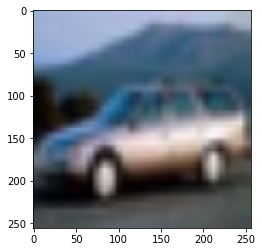

In [530]:
 for base_img in next(iter(trainloader_poison))[0]:
        imshow(base_img)

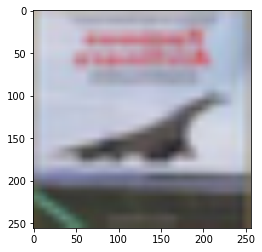

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(5005.6108, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4852.2534, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4724.1865, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4613.0420, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4514.5640, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4427.0771, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4345.2603, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4272.3467, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4205.3560, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4140.6836, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4080.6663, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4024.9617, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3975.9490, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3929.8333, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3886.9473, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3847.0667, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3808.8025, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3772.7024, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3737.5393, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3703.5000, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3671.5664, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3640.6826, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3610.3271, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3579.6292, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3549.5481, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3521.4556, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3495.2339, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3470.0239, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3445.0017, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3420.5322, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3396.9001, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3373.8672, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3352.0713, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3330.9670, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3311.2039, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3291.9358, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3273.1218, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3253.9590, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3234.5210, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3215.2051, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3195.1262, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3174.8481, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3155.3225, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3136.0198, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3116.8191, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3098.8398, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3081.3320, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3064.5066, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3048.1204, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3032.6174, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3017.5957, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3003.2334, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2989.1006, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2975.3396, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2961.9016, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2948.5437, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2935.5527, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2923.1965, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2910.6414, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2898.3369, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2886.5432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2875.0999, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2863.8704, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2852.6643, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2841.0205, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2829.3313, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2817.5894, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2806.2612, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2795.1108, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2784.4927, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2773.9875, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2763.9551, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2754.0579, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2744.2869, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2734.7751, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2725.3689, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2716.1763, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2707.1858, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2698.0603, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2689.2393, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2680.1721, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2671.0161, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2661.1667, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2651.1013, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2641.1414, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2631.6687, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2622.5508, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2613.7322, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2605.0957, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2596.5076, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2588.1313, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2579.5981, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2571.4302, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2563.2637, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2555.4424, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2547.8699, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2540.2375, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2532.7263, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2525.0747, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2517.5796, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2509.9966, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2502.5662, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2495.3811, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2488.3318, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2481.3962, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2474.6218, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2467.9722, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2461.2241, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2454.3916, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2447.9050, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2441.5303, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2435.3601, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2429.3198, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2423.4719, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2417.8413, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2412.2815, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2406.8630, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2401.3108, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2396.0320, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2390.8340, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2385.7319, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2380.7195, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2375.6257, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2370.6267, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2365.6094, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2360.7446, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2355.6497, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2350.5930, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2345.5667, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2340.6909, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2335.9443, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2331.0015, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2326.3621, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2321.7568, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2317.1833, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2312.6843, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2308.1638, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2303.6799, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2299.2114, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2294.8220, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2290.5786, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2286.2441, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2281.9741, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2277.8374, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2273.7476, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2269.7295, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2265.6975, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2261.7900, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2257.9011, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2254.0547, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2250.1799, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2246.4890, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2242.8308, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2239.1167, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2235.3511, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2231.6887, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2228.0608, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2224.4585, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2220.8850, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2217.1960, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2213.5361, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2209.9341, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2206.4045, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2202.8110, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2199.2920, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2195.6931, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2191.9812, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2188.3223, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2184.5564, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2180.6042, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2176.6155, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2172.7043, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2168.9844, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2165.1338, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2161.2771, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2157.5266, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2153.7083, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2149.7773, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2145.9133, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2142.0078, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2138.1821, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2134.3538, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2130.5178, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2126.6821, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2122.8269, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2119.0193, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2115.1333, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2111.3455, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2107.3062, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2102.7771, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2098.4749, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2094.2529, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2090.1892, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2086.1333, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2082.1333, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2078.1482, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2074.1343, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2070.1399, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2066.1162, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2062.1052, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2058.2083, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2054.2278, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2050.2900, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2046.2584, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2042.3618, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2038.4261, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2034.5897, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2030.7743, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2026.9969, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2023.3160, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2019.6786, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2016.0067, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2012.3519, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2008.5615, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2004.8452, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2001.2008, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1997.5817, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1994.0519, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1990.5685, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1987.0439, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1983.3605, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1979.7944, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1976.2465, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1972.8319, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1969.3804, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1965.7352, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1962.2087, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1958.6365, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1955.0792, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1951.5909, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1947.9967, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1944.5010, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1941.0458, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1936.9078, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1932.9333, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1929.1887, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1925.3236, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1921.5560, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1917.5371, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1913.7238, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1908.7850, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1903.9994, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1899.1677, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1894.4414, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1890.0088, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1885.5673, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1881.1901, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1875.7456, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1870.5377, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1865.3358, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1859.8528, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1854.9832, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1850.2213, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1845.6854, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1841.2648, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1837.1785, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1833.1388, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1829.2876, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1825.4164, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1821.6290, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1817.8188, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1814.2441, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1810.5936, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1807.0964, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1803.5377, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1800.1074, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1796.6320, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1793.1802, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1789.8744, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1786.5323, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1783.2128, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1779.8408, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1776.4792, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1772.9479, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1769.4365, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1765.9901, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1762.4517, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1759.1423, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1755.7332, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1752.4899, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1749.1945, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1745.9799, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1742.7654, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1739.5150, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1736.4406, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1733.3142, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1730.2152, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1727.1798, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1724.1816, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1721.2598, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1718.5111, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1715.6908, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1712.7617, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1709.8234, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1706.9111, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1704.0549, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1700.5883, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1697.4598, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1694.4034, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1691.4043, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1688.5643, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1685.8285, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1683.1772, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1680.5571, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1677.9193, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1675.2993, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1672.7493, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1670.0559, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1667.4944, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1664.9684, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1662.5065, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1660.1191, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1657.7852, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1655.4497, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1653.2036, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1650.9182, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1648.6892, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1646.5471, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1644.3396, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1642.2467, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1640.2098, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1638.1705, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1636.1661, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1634.1189, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1632.0701, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1630.0769, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1628.1045, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1626.1411, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1624.2874, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1622.3622, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1620.4758, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1618.6278, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1616.7750, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1614.9695, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1613.1887, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1611.3660, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1609.6823, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1607.8667, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1606.1500, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1604.4379, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1602.7535, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1601.0505, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1599.3379, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1597.7184, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1596.0635, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1594.3943, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1592.8020, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1591.1022, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1589.5131, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1587.8950, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1586.3014, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1584.7469, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1583.2014, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1581.6053, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1580.0316, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1578.5211, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1576.8940, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1575.2590, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1573.7239, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1572.1221, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1570.5536, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1568.8815, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1567.2693, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1565.6056, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1564.0299, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1562.4806, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1560.8766, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1559.3253, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1557.8331, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1556.3669, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1554.9097, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1553.4061, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1551.9556, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1550.5958, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1549.1328, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1547.7887, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1546.4347, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1545.0659, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1543.7006, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1542.4065, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1541.0494, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1539.7897, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1538.5262, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1537.2430, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1535.9720, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1534.7362, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1533.5247, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1532.2710, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1531.0164, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1529.8002, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1528.6011, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1527.3378, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1526.1456, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1524.9629, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1523.7798, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1522.5782, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1521.4371, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1520.2208, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1519.0255, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1517.8438, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1516.6890, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1515.5090, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1514.3262, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1513.1472, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1511.9742, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1510.8163, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1509.7234, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1508.5841, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1507.3961, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1506.3385, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1505.1208, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1503.9413, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1502.7258, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1501.5997, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1500.3986, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1499.2448, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1498.0630, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1496.9452, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1495.8081, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1494.6876, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1493.5602, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1492.4541, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1491.3546, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1490.1787, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1488.9844, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1487.8988, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1486.6548, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1485.5410, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1484.4077, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1483.3270, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1482.1660, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1481.1021, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1480.1077, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1479.0365, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1477.9857, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1476.9052, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1475.8152, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1474.6753, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1473.6283, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1472.5382, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1471.5057, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1470.4757, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1469.3402, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1468.2777, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1467.2278, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1466.1902, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1465.1288, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1464.0770, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1463.0409, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1461.9984, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1461.0012, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1459.9612, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1459.0145, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1458.0402, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1457.0446, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1456.0886, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1455.1147, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1454.2024, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1453.2148, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1452.2803, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1451.3335, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1450.4261, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1449.5059, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1448.5974, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1447.6718, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1446.7209, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1445.7794, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1444.8359, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1443.8722, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1442.9713, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1442.0156, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1441.0968, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1440.1945, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1439.2805, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1438.4062, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1437.5305, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1436.5986, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1435.7394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1434.7745, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1433.9631, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1433.0778, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1432.1812, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1431.3345, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1430.5048, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1429.6334, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1428.7756, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1427.9784, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1427.1609, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1426.3505, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1425.5320, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1424.7152, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1423.9354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1423.1124, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1422.3127, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1421.5734, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1420.7925, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1420.0627, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1419.2616, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1418.4894, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1417.6913, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1416.9396, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1416.1163, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1415.3562, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1414.5730, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1413.8213, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1413.0356, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1412.3176, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1411.5293, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1410.7666, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1409.9895, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1409.2382, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1408.4458, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1407.7092, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1406.9238, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1406.2142, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1405.4479, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1404.6343, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1403.8203, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1403.0177, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1402.2820, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1401.4916, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1400.7710, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1400.0082, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1399.2563, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1398.5099, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1397.7174, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1397.0369, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1396.2979, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1395.5636, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1394.8047, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1394.1007, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1393.3690, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1392.6349, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1391.8535, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1391.1189, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1390.3917, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1389.6311, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1388.8986, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1388.2273, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1387.4886, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1386.7666, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1386.0896, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1385.3657, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1384.7041, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1383.9783, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1383.2737, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1382.6063, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1381.9576, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1381.2260, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1380.5316, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1379.8069, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1379.1041, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1378.4121, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1377.7278, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1377.0658, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1376.4220, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1375.6891, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1375.0538, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1374.3323, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1373.6523, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1373.0233, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1372.3435, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1371.6666, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1371.0544, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1370.3923, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1369.7241, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1369.1013, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1368.4747, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1367.8395, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1367.2078, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1366.6340, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1365.9502, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1365.3096, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1364.6388, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1364.0095, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1363.3035, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1362.6638, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1361.9823, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1361.3381, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1360.6157, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1360.0005, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1359.2643, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1358.6327, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1357.9966, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1357.2744, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1356.5890, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1355.9298, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1355.2916, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1354.6344, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1353.9982, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1353.3445, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1352.6827, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1352.0057, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1351.3429, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1350.6844, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1350.0405, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1349.3499, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1348.7336, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1348.0652, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1347.4854, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1346.8279, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1346.2218, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1345.5721, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1344.9384, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1344.3729, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1343.7537, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1343.1295, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1342.4873, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1341.9310, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1341.3579, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1340.6776, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1340.1056, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1339.4613, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1338.8555, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1338.2643, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1337.6776, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1337.1556, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1336.4912, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1335.9537, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1335.3448, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1334.7596, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1334.2310, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1333.6232, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1333.0145, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1332.4045, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1331.8335, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1331.1779, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1330.5886, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1330.0754, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1329.4264, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1328.8253, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1328.2296, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1327.6124, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1327.0082, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1326.4163, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1325.7911, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1325.1670, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1324.6541, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1324.0144, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1323.4348, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1322.8451, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1322.2485, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1321.6591, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1321.0978, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1320.5377, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1319.9774, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1319.3987, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1318.8290, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1318.2719, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1317.6307, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1317.1632, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1316.5464, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1315.9801, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1315.4260, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1314.8589, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1314.3109, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1313.7666, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1313.2161, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1312.7198, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1312.1659, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1311.5923, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1311.0869, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1310.5757, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1310.0012, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1309.4537, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1308.9082, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1308.3463, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1307.8308, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1307.3500, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1306.7806, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1306.2708, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1305.7235, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1305.1440, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1304.6012, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1304.0581, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1303.5468, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1303.0364, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1302.4840, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1301.9237, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1301.3699, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1300.8712, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1300.3160, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1299.8225, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1299.2675, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1298.7981, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1298.2664, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1297.7672, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1297.2651, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1296.8098, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1296.2689, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1295.7715, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1295.2401, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1294.7706, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1294.2455, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1293.7211, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1293.2886, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1292.7902, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1292.3025, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1291.8184, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1291.3318, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1290.8314, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1290.3767, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1289.8772, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1289.4028, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1288.9613, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1288.4404, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1287.9724, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1287.4615, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1287.0123, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1286.5129, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1286.0209, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1285.5161, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1285.0247, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1284.5559, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1284.0504, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1283.4692, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1282.9144, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1282.3712, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1281.8109, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1281.2931, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1280.7253, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1280.1865, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1279.6362, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1279.1139, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1278.6176, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1278.0857, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1277.5598, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1277.0339, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1276.5397, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1275.9766, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1275.4771, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1274.9335, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1274.4672, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1273.9590, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1273.5034, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1272.9672, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1272.5104, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1271.9319, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1271.4862, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1270.9735, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1270.5179, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1270.0244, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1269.5636, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1269.0599, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1268.5234, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1268.0442, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1267.4811, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1267.0024, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1266.4923, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1266.0144, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1265.5532, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1265.0908, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1264.6290, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1264.0938, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1263.6449, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1263.1674, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1262.6749, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1262.2070, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1261.7133, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1261.2272, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1260.8080, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1260.3453, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1259.8708, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1259.4503, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1258.9788, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1258.5375, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1258.0923, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1257.6880, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1257.2192, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1256.8032, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1256.4115, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1255.9392, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1255.5496, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1255.0819, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1254.6963, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1254.2806, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1253.8835, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1253.4658, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1253.0629, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1252.6713, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1252.2393, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1251.8571, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1251.4551, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1251.0298, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1250.6399, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1250.2551, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1249.8306, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1249.3912, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1248.9777, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1248.4910, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1248.0363, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1247.6132, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1247.1720, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1246.7383, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1246.3041, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1245.8859, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1245.4485, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1245.0215, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1244.5948, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1244.2148, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1243.7798, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1243.3950, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1243.0227, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1242.6146, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1242.1906, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1241.8013, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1241.4348, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1241.0305, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1240.6248, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1240.2628, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1239.8708, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1239.4730, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1239.1058, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1238.6936, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1238.3468, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1237.9690, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1237.5736, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1237.2113, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1236.8947, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1236.5264, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1236.1384, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1235.7697, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1235.4657, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1235.1046, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1234.7649, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1234.4003, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1234.0875, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1233.6759, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1233.3387, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1233.0044, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1232.6987, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1232.3535, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1231.9735, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1231.6115, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1231.2639, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1230.9141, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1230.6039, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1230.2284, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1229.9016, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1229.5592, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1229.2390, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1228.8846, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1228.5837, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1228.2228, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1227.9382, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1227.5913, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1227.2307, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1226.8793, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1226.5522, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1226.2522, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1225.9102, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1225.6086, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1225.2788, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1224.9723, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1224.6656, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1224.3339, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1224.0176, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1223.7061, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1223.4066, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1223.1067, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1222.8209, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1222.4816, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1222.1509, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1221.8580, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1221.6313, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1221.2983, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1221.0085, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1220.7339, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1220.4629, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1220.1510, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1219.8789, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1219.5728, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1219.3213, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1218.9718, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1218.7188, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1218.4900, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1218.1720, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1217.9001, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1217.6456, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1217.3278, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1217.0762, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1216.8085, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1216.5149, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1216.2305, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1215.9879, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1215.7383, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1215.4675, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1215.1851, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1214.8917, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1214.6062, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1214.3105, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1214.0758, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1213.8145, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1213.5277, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1213.2231, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1212.9353, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1212.7194, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1212.4728, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1212.1710, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1211.9659, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1211.6329, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1211.3732, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1211.0896, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1210.8788, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1210.5732, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1210.2966, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1210.0792, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1209.8877, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1209.6029, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1209.3472, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1209.0729, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1208.8436, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1208.5867, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1208.3068, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1208.0613, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1207.8668, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1207.5657, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1207.3708, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1207.0787, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1206.8735, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1206.6205, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1206.3716, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1206.0793, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1205.8419, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1205.5895, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1205.3246, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1205.1165, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1204.8912, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1204.5992, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1204.3395, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1204.1401, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1203.9392, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1203.6819, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1203.4320, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1203.1729, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1202.9292, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1202.7146, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1202.4691, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1202.2432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1201.9911, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1201.7697, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1201.5388, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1201.3370, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1201.1030, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1200.9094, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1200.6293, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1200.4055, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1200.2007, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1200.0062, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1199.7440, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1199.4933, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1199.3062, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1199.0721, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1198.9091, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1198.6503, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1198.4526, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1198.1680, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1197.9232, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1197.6740, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1197.4601, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1197.1842, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1196.9542, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1196.7314, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1196.4836, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1196.2394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1195.9612, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1195.7667, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1195.4988, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1195.2573, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1195.0203, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1194.7896, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1194.4962, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1194.2832, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1194.0699, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1193.7810, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1193.5111, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1193.3121, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1193.1021, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1192.8557, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1192.5719, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1192.3229, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1192.1101, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1191.8649, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1191.5941, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1191.3610, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1191.1283, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1190.8531, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1190.6267, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1190.4124, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1190.1437, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1189.9554, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1189.6952, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1189.4531, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1189.1740, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1188.9979, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1188.7241, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1188.4886, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1188.2751, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1188.0382, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1187.8313, grad_fn=<PowBackward0>)


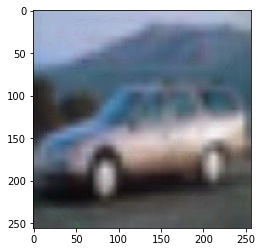

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


Parameter containing:
tensor([[ 0.0072, -0.0076, -0.0022,  ...,  0.0083, -0.0027, -0.0016],
        [ 0.0081, -0.0046,  0.0024,  ...,  0.0022,  0.0067,  0.0005]],
       requires_grad=True)
Parameter containing:
tensor([-2.2116e-05,  1.3858e-03], requires_grad=True)
Poisoning
epoch: 1, Discriminator Loss: 1.0773169994354248
Train accuracy is: 95.25% 
Test accuracy is: 93.0% 
Poisoning
epoch: 2, Discriminator Loss: 0.31340491771698
Train accuracy is: 95.625% 
Test accuracy is: 91.5% 
Poisoning
epoch: 3, Discriminator Loss: 0.31326496601104736
Train accuracy is: 95.25% 
Test accuracy is: 93.0% 
Poisoning
epoch: 4, Discriminator Loss: 0.3132668733596802
Train accuracy is: 96.5% 
Test accuracy is: 95.5% 
Poisoning
epoch: 5, Discriminator Loss: 0.31326931715011597
Train accuracy is: 96.75% 
Test accuracy is: 95.0% 


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor([[0.0086, 0.9914]], grad_fn=<SoftmaxBackward>)
Target instance is predicted as Automobile


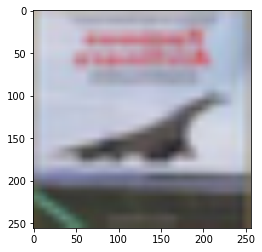

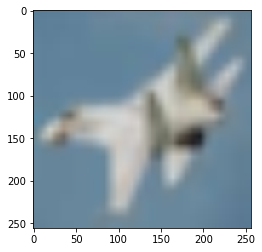

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3729.2886, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3551.8696, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3402.2014, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3270.6436, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3153.9165, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3045.9360, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2946.6147, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2860.7339, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2784.8655, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2716.6243, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2654.2019, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2597.3228, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2543.2192, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2494.7651, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2452.3059, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2413.1282, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2375.3955, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2340.1455, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2305.9158, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2271.7283, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2239.5234, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2209.5566, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2181.6174, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2156.0706, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2131.5889, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2108.8213, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2087.8865, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2068.1948, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2049.8523, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2032.3435, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2015.4250, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1999.0502, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1983.0682, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1967.9680, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1953.2219, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1939.2347, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1926.0940, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1913.6129, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1901.2483, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1889.3127, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1877.9202, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1866.7289, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1855.8419, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1845.0906, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1834.6045, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1824.4614, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1814.2000, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1804.2292, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1794.3735, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1784.5896, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1775.2417, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1765.7388, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1756.5891, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1747.2782, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1738.2780, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1729.3474, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1720.6511, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1712.1390, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1703.9495, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1695.9819, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1687.9690, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1680.0452, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1672.1455, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1664.5537, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1657.3168, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1650.4164, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1643.7057, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1637.2792, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1630.9952, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1625.0472, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1619.2102, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1613.4880, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1607.8431, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1602.3492, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1596.9668, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1591.7267, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1586.6180, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1581.5977, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1576.7477, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1571.9926, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1567.3866, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1562.8416, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1558.2677, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1553.8512, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1549.5135, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1545.2845, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1541.1228, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1537.0576, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1533.0569, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1529.1395, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1525.2344, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1521.4794, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1517.8599, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1514.2698, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1510.7849, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1507.3232, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1503.9259, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1500.5182, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1497.2109, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1493.9464, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1490.7639, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1487.6136, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1484.4535, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1481.3578, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1478.3524, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1475.3853, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1472.4594, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1469.5742, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1466.7286, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1463.8928, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1461.0485, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1458.3116, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1455.6381, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1452.9374, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1450.2952, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1447.6909, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1445.0511, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1442.4766, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1439.9399, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1437.3755, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1434.8673, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1432.4087, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1429.9862, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1427.5554, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1425.1239, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1422.7418, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1420.4060, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1418.0256, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1415.6340, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1413.3055, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1410.9912, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1408.7061, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1406.4620, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1404.2177, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1402.0449, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1399.8431, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1397.6652, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1395.5098, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1393.2830, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1391.1473, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1389.0396, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1386.9453, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1384.8958, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1382.8611, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1380.8804, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1378.9418, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1376.9763, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1375.0040, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1373.0657, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1371.1626, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1369.2561, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1367.3502, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1365.4602, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1363.6215, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1361.8010, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1359.9901, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1358.1937, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1356.3717, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1354.5875, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1352.8735, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1351.0751, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1349.3047, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1347.5604, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1345.8632, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1344.1382, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1342.4589, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1340.8248, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1339.2357, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1337.6539, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1336.0690, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1334.5164, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1332.9872, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1331.4684, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1329.9495, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1328.4672, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1327.0195, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1325.5378, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1324.0874, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1322.6614, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1321.1973, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1319.7937, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1318.3893, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1316.9767, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1315.5735, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1314.2041, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1312.8202, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1311.4771, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1310.1299, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1308.8362, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1307.4998, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1305.9967, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1304.5188, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1303.0697, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1301.6206, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1300.2095, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1298.7830, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1297.4053, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1296.0503, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1294.6932, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1293.3394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1292.0049, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1290.7053, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1289.4185, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1288.0817, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1286.8096, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1285.5551, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1284.2979, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1283.0393, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1281.8204, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1280.6167, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1279.4034, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1278.2494, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1277.0731, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1275.9202, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1274.8025, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1273.7008, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1272.6090, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1271.5305, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1270.4628, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1269.4236, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1268.3947, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1267.3091, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1266.2841, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1265.2688, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1264.2524, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1263.2731, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1262.2849, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1261.3123, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1260.3364, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1259.3772, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1258.4338, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1257.4700, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1256.4998, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1255.5704, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1254.6219, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1253.6854, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1252.7793, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1251.8867, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1250.9910, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1250.0901, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1249.2186, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1248.3430, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1247.4409, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1246.5287, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1245.6271, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1244.6692, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1243.6384, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1242.6222, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1241.6354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1240.6492, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1239.6876, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1238.7256, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1237.7980, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1236.8850, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1235.9595, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1235.0574, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1234.1732, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1233.2827, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1232.4141, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1231.5745, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1230.7382, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1229.9056, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1229.0764, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1228.2704, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1227.4622, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1226.6663, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1225.9124, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1225.1113, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1224.3176, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1223.5315, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1222.7563, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1221.9492, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1221.1461, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1220.3386, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1219.5378, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1218.7720, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1217.9982, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1217.2170, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1216.4724, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1215.7319, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1214.9822, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1214.2614, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1213.5253, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1212.7871, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1212.0873, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1211.3949, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1210.6743, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1209.9784, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1209.3076, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1208.6166, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1207.9541, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1207.2743, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1206.5958, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1205.9159, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1205.2181, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1204.5375, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1203.8555, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1203.1716, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1202.4993, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1201.8123, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1201.1255, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1200.4095, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1199.7031, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1198.9871, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1198.2372, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1197.4819, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1196.7803, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1196.0820, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1195.3813, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1194.7012, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1194.0201, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1193.3785, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1192.7400, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1192.0721, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1191.4553, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1190.8552, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1190.2047, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1189.5863, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1188.9598, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1188.3467, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1187.7429, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1187.1466, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1186.5261, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1185.9211, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1185.3243, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1184.6935, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1184.1421, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1183.5475, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1182.9518, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1182.3494, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1181.7781, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1181.1825, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1180.5945, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1180.0128, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1179.3967, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1178.8322, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1178.2908, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1177.7134, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1177.1331, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1176.5829, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1176.0098, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1175.4335, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1174.8788, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1174.3208, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1173.7966, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1173.2263, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1172.6606, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1172.1217, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1171.5409, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1170.9868, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1170.4448, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1169.8999, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1169.3392, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1168.8154, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1168.2502, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1167.6927, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1167.1490, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1166.6058, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1166.0764, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1165.5283, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1164.9971, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1164.4680, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1163.9543, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1163.4614, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1162.9319, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1162.4236, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1161.9034, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1161.3771, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1160.8756, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1160.3602, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1159.8685, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1159.3695, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1158.8733, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1158.3950, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1157.9001, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1157.4253, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1156.9445, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1156.4729, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1156.0002, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1155.5461, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1155.0962, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1154.6334, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1154.1958, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1153.7223, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1153.2792, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1152.8477, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1152.4204, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1151.9996, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1151.5721, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1151.1346, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1150.7389, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1150.3394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1149.8910, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1149.4736, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1149.0691, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1148.6595, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1148.2551, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1147.8633, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1147.4520, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1147.0601, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1146.6519, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1146.2628, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1145.8467, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1145.4495, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1145.0646, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1144.6582, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1144.2783, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1143.8755, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1143.4851, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1143.0782, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1142.6849, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1142.2786, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1141.8070, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1141.3245, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1140.8505, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1140.3699, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1139.9142, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1139.4612, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1138.9933, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1138.5511, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1138.1121, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1137.6790, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1137.2474, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1136.8103, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1136.3959, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1135.9878, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1135.5538, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1135.1429, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1134.7330, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1134.2996, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1133.9136, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1133.4769, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1133.0801, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1132.6700, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1132.2677, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1131.8751, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1131.4851, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1131.0258, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1130.6180, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1130.2053, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1129.7904, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1129.3995, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1128.9747, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1128.5680, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1128.1251, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1127.6703, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1127.2510, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1126.8142, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1126.3999, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1125.9675, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1125.5364, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1125.1279, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1124.7003, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1124.2941, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1123.8840, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1123.4574, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1123.0021, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1122.5626, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1122.1072, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1121.6660, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1121.2162, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1120.7809, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1120.3452, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1119.9072, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1119.4955, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1119.0248, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1118.5917, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1118.1294, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1117.6960, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1117.2704, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1116.8295, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1116.4475, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1116.0066, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1115.5851, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1115.1904, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1114.7456, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1114.3643, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1113.9535, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1113.5541, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1113.1697, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1112.7601, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1112.3730, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1111.9952, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1111.5956, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1111.2369, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1110.8555, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1110.4827, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1110.0790, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1109.7389, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1109.3768, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1109.0024, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1108.6417, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1108.2816, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1107.9263, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1107.5852, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1107.2170, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1106.8856, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1106.5239, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1106.1826, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1105.8253, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1105.5060, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1105.1523, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1104.7847, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1104.4691, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1104.1371, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1103.8240, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1103.4821, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1103.1658, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1102.8212, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1102.5035, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1102.1945, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1101.8754, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1101.5474, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1101.2051, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1100.8906, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1100.5652, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1100.2280, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1099.9178, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1099.6108, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1099.2990, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1098.9871, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1098.6525, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1098.3700, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1098.0681, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1097.7548, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1097.4592, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1097.1299, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1096.8380, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1096.4979, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1096.1870, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1095.8778, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1095.5649, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1095.2216, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1094.9408, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1094.5992, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1094.2472, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1093.8606, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1093.4915, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1093.1230, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1092.7509, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1092.3842, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1092.0372, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1091.7156, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1091.3778, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1091.0355, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1090.6754, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1090.3270, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1089.9778, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1089.6421, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1089.3175, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1088.9877, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1088.6564, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1088.3641, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1088.0027, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1087.7113, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1087.3883, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1087.0826, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1086.7509, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1086.4518, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1086.1483, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1085.8285, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1085.5510, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1085.2272, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1084.9171, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1084.6241, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1084.3136, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1084.0297, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1083.7340, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1083.4207, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1083.1190, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1082.8025, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1082.5038, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1082.1947, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1081.9121, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1081.6396, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1081.3208, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1081.0460, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1080.7678, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1080.4507, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1080.1705, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1079.8634, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1079.5996, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1079.3197, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1079.0187, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1078.7395, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1078.4493, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1078.1882, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1077.8861, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1077.6046, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1077.3572, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1077.0504, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1076.8136, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1076.5242, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1076.2754, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1076.0204, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1075.7518, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1075.4767, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1075.2021, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1074.9608, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1074.7059, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1074.4258, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1074.1744, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1073.9122, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1073.6602, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1073.4244, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1073.1646, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1072.9050, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1072.6777, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1072.4056, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1072.1500, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1071.9163, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1071.6155, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1071.3862, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1071.1021, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1070.8584, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1070.5833, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1070.3434, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1070.0736, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1069.8357, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1069.5675, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1069.3165, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1069.0541, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1068.8057, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1068.5719, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1068.3300, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1068.0166, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1067.7476, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1067.4906, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1067.2189, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1066.9519, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1066.6855, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1066.4266, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1066.1868, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1065.9481, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1065.6771, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1065.4552, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1065.2261, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1064.9604, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1064.7197, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1064.4563, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1064.2457, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1064.0026, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1063.7739, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1063.4863, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1063.2146, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1062.9469, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1062.6766, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1062.4230, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1062.1742, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1061.9034, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1061.6753, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1061.4122, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1061.1824, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1060.9021, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1060.6871, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1060.4354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1060.2014, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1059.9823, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1059.7386, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1059.5032, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1059.2871, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1059.0535, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1058.8010, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1058.5942, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1058.3627, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1058.1335, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1057.9346, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1057.6978, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1057.5023, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1057.2659, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1057.0570, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1056.8549, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1056.6433, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1056.4275, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1056.2294, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1056.0090, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1055.8253, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1055.6049, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1055.4237, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1055.2233, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1055.0304, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1054.8245, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1054.6354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1054.4197, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1054.2247, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1054.0436, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1053.8353, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1053.6495, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1053.4420, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1053.2571, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1053.0786, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1052.8682, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1052.7059, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1052.4836, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1052.3037, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1052.1199, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1051.9329, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1051.7272, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1051.5594, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1051.3618, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1051.1926, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1051.0083, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1050.8027, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1050.6448, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1050.4399, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1050.2419, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1050.0941, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1049.8783, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1049.7003, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1049.5240, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1049.3503, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1049.1567, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1048.9574, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1048.7695, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1048.5909, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1048.4027, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1048.2164, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1048.0315, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1047.8519, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1047.6656, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1047.4694, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1047.2783, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1047.0973, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1046.9208, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1046.7426, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1046.5619, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1046.3759, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1046.2056, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1046.0421, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1045.8428, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1045.6671, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1045.4871, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1045.3008, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1045.1207, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1044.9675, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1044.7755, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1044.6049, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1044.4120, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1044.2609, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1044.0935, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1043.9091, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1043.7587, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1043.5704, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1043.4193, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1043.2548, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1043.0835, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1042.9139, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1042.7405, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1042.5759, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1042.4252, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1042.2498, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1042.0875, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1041.9183, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1041.7552, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1041.5989, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1041.4105, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1041.2117, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1041.0306, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1040.8239, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1040.6545, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1040.4589, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1040.2999, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1040.1151, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1039.9498, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1039.7458, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1039.5919, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1039.3978, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1039.2258, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1039.0532, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1038.8828, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1038.6940, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1038.5272, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1038.3291, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1038.0978, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1037.8755, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1037.6595, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1037.4292, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1037.2469, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1037.0162, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1036.7933, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1036.5531, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1036.3417, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1036.1486, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1035.9293, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1035.7250, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1035.5487, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1035.3530, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1035.1417, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1034.9664, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1034.7860, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1034.5897, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1034.4315, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1034.2020, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1034.0359, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1033.8687, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1033.7063, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1033.5127, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1033.3604, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1033.1703, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1032.9899, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1032.8231, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1032.6630, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1032.4838, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1032.3357, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1032.1727, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1032.0002, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1031.8544, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1031.6779, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1031.5248, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1031.3625, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1031.1932, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1031.0590, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1030.9159, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1030.7521, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1030.6105, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1030.4503, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1030.3009, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1030.0945, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1029.9451, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1029.7841, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1029.6293, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1029.4396, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1029.2798, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1029.1160, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1028.9606, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1028.7898, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1028.6373, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1028.4849, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1028.3126, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1028.1528, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1028.0005, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1027.8677, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1027.7200, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1027.5519, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1027.4171, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1027.2609, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1027.1340, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1026.9658, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1026.8271, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1026.6880, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1026.5607, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1026.4146, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1026.2883, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1026.1385, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1026.0137, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1025.8741, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1025.7512, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1025.6154, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1025.4573, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1025.3342, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1025.2111, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1025.0562, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1024.9438, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1024.8129, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1024.6530, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1024.5360, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1024.4060, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1024.2710, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1024.1467, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1024.0339, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1023.9017, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1023.7576, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1023.6392, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1023.4966, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1023.3919, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1023.2455, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1023.1318, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1022.9965, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1022.8698, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1022.7338, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1022.6270, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1022.4946, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1022.3865, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1022.2727, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1022.1329, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1022.0157, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1021.8920, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1021.7589, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1021.6558, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1021.5190, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1021.3846, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1021.2766, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1021.1605, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1021.0389, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1020.9138, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1020.8039, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1020.7054, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1020.5795, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1020.4684, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1020.3356, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1020.2242, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1020.1313, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1020.0051, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1019.9024, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1019.7701, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1019.6588, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1019.5737, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1019.4471, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1019.3443, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1019.2332, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1019.1269, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1019.0213, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.9142, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.8123, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.7135, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.5976, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.4948, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.4047, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.2921, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.1758, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.0742, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.0011, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1017.8835, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1017.7953, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1017.6688, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1017.5827, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1017.5009, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1017.3920, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1017.2850, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1017.1738, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1017.0804, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.9662, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.8774, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.7537, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.6808, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.5534, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.4708, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.3660, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.2604, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.1769, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.0776, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1015.9741, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1015.9028, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1015.7655, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1015.6950, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1015.5853, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1015.5060, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1015.4119, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1015.3071, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1015.1851, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1015.0886, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1014.9802, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1014.9089, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1014.7631, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1014.6343, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1014.4933, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1014.3481, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1014.2180, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1014.0961, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1013.9360, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1013.8328, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1013.6807, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1013.5643, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1013.4419, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1013.3215, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1013.1961, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1013.0784, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1012.9633, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1012.8621, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1012.7573, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1012.6488, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1012.5534, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1012.4244, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1012.3264, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1012.2040, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1012.0991, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.9952, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.8802, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.7886, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.6735, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.5609, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.4485, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.3254, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.2261, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.0807, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1010.9623, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1010.8545, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1010.7336, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1010.6032, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1010.5168, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1010.3819, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1010.2595, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1010.1588, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1010.0438, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1009.9334, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1009.8041, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1009.7009, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1009.5889, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1009.4984, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1009.3675, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1009.2628, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1009.1622, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1009.0289, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1008.9494, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1008.8545, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1008.7477, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1008.6456, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1008.5361, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1008.4059, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1008.3101, grad_fn=<PowBackward0>)


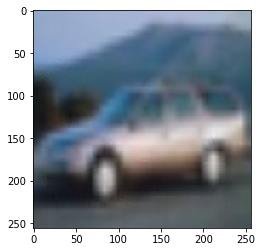

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


Parameter containing:
tensor([[ 0.0039, -0.0066,  0.0004,  ..., -0.0089, -0.0056, -0.0020],
        [-0.0005, -0.0052,  0.0017,  ..., -0.0019, -0.0054, -0.0059]],
       requires_grad=True)
Parameter containing:
tensor([-0.0020,  0.0078], requires_grad=True)
Poisoning
epoch: 1, Discriminator Loss: 1.3117592334747314
Train accuracy is: 65.25% 
Test accuracy is: 91.5% 
Poisoning
epoch: 2, Discriminator Loss: 1.3126142024993896
Train accuracy is: 68.5% 
Test accuracy is: 92.5% 
Poisoning
epoch: 3, Discriminator Loss: 1.3113493919372559
Train accuracy is: 72.0% 
Test accuracy is: 95.5% 
Poisoning
epoch: 4, Discriminator Loss: 1.3127102851867676
Train accuracy is: 69.375% 
Test accuracy is: 94.0% 
Poisoning
epoch: 5, Discriminator Loss: 1.3045101165771484
Train accuracy is: 70.875% 
Test accuracy is: 95.5% 


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor([[9.9998e-01, 2.3964e-05]], grad_fn=<SoftmaxBackward>)
Target instance is predicted as Airplane


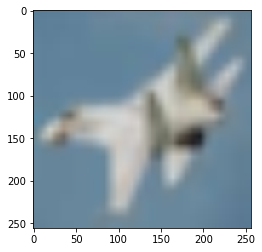

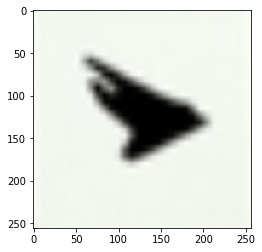

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(5156.7734, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(5005.2300, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4874.6587, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4758.6694, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4652.0596, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4551.3291, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4459.4917, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4371.7729, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4292.6040, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4221.9023, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4157.0029, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4093.9666, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4034.4783, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3977.1653, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3922.8701, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3873.9988, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3826.7847, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3783.2983, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3743.0691, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3704.5735, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3667.2251, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3631.2656, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3596.7346, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3563.6755, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3531.7554, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3502.0042, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3473.3721, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3446.4648, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3419.5647, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3394.8245, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3370.7715, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3348.2043, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3326.8103, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3305.5354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3284.7415, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3264.3230, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3244.2024, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3224.4187, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3205.1064, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3186.5083, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3168.2141, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3150.9441, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3134.3928, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3117.9692, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3101.9182, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3085.9905, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3070.7886, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3055.5144, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3040.6387, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3026.0042, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3011.7366, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2997.4290, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2982.8096, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2968.2275, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2953.7605, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2939.6841, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2925.6680, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2912.4365, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2899.5798, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2887.2097, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2875.1267, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2863.3286, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2851.6311, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2840.3423, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2829.4109, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2818.5745, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2808.2471, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2797.9993, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2787.7244, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2777.3079, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2767.1599, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2757.4502, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2747.8469, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2738.4929, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2729.2686, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2720.2834, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2711.4802, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2702.8333, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2694.3694, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2686.0916, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2677.6748, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2669.3071, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2661.0476, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2652.7517, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2644.5940, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2636.4106, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2628.3684, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2620.4844, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2612.8210, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2605.2881, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2597.8318, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2590.5493, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2583.4150, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2576.3918, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2569.2678, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2562.4739, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2555.5632, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2548.9141, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2542.3687, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2535.7820, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2529.1973, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2522.9133, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2516.7056, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2510.5205, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2504.5718, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2498.7612, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2492.8037, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2487.0798, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2481.4802, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2476.0469, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2470.7188, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2465.1707, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2459.7732, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2454.6069, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2449.4846, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2444.4575, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2439.3618, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2434.4028, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2429.5291, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2424.6331, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2419.9424, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2415.2217, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2410.4353, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2405.8411, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2401.1680, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2396.5085, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2392.0254, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2387.4578, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2382.7649, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2377.9763, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2373.2820, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2368.6279, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2364.1057, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2359.7976, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2355.1008, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2350.4697, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2346.0200, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2341.5237, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2337.1187, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2332.7673, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2328.3801, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2323.8645, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2319.4998, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2315.2339, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2311.1055, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2306.8538, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2302.6819, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2298.4050, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2294.2512, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2290.1970, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2286.0557, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2281.9526, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2277.8896, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2273.8647, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2269.6792, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2265.6509, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2261.7461, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2257.8147, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2254.0261, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2250.2092, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2246.3650, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2242.7395, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2239.0137, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2235.3154, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2231.7119, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2228.2871, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2224.6975, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2221.3157, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2217.7178, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2214.2473, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2210.6838, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2207.3416, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2203.8650, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2200.5525, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2197.1858, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2193.8682, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2190.5791, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2187.2876, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2184.1682, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2181.0603, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2177.9680, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2174.8545, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2171.8062, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2168.7476, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2165.8223, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2162.8347, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2159.8105, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2156.9941, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2153.9854, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2151.1604, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2148.1685, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2145.3403, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2142.4219, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2139.5623, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2136.6995, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2133.8215, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2131.0176, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2128.1436, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2125.2063, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2122.4573, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2119.5608, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2116.8472, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2114.0427, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2111.4644, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2108.6687, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2106.1843, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2103.5073, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2101.0129, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2098.4614, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2096.0535, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2093.5679, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2091.2239, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2088.8381, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2086.5417, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2084.2097, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2081.8962, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2079.6021, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2077.2734, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2074.9924, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2072.6460, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2070.3296, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2068.0864, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2065.7920, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2063.5930, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2061.2969, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2058.9944, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2056.5942, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2054.2559, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2052.0217, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2049.7578, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2047.4165, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2045.2594, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2043.0173, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2040.8671, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2038.6938, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2036.4943, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2034.3584, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2032.2355, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2030.1067, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2028.0454, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2025.9048, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2023.9142, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2021.7953, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2019.7605, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2017.7953, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2015.7964, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2013.8156, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2011.8053, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2009.7742, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2007.7632, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2005.8192, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2003.8881, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2001.8391, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1999.9211, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1997.8595, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1995.9688, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1994.0471, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1992.0757, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1990.1808, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1988.4209, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1986.5441, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1984.6783, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1982.8478, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1981.0435, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1979.2441, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1977.4487, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1975.7134, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1973.9104, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1972.1902, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1970.5093, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1968.8018, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1967.1011, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1965.4430, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1963.7465, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1962.1523, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1960.5149, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1958.9215, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1957.3026, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1955.6366, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1954.1007, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1952.4324, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1950.8964, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1949.3735, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1947.8011, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1946.1166, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1944.6171, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1943.1639, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1941.5526, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1939.9501, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1938.2877, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1936.7097, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1934.9602, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1933.4486, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1931.8601, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1930.3541, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1928.7914, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1927.2596, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1925.6804, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1924.2411, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1922.6963, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1921.1978, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1919.7030, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1918.1445, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1916.7009, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1915.2593, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1913.7701, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1912.2772, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1910.8539, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1909.3536, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1907.9628, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1906.4597, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1905.0359, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1903.6998, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1902.2524, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1900.8455, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1899.4031, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1898.1355, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1896.7802, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1895.4889, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1894.1262, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1892.7930, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1891.5239, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1890.3302, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1888.8405, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1887.6327, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1886.3306, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1885.0869, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1883.7839, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1882.5769, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1881.2742, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1880.0447, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1878.7935, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1877.6362, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1876.3788, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1875.1642, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1873.9105, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1872.8037, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1871.5806, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1870.3916, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1869.2507, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1868.1591, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1866.9121, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1865.8175, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1864.6738, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1863.5602, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1862.3977, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1861.4459, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1860.2510, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1859.1490, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1858.0610, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1857.0210, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1855.9381, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1854.9703, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1853.8267, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1852.7733, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1851.6310, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1850.6270, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1849.5643, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1848.5060, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1847.3683, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1846.3125, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1845.2190, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1844.1416, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1843.1736, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1842.1616, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1841.1345, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1839.9926, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1838.9965, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1838.0164, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1837.0791, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1836.0214, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1834.9930, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1833.9836, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1832.9598, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1832.0375, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1831.0449, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1830.0363, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1829.0658, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1828.0906, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1827.0264, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1826.2415, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1825.1530, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1824.0939, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1823.0901, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1822.0012, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1820.9677, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1820.0071, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1818.9950, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1818.0508, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1816.8123, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1815.8872, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1814.8889, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1813.9088, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1812.8525, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1811.8555, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1810.9371, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1809.9165, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1808.9364, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1808.0117, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1807.1211, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1806.1523, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1805.2139, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1804.3848, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1803.3857, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1802.5037, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1801.6746, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1800.8119, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1799.8844, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1798.9977, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1798.1105, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1797.1410, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1796.2627, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1795.4276, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1794.5297, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1793.5986, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1792.7942, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1791.9111, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1791.0186, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1790.1307, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1789.2344, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1788.3816, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1787.5741, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1786.7539, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1785.9165, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1784.9700, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1784.1162, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1783.2472, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1782.5024, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1781.7159, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1780.8140, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1779.9718, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1779.1312, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1778.3702, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1777.5688, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1776.7239, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1775.8734, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1775.0598, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1774.2454, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1773.4530, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1772.5917, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1771.8751, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1771.0746, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1770.2399, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1769.5264, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1768.7700, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1767.9866, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1767.1317, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1766.3544, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1765.6167, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1764.7867, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1764.1006, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1763.3175, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1762.5193, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1761.7910, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1761.0645, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1760.4191, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1759.5635, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1758.8348, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1758.0149, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1757.3544, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1756.5216, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1755.7834, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1754.9951, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1754.2703, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1753.5239, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1752.8419, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1751.9844, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1751.3180, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1750.4771, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1749.7925, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1749.1182, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1748.4200, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1747.7180, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1746.9357, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1746.1973, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1745.4879, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1744.7982, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1744.0892, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1743.3629, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1742.6847, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1741.9669, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1741.2366, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1740.5454, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1739.7889, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1739.0831, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1738.4158, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1737.7589, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1737.0106, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1736.3405, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1735.6792, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1734.9457, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1734.2438, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1733.6189, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1732.8579, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1732.0516, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1731.3143, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1730.6643, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1729.8674, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1729.1180, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1728.3668, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1727.6514, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1726.9893, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1726.2002, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1725.5051, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1724.7852, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1723.9642, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1723.2238, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1722.4415, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1721.7931, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1721.0082, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1720.2147, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1719.4956, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1718.8271, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1718.0554, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1717.3212, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1716.7534, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1715.8918, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1715.1919, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1714.3979, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1713.8243, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1713.0692, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1712.3585, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1711.6492, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1711.0583, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1710.2994, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1709.5833, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1708.9158, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1708.2601, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1707.5741, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1707., grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1706.2943, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1705.5778, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1704.8739, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1704.1907, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1703.5587, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1702.8855, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1702.2074, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1701.4813, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1700.7899, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1700.1249, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1699.3778, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1698.6967, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1697.9924, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1697.3407, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1696.6996, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1696.1293, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1695.4312, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1694.7517, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1694.0897, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1693.4517, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1692.8313, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1692.2308, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1691.5292, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1691.0115, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1690.3232, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1689.7791, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1689.0879, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1688.5232, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1687.9098, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1687.3625, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1686.7693, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1686.2207, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1685.6099, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1684.9878, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1684.4288, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1683.8174, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1683.3262, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1682.8219, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1682.2709, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1681.6816, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1681.1383, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1680.5884, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1680.0223, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1679.3698, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1678.9039, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1678.2828, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1677.7759, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1677.2574, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1676.7476, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1676.1475, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1675.7330, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1675.0957, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1674.5540, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1673.9698, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1673.5145, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1672.9318, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1672.4250, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1671.8960, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1671.4149, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1670.8944, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1670.3658, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1669.9362, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1669.3439, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1668.8567, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1668.3466, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1667.8798, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1667.4336, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1666.9000, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1666.3636, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1665.9124, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1665.3881, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1665.0688, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1664.4497, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1663.9418, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1663.5441, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1662.9476, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1662.4349, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1661.9308, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1661.4689, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1661.0012, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1660.5330, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1660.0518, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1659.5470, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1659.0233, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1658.4656, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1657.9734, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1657.4686, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1656.9429, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1656.4628, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1656.0160, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1655.5137, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1655.1071, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1654.5419, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1653.9907, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1653.5709, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1653.0321, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1652.6174, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1652.1379, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1651.6266, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1651.0692, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1650.7133, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1650.1141, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1649.7286, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1649.2537, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1648.8409, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1648.3580, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1647.8646, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1647.3846, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1646.8625, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1646.4025, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1645.9701, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1645.5531, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1645.0961, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1644.6987, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1644.2542, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1643.7676, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1643.3185, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1642.8215, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1642.3373, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1641.8383, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1641.4404, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1641.0103, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1640.6628, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1640.1965, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1639.7251, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1639.2228, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1638.7585, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1638.2947, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1637.8719, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1637.4724, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1637.0146, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1636.6056, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1636.1683, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1635.7341, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1635.2574, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1634.7802, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1634.3607, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1633.9122, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1633.5709, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1633.0399, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1632.7964, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1632.2109, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1631.8430, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1631.4180, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1631.0393, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1630.6338, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1630.1973, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1629.7972, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1629.3799, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1629.1135, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1628.6621, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1628.3268, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1627.9257, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1627.4464, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1627.0964, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1626.7229, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1626.3352, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1625.9232, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1625.6097, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1625.2493, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1624.9058, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1624.4829, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1624.1335, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1623.7434, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1623.3389, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1623.0389, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1622.6510, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1622.3286, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1621.8936, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1621.5251, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1621.1510, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1620.7689, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1620.3119, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1620.0917, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1619.4613, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1619.1705, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1618.5042, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1618.0717, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1617.6040, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1617.1628, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1616.6149, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1616.1901, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1615.6996, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1615.2136, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1614.8717, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1614.4419, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1613.8733, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1613.3101, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1612.9487, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1612.4337, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1612.0248, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1611.5040, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1611.1791, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1610.7424, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1610.2156, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1609.7714, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1609.3527, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1608.9333, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1608.5132, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1608.0999, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1607.7091, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1607.2715, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1606.8065, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1606.3772, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1605.9877, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1605.5979, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1605.1720, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1604.7295, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1604.3251, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1603.8583, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1603.4696, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1603.0715, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1602.7029, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1602.3287, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1601.9125, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1601.4438, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1601.0830, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1600.7777, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1600.4160, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1599.9762, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1599.5721, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1599.1743, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1598.7719, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1598.4324, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1598.0551, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1597.6705, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1597.3031, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1596.9448, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1596.5833, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1596.2534, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1595.8877, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1595.4762, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1595.1304, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1594.7860, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1594.4518, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1594.0948, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1593.7028, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1593.4095, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1593.0581, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1592.7280, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1592.3134, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1591.9580, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1591.6555, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1591.3643, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1590.9976, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1590.5852, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1590.2334, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1589.9277, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1589.5667, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1589.2710, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1588.8309, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1588.4973, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1588.1844, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1587.8840, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1587.5256, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1587.1870, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1586.9432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1586.5952, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1586.2422, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1585.8190, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1585.5394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1585.1746, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1584.8147, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1584.4351, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1584.1620, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1583.8893, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1583.5393, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1583.2196, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1582.9324, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1582.5548, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1582.2444, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1581.9233, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1581.5133, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1581.2179, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1580.9373, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1580.6572, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1580.3312, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1579.9679, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1579.7068, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1579.3508, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1579.0061, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1578.5905, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1578.2052, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1577.9258, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1577.6245, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1577.3015, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1576.9513, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1576.5411, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1576.2936, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1576.0214, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1575.6515, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1575.3014, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1575.0128, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1574.6501, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1574.3386, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1574.1301, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1573.8153, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1573.5356, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1573.1895, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1572.8868, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1572.5719, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1572.3147, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1572.0745, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1571.8286, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1571.4327, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1571.0471, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1570.7499, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1570.5122, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1570.2733, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1569.8480, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1569.5886, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1569.2755, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1569.0074, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1568.6884, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1568.4479, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1568.1085, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1567.9270, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1567.5400, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1567.2316, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1566.9357, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1566.7031, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1566.3708, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1566.0563, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1565.8263, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1565.5415, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1565.2623, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1564.9575, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1564.7339, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1564.4637, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1564.1243, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1563.8850, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1563.6826, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1563.3378, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1563.0144, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1562.7269, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1562.4338, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1562.1609, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1561.8118, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1561.5892, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1561.3076, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1561.0128, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1560.7777, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1560.5450, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1560.3881, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1559.9213, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1559.5837, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1559.3057, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1559.0430, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1558.7667, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1558.4165, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1558.0867, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1557.8888, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1557.5172, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1557.1659, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1556.8495, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1556.5789, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1556.2069, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1555.8481, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1555.5604, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1555.2620, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1554.9611, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1554.6531, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1554.3387, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1553.9622, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1553.6581, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1553.3126, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1552.9875, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1552.6740, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1552.3322, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1551.9663, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1551.7025, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1551.3969, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1551.0317, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1550.6727, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1550.3068, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1550.0094, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1549.7472, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1549.4196, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1549.0847, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1548.7823, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1548.4740, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1548.1434, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1547.8280, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1547.5225, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1547.1957, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1546.8103, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1546.5475, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1546.0986, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1545.8617, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1545.4307, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1545.1200, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1544.7128, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1544.4875, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1544.1412, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1543.8352, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1543.4081, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1543.1023, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1542.7103, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1542.3840, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1542.1156, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1541.7965, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1541.5275, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1541.2202, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1540.8461, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1540.5583, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1540.2161, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1539.8849, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1539.6161, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1539.2832, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1539.0049, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1538.7118, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1538.4392, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1538.1283, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1537.8171, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1537.4824, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1537.1207, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1536.9122, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1536.6873, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1536.3042, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1536.0375, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1535.7421, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1535.4813, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1535.2255, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1534.9062, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1534.6246, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1534.4298, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1534.0004, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1533.7461, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1533.5286, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1533.2598, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1532.9962, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1532.7297, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1532.4556, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1532.1483, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1531.8834, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1531.4950, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1531.3544, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1531.0529, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1530.7997, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1530.3976, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1530.1355, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1529.8339, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1529.5229, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1529.2618, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1529.0352, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1528.7306, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1528.4523, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1528.1066, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1527.9249, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1527.6741, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1527.4785, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1527.1350, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1526.9595, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1526.6945, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1526.4330, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1526.0363, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1525.8253, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1525.5460, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1525.3252, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1524.9867, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1524.8086, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1524.5393, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1524.4460, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1524.0830, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1523.9453, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1523.6106, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1523.3102, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1523.1169, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1522.9237, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1522.6738, grad_fn=<PowBackward0>)


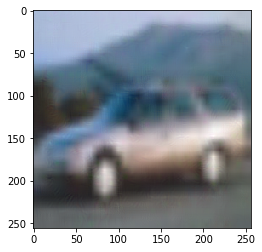

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


Parameter containing:
tensor([[ 0.0052,  0.0030,  0.0005,  ...,  0.0076,  0.0073, -0.0070],
        [ 0.0050, -0.0005, -0.0070,  ..., -0.0052,  0.0027,  0.0025]],
       requires_grad=True)
Parameter containing:
tensor([-0.0034, -0.0009], requires_grad=True)
Poisoning
epoch: 1, Discriminator Loss: 1.3121955394744873
Train accuracy is: 69.625% 
Test accuracy is: 92.0% 
Poisoning
epoch: 2, Discriminator Loss: 1.3128681182861328
Train accuracy is: 72.125% 
Test accuracy is: 95.0% 
Poisoning
epoch: 3, Discriminator Loss: 1.3129395246505737
Train accuracy is: 71.625% 
Test accuracy is: 95.0% 
Poisoning
epoch: 4, Discriminator Loss: 1.3129526376724243
Train accuracy is: 71.0% 
Test accuracy is: 96.0% 
Poisoning
epoch: 5, Discriminator Loss: 1.3125712871551514
Train accuracy is: 72.75% 
Test accuracy is: 96.0% 


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor([[1.0000e+00, 5.3105e-08]], grad_fn=<SoftmaxBackward>)
Target instance is predicted as Airplane


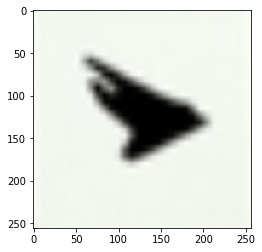

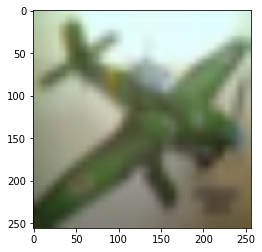

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3777.9902, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3619.7341, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3487.1431, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3373.9570, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3272.7349, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3179.9326, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3097.1196, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3019.1304, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2949.1909, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2884.6111, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2826.1211, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2774.0508, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2724.3738, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2678.8652, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2636.8647, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2598.6433, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2562.4041, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2528.0122, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2496.2341, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2467.3337, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2439.8533, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2413.4500, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2388.4771, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2364.9727, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2343.0115, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2322.0183, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2302.2026, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2282.6133, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2263.2576, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2244.5056, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2226.9021, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2209.8242, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2193.0420, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2177.1064, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2161.4604, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2146.3179, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2131.4668, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2117.5967, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2103.7993, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2090.1519, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2077.0227, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2063.8777, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2050.9441, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2038.3501, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2026.0452, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2014.2050, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2002.8732, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1992.0134, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1981.5875, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1971.0557, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1960.8193, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1950.9130, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1941.4700, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1932.0496, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1922.9471, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1914.0488, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1905.3982, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1896.9403, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1888.6501, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1880.5562, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1872.7280, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1865.1918, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1857.9078, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1850.8950, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1843.8926, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1837.0493, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1830.2057, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1823.5377, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1816.8406, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1810.3271, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1803.8284, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1797.5366, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1791.4254, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1785.3275, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1779.2986, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1773.3749, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1767.3123, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1761.3718, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1755.5101, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1749.7130, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1744.0507, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1738.5229, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1733.0449, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1727.6891, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1722.2504, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1717.0284, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1711.9790, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1706.9502, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1701.9119, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1696.9271, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1692.1379, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1687.3306, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1682.6768, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1678.0619, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1673.4249, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1668.7975, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1664.3306, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1659.9457, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1655.5214, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1651.1268, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1646.7418, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1642.4186, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1638.3296, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1634.1324, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1629.9993, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1625.7064, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1621.6075, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1617.6375, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1613.6882, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1609.9058, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1606.0769, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1602.4341, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1598.8210, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1595.2888, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1591.7358, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1588.2222, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1584.7390, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1581.3280, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1577.9282, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1574.6278, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1571.3198, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1568.0311, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1564.7831, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1561.5992, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1558.3804, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1555.2069, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1552.0983, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1549.0057, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1545.9913, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1543.0244, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1539.9613, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1536.8877, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1533.7874, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1530.7960, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1527.8685, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1524.9644, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1522.1106, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1519.2688, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1516.4462, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1513.5651, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1510.7146, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1507.8428, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1504.9291, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1502.0708, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1499.1505, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1496.2876, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1493.4475, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1490.6670, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1487.8715, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1485.1373, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1482.3754, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1479.6633, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1477.0106, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1474.2463, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1471.4469, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1468.5481, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1465.6877, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1462.9072, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1460.0912, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1457.3524, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1454.6564, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1451.8851, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1449.1997, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1446.4750, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1443.7780, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1440.8295, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1437.6300, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1434.4962, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1431.3798, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1428.3506, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1425.1987, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1422.1321, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1419.1814, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1416.4247, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1413.7303, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1411.1143, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1408.5417, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1406.0157, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1403.5256, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1401.1488, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1398.8212, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1396.6041, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1394.2819, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1392.0128, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1389.7699, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1387.5375, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1385.3356, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1383.0430, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1380.8857, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1378.7429, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1376.6793, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1374.5933, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1372.5554, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1370.5688, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1368.5560, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1366.6095, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1364.6475, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1362.5413, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1360.4719, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1358.5067, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1356.5029, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1354.5942, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1352.6616, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1350.8090, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1348.9889, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1347.2090, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1345.3975, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1343.5470, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1341.6913, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1339.8595, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1338.0095, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1336.2140, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1334.4124, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1332.6143, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1330.8057, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1328.9565, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1327.1066, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1325.2003, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1323.2191, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1321.2899, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1319.3716, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1317.4077, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1315.4944, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1313.3513, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1311.2662, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1309.1981, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1307.2004, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1305.2970, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1303.4784, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1301.6044, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1299.7903, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1298.0308, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1296.2933, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1294.6040, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1292.9166, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1291.2863, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1289.6613, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1288.0352, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1286.4557, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1284.9323, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1283.3889, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1281.9380, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1280.3893, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1278.9109, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1277.4320, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1275.9412, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1274.4926, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1273.0608, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1271.6339, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1270.2427, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1268.7854, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1267.3843, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1265.9833, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1264.5959, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1263.2280, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1261.8143, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1260.4236, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1259.0842, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1257.7386, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1256.3331, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1254.9036, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1253.4237, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1251.9451, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1250.4961, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1249.0656, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1247.5975, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1246.1594, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1244.7644, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1243.4103, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1242.0968, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1240.8003, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1239.5372, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1238.2394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1236.9425, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1235.6790, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1234.4617, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1233.2112, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1231.9890, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1230.7974, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1229.5632, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1228.3885, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1227.1938, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1226.0261, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1224.8363, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1223.6508, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1222.5123, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1221.3474, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1220.2091, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1219.0426, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1217.9358, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1216.8093, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1215.6681, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1214.5649, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1213.4769, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1212.3601, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1211.1934, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1210.0530, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1208.8640, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1207.7496, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1206.6271, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1205.4396, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1204.3173, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1203.2113, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1202.0643, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1200.9631, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1199.8762, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1198.7538, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1197.6367, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1196.4003, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1195.1925, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1193.9869, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1192.7327, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1191.4897, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1190.2439, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1189.0314, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1187.8478, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1186.6080, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1185.3159, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1184.0066, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1182.6600, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1181.2019, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1179.7036, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1178.2555, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1176.8181, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1175.4476, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1174.1257, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1172.7905, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1171.4260, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1170.1370, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1168.7888, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1167.5106, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1166.2323, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1165.0143, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1163.8029, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1162.5591, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1161.3875, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1160.1600, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1158.9133, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1157.7345, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1156.5422, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1155.3619, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1154.1862, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1153.0056, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1151.8578, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1150.6816, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1149.5469, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1148.4392, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1147.2740, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1146.1752, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1145.0526, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1143.8739, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1142.7007, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1141.5432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1140.4039, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1139.2600, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1138.1133, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1137.0150, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1135.9146, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1134.7402, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1133.6351, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1132.5537, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1131.5231, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1130.4620, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1129.4242, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1128.3993, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1127.3494, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1126.3658, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1125.3527, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1124.3826, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1123.4045, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1122.4222, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1121.4834, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1120.5099, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1119.5315, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1118.5876, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1117.6647, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1116.7206, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1115.7871, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1114.8333, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1113.8995, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1113.0269, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1112.1335, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1111.1996, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1110.3126, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1109.3503, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1108.4485, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1107.5466, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1106.7089, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1105.8022, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1104.9261, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1104.0627, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1103.2286, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1102.3568, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1101.4757, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1100.6274, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1099.7596, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1098.9191, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1098.1028, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1097.3013, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1096.4955, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1095.6769, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1094.8522, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1094.1023, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1093.2919, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1092.5024, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1091.7445, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1090.9241, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1090.1383, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1089.3953, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1088.6317, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1087.8459, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1087.0592, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1086.3457, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1085.5929, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1084.8855, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1084.1121, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1083.4138, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1082.6552, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1081.9159, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1081.2084, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1080.4624, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1079.7618, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1079.0870, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1078.4222, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1077.7625, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1077.0720, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1076.3990, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1075.7568, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1075.0469, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1074.3447, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1073.7334, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1073.0503, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1072.4009, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1071.7518, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1071.1672, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1070.4767, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1069.8402, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1069.2401, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1068.5913, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1067.9966, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1067.3684, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1066.7576, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1066.1858, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1065.5626, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1064.9475, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1064.3217, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1063.7145, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1063.1206, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1062.5206, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1061.9202, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1061.3112, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1060.6697, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1060.0648, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1059.4637, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1058.8412, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1058.2524, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1057.6665, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1057.0558, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1056.4928, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1055.8771, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1055.2948, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1054.7224, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1054.1283, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1053.5770, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1052.9749, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1052.4116, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1051.8435, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1051.2896, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1050.7400, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1050.1873, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1049.6489, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1049.1123, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1048.5492, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1048.0011, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1047.4358, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1046.9263, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1046.3571, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1045.8228, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1045.2911, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1044.7412, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1044.2076, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1043.6964, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1043.1638, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1042.6536, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1042.1389, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1041.6329, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1041.0693, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1040.5576, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1039.9830, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1039.4453, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1038.9250, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1038.3699, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1037.8837, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1037.3381, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1036.8474, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1036.3510, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1035.8387, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1035.3511, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1034.8489, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1034.3740, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1033.8733, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1033.4237, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1032.9242, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1032.4402, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1031.9517, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1031.4988, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1031.0095, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1030.5448, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1030.0818, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1029.5509, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1029.0577, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1028.5577, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1028.1006, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1027.5480, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1026.9354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1026.3470, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1025.7615, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1025.2162, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1024.6569, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1024.0835, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1023.5363, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1022.9762, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1022.4291, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1021.9054, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1021.3684, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1020.8714, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1020.2936, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1019.7538, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1019.2206, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.6932, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.1870, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1017.6642, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1017.1627, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.6485, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.1394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1015.6499, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1015.1566, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1014.7037, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1014.2045, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1013.7080, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1013.2527, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1012.8146, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1012.3501, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.9266, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.4435, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.0318, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1010.5781, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1010.1475, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1009.6666, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1009.1852, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1008.6684, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1008.1758, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1007.6635, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1007.1907, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1006.7204, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1006.2158, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1005.7044, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1005.2150, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1004.7342, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1004.2534, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1003.7771, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1003.2531, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1002.7763, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1002.2458, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1001.7827, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1001.3135, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1000.8734, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1000.4024, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(999.8646, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(999.3694, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(998.8473, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(998.3519, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(997.8362, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(997.3392, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(996.8569, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(996.3763, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(995.8879, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(995.4280, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(994.9567, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(994.4827, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(994.0189, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(993.5474, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(993.1005, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(992.6328, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(992.1901, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(991.7495, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(991.2916, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(990.8452, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(990.4100, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(989.9682, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(989.5807, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(989.1354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(988.6952, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(988.2917, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(987.8822, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(987.4853, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(987.0616, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(986.5950, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(986.1605, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(985.7494, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(985.3325, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(984.8669, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(984.4620, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(984.0610, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(983.6479, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(983.2548, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(982.8431, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(982.4315, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(982.0435, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(981.6462, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(981.2554, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(980.8760, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(980.4614, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(980.0807, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(979.6829, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(979.2994, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(978.8940, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(978.5176, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(978.1441, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(977.7707, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(977.3743, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(977.0054, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(976.6503, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(976.2866, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(975.8750, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(975.5111, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(975.1636, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(974.8141, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(974.4595, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(974.0937, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(973.7249, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(973.3434, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(972.9831, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(972.6416, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(972.2728, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(971.9131, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(971.5490, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(971.1848, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(970.8273, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(970.4724, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(970.1251, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(969.7928, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(969.4321, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(969.0839, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(968.7604, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(968.4387, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(968.0950, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(967.7423, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(967.4155, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(967.0681, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(966.7263, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(966.3960, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(966.0424, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(965.7199, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(965.3882, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(965.0751, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(964.7415, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(964.4333, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(964.1072, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(963.7565, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(963.4630, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(963.1329, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(962.7902, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(962.4594, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(962.1234, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(961.8158, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(961.4708, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(961.1471, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(960.8138, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(960.4814, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(960.1526, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(959.8077, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(959.4992, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(959.1654, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(958.8296, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(958.5024, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(958.1837, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(957.8585, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(957.5477, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(957.2246, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(956.9226, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(956.5776, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(956.2693, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(955.9446, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(955.6388, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(955.3352, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(955.0026, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(954.7036, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(954.4072, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(954.1074, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(953.7985, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(953.5021, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(953.2145, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(952.9579, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(952.6415, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(952.3692, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(952.0637, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(951.7939, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(951.5275, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(951.2555, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(950.9653, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(950.6990, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(950.4200, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(950.1470, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(949.8914, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(949.5635, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(949.2612, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(948.9495, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(948.6465, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(948.3660, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(948.0869, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(947.7657, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(947.5029, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(947.2045, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(946.9056, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(946.6113, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(946.3315, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(946.0480, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(945.7541, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(945.4510, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(945.1820, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(944.9131, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(944.6226, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(944.3516, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(944.0753, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(943.8183, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(943.5292, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(943.2704, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(943.0046, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(942.7373, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(942.4625, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(942.2144, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(941.9404, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(941.6902, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(941.4334, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(941.1833, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(940.9387, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(940.6970, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(940.4738, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(940.2255, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(939.9457, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(939.7237, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(939.4751, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(939.2353, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(938.9608, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(938.7139, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(938.4597, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(938.2214, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(937.9775, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(937.7339, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(937.5031, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(937.2617, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(937.0093, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(936.7632, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(936.5098, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(936.2792, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(936.0619, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(935.8192, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(935.5840, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(935.3470, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(935.1065, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(934.8824, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(934.6166, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(934.3910, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(934.1462, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(933.9149, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(933.6552, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(933.4171, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(933.1877, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(932.9743, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(932.7351, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(932.4970, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(932.2643, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(932.0483, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(931.8416, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(931.6068, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(931.3662, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(931.1537, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(930.9210, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(930.6922, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(930.4772, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(930.2641, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(930.0374, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(929.8382, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(929.6016, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(929.3841, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(929.1381, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(928.9355, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(928.7024, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(928.4988, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(928.2916, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(928.0823, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(927.8751, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(927.6577, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(927.4597, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(927.2409, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(927.0480, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(926.8044, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(926.6310, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(926.4119, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(926.2205, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(926.0386, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(925.8248, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(925.6121, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(925.4260, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(925.1978, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(925.0311, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(924.8160, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(924.6187, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(924.4427, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(924.2337, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(924.0558, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(923.8486, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(923.6584, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(923.4742, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(923.3106, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(923.1179, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(922.9420, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(922.7502, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(922.5600, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(922.3585, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(922.1950, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(922.0001, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(921.8102, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(921.6301, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(921.4497, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(921.2611, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(921.0503, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(920.8884, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(920.7097, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(920.5391, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(920.3382, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(920.1690, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(920.0110, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(919.8422, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(919.6321, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(919.4621, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(919.2814, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(919.1128, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(918.9480, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(918.7714, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(918.5878, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(918.4193, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(918.2764, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(918.0936, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(917.9146, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(917.7531, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(917.5695, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(917.4021, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(917.2288, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(917.0403, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(916.8810, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(916.7329, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(916.5737, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(916.3992, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(916.2317, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(916.0917, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(915.9353, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(915.7570, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(915.5842, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(915.4383, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(915.2605, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(915.1057, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(914.9600, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(914.8107, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(914.6439, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(914.4834, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(914.3412, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(914.1909, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(914.0225, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(913.8996, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(913.7062, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(913.5595, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(913.4251, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(913.2840, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(913.1392, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(913.0025, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(912.8304, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(912.6971, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(912.5499, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(912.3942, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(912.2529, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(912.0956, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(911.9588, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(911.8242, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(911.6676, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(911.5251, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(911.3741, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(911.2368, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(911.0876, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(910.9419, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(910.7880, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(910.6626, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(910.4864, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(910.3425, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(910.1944, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(910.0767, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(909.9370, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(909.7941, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(909.6078, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(909.5088, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(909.3695, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(909.2272, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(909.0541, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(908.9348, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(908.7750, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(908.6395, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(908.4759, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(908.2993, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(908.1707, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(908.0286, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(907.8629, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(907.7192, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(907.5433, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(907.4214, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(907.2689, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(907.1416, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(906.9782, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(906.8771, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(906.7033, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(906.5662, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(906.4092, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(906.2960, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(906.1484, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(906.0224, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(905.8906, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(905.7557, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(905.6291, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(905.5098, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(905.3834, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(905.2570, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(905.1199, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(904.9984, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(904.8910, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(904.7459, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(904.6111, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(904.4811, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(904.3757, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(904.2579, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(904.1282, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(904.0145, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(903.8767, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(903.7623, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(903.6403, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(903.5177, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(903.3989, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(903.2678, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(903.1666, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(903.0386, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(902.9211, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(902.7733, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(902.6733, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(902.5679, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(902.4572, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(902.3533, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(902.2383, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(902.1060, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(901.9919, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(901.8896, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(901.7832, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(901.6613, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(901.5458, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(901.4298, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(901.3228, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(901.2307, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(901.0908, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(900.9955, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(900.8856, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(900.7896, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(900.6514, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(900.5350, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(900.4139, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(900.3047, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(900.2029, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(900.1080, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(899.9583, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(899.8741, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(899.7452, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(899.6682, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(899.5041, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(899.4197, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(899.3010, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(899.2067, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(899.0923, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(898.9850, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(898.8687, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(898.7659, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(898.6421, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(898.5236, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(898.4436, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(898.3394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(898.2299, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(898.0976, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(898.0043, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(897.8962, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(897.7725, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(897.6739, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(897.5566, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(897.4321, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(897.3318, grad_fn=<PowBackward0>)


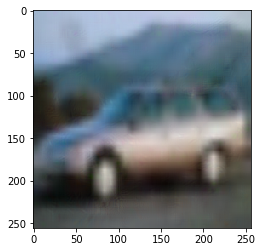

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


Parameter containing:
tensor([[-0.0065,  0.0022,  0.0023,  ...,  0.0005, -0.0057, -0.0049],
        [ 0.0069,  0.0014, -0.0089,  ...,  0.0089,  0.0059,  0.0013]],
       requires_grad=True)
Parameter containing:
tensor([-0.0044, -0.0080], requires_grad=True)
Poisoning
epoch: 1, Discriminator Loss: 1.2764921188354492
Train accuracy is: 69.375% 
Test accuracy is: 93.0% 
Poisoning
epoch: 2, Discriminator Loss: 1.193318247795105
Train accuracy is: 70.5% 
Test accuracy is: 93.5% 
Poisoning
epoch: 3, Discriminator Loss: 0.32045599818229675
Train accuracy is: 94.25% 
Test accuracy is: 94.0% 
Poisoning
epoch: 4, Discriminator Loss: 0.3136325776576996
Train accuracy is: 96.125% 
Test accuracy is: 96.0% 
Poisoning
epoch: 5, Discriminator Loss: 0.3136683702468872
Train accuracy is: 96.625% 
Test accuracy is: 95.5% 


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor([[0.7656, 0.2344]], grad_fn=<SoftmaxBackward>)
Target instance is predicted as Airplane


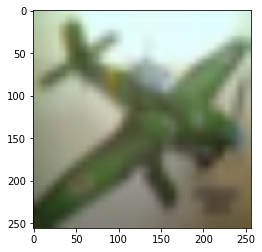

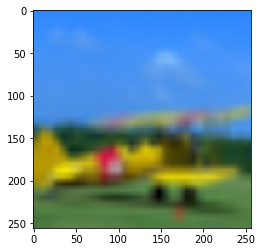

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(5305.1616, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(5042.2070, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4818.8237, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4625.9478, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4442.5684, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4283.5234, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4141.8452, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(4017.2905, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3904.0603, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3803.5354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3709.8799, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3619.1750, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3530.4128, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3448.1899, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3372.6604, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3307.0696, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3251.0159, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3199.3450, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3153.7476, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3110.2585, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3070.2229, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3034.2983, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3001.4751, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2971.3491, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2943.7957, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2918.0957, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2893.6384, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2870.1843, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2848.5933, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2828.0342, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2809.0312, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2791.1038, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2773.7205, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2756.8660, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2740.4260, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2724.3718, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2708.9490, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2694.1567, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2680.1318, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2666.5383, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2653.3535, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2640.5886, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2628.2515, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2616.0850, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2604.2158, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2593.0312, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2582.3105, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2571.7256, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2561.2849, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2550.6340, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2540.0879, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2529.7000, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2519.5728, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2509.4114, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2499.6765, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2490.4053, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2481.3992, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2472.4568, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2462.6521, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2453.0840, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2443.7141, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2434.7966, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2426.1802, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2417.8293, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2409.6758, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2401.6848, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2394.0349, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2386.3384, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2378.6213, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2370.2737, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2362.2605, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2354.6133, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2347.0452, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2339.6489, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2332.4827, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2325.4536, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2318.5247, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2311.7288, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2304.9148, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2298.3474, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2291.5171, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2284.3826, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2277.6121, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2270.6895, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2263.9041, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2257.3333, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2250.6990, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2244.0034, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2237.3245, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2230.7654, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2224.4106, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2218.2881, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2212.1533, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2206.3027, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2200.6067, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2194.8752, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2189.3875, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2184.0447, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2178.7554, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2173.7488, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2168.7488, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2163.8879, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2158.9858, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2154.1296, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2149.3699, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2144.5840, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2139.9060, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2135.1106, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2130.2627, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2125.2339, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2119.8665, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2114.4048, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2108.9651, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2103.4370, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2097.9558, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2092.6057, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2087.1895, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2082.0242, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2076.8984, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2072.1011, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2067.2632, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2062.4990, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2057.9138, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2053.4504, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2049.0432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2044.5242, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2040.2074, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2035.9138, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2031.7155, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2027.4878, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2023.3291, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2019.1512, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2015.1853, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2011.2496, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2007.0454, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2003.0500, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1999.0488, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1995.0629, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1991.2460, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1987.4041, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1983.7076, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1980.0405, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1976.3964, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1972.7899, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1969.2781, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1965.8124, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1962.4457, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1959.0059, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1955.6211, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1952.2014, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1948.7672, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1945.3973, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1942.0526, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1938.8252, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1935.5767, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1932.3979, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1929.2772, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1925.9691, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1922.7421, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1919.5586, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1916.4081, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1913.2952, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1910.1919, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1907.1171, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1903.9681, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1901.0454, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1898.1633, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1895.3032, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1892.5269, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1889.7882, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1887.1237, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1884.4171, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1881.7957, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1879.2985, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1876.7615, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1874.1996, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1871.7024, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1869.2755, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1866.8116, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1864.4041, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1862.0188, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1859.6393, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1857.2297, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1854.7396, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1852.2551, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1849.7766, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1847.3184, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1844.8638, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1842.4115, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1839.9700, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1837.6379, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1835.3202, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1833.0065, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1830.6538, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1828.3293, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1826.0032, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1823.7156, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1821.4102, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1819.1779, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1817.0106, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1814.7573, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1812.5709, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1810.3242, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1808.1548, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1805.9806, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1803.8928, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1801.7853, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1799.7433, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1797.6274, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1795.5304, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1793.4719, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1791.4064, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1789.3335, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1787.3477, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1785.2485, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1783.2350, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1781.1230, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1779.0546, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1777.0365, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1775.0392, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1772.9313, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1770.8875, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1768.9048, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1766.9027, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1764.9121, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1762.9597, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1761.0394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1759.1315, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1757.2732, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1755.4330, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1753.5786, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1751.7034, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1749.6976, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1747.7633, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1745.7985, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1743.8937, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1742.0411, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1740.1581, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1738.3619, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1736.5414, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1734.7540, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1732.9805, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1731.1721, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1729.4308, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1727.7185, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1726.0068, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1724.3296, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1722.6205, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1720.9806, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1719.3171, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1717.7073, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1716.0796, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1714.5024, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1712.8943, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1711.3044, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1709.7192, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1708.1237, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1706.5619, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1704.9357, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1703.3865, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1701.7617, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1700.1815, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1698.5857, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1697.0974, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1695.5166, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1694.0238, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1692.4233, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1690.8866, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1689.3406, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1687.8217, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1686.2573, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1684.7793, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1683.2427, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1681.7621, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1680.3157, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1678.8733, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1677.2432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1675.7609, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1674.2236, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1672.7543, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1671.3040, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1669.8723, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1668.4142, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1667.0074, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1665.6246, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1664.2263, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1662.7230, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1661.2742, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1659.8292, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1658.4509, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1657.0543, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1655.7036, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1654.3724, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1653.0442, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1651.7655, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1650.4452, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1649.1517, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1647.8668, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1646.5858, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1645.2830, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1643.9498, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1642.6298, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1641.4009, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1640.1350, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1638.8256, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1637.5582, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1636.2655, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1635.0560, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1633.7994, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1632.5695, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1631.3646, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1630.0941, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1628.9303, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1627.6622, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1626.3688, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1625.0610, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1623.8228, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1622.5779, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1621.3759, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1620.1227, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1618.9679, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1617.7175, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1616.5397, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1615.3053, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1614.1741, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1612.9524, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1611.7666, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1610.5422, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1609.3557, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1608.1409, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1606.9708, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1605.7733, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1604.5968, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1603.4580, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1602.3342, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1601.2167, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1600.0189, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1598.9296, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1597.7638, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1596.6704, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1595.5000, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1594.3894, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1593.2350, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1592.1577, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1591.0334, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1589.9716, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1588.8534, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1587.8512, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1586.7886, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1585.7609, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1584.6953, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1583.6367, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1582.5919, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1581.5404, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1580.4731, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1579.4767, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1578.4167, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1577.3749, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1576.4103, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1575.4171, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1574.4398, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1573.4307, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1572.4950, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1571.4799, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1570.5431, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1569.5624, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1568.6034, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1567.6898, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1566.7351, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1565.8114, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1564.8811, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1563.9578, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1563.0560, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1562.0946, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1561.1086, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1560.0848, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1558.8995, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1557.6826, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1556.4922, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1555.3065, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1554.2915, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1553.1737, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1552.1663, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1551.0942, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1549.9851, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1548.9222, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1547.8514, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1546.7806, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1545.7120, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1544.5928, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1543.5309, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1542.4514, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1541.4436, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1540.3739, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1539.3658, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1538.3698, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1537.3513, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1536.3568, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1535.4114, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1534.4316, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1533.4781, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1532.5619, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1531.6359, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1530.7328, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1529.8604, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1528.9614, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1528.0433, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1527.1792, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1526.2839, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1525.3875, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1524.5312, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1523.6859, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1522.8228, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1521.9556, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1521.1372, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1520.2958, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1519.4894, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1518.6569, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1517.8452, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1517.0559, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1516.2709, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1515.4463, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1514.6870, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1513.9296, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1513.1487, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1512.3834, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1511.6050, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1510.8243, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1510.0398, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1509.2740, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1508.4716, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1507.7122, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1506.9553, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1506.2008, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1505.4518, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1504.6956, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1503.9883, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1503.2576, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1502.5128, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1501.7526, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1501.0547, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1500.3435, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1499.6045, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1498.8630, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1498.1460, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1497.4043, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1496.6790, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1495.9574, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1495.2130, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1494.4731, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1493.7716, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1493.0493, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1492.3339, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1491.6414, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1490.9578, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1490.2432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1489.5974, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1488.8999, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1488.2396, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1487.5892, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1486.9316, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1486.2936, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1485.6228, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1484.9583, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1484.3453, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1483.6879, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1483.0708, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1482.4674, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1481.8314, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1481.2354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1480.6088, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1479.9601, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1479.3394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1478.7247, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1478.1024, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1477.4912, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1476.8864, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1476.2701, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1475.6545, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1475.0409, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1474.4198, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1473.8066, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1473.1753, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1472.5665, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1471.9281, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1471.3164, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1470.7212, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1470.1156, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1469.4950, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1468.8890, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1468.2870, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1467.7070, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1467.1018, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1466.5148, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1465.8951, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1465.2666, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1464.6694, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1464.0376, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1463.4478, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1462.8556, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1462.2610, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1461.6621, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1461.1016, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1460.5280, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1459.9108, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1459.3210, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1458.7458, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1458.1494, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1457.5575, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1457.0044, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1456.3844, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1455.7516, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1455.1528, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1454.5254, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1453.9283, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1453.3335, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1452.7109, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1452.0959, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1451.4631, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1450.8214, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1450.1729, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1449.5593, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1448.9342, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1448.3564, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1447.7566, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1447.1520, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1446.5524, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1445.9889, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1445.4038, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1444.8090, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1444.2334, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1443.6921, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1443.1055, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1442.5389, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1441.9849, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1441.3925, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1440.8214, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1440.2654, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1439.6829, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1439.1167, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1438.5371, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1437.9427, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1437.3622, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1436.7881, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1436.1924, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1435.6344, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1435.0795, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1434.5277, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1433.9655, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1433.4141, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1432.8569, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1432.2906, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1431.7795, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1431.2207, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1430.6326, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1430.1241, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1429.5778, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1429.0225, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1428.4749, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1427.9323, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1427.4119, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1426.8306, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1426.2621, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1425.7440, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1425.2125, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1424.6633, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1424.1306, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1423.5811, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1423.0537, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1422.5432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1422.0043, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1421.5328, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1420.9958, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1420.4684, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1419.9512, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1419.4420, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1418.9233, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1418.4045, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1417.8894, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1417.3621, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1416.8046, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1416.2788, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1415.7526, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1415.2167, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1414.6642, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1414.1498, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1413.6047, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1413.0905, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1412.5657, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1412.0708, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1411.5548, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1411.0317, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1410.4952, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1409.9718, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1409.4266, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1408.9080, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1408.3413, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1407.7837, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1407.2638, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1406.7393, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1406.2300, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1405.7113, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1405.2100, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1404.7175, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1404.2191, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1403.7557, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1403.2535, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1402.7698, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1402.2980, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1401.7966, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1401.3036, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1400.7916, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1400.2914, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1399.8081, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1399.3109, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1398.8073, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1398.3185, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1397.8344, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1397.3375, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1396.8612, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1396.3706, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1395.9014, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1395.4011, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1394.9674, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1394.4927, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1393.9979, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1393.5305, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1393.0289, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1392.5432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1392.0532, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1391.6135, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1391.1033, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1390.5857, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1390.1016, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1389.6091, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1389.1115, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1388.6219, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1388.1648, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1387.7080, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1387.2385, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1386.7848, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1386.3124, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1385.8462, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1385.3964, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1384.9707, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1384.5341, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1384.1194, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1383.6567, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1383.2195, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1382.7949, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1382.3550, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1381.9485, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1381.4746, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1381.0538, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1380.6099, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1380.1611, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1379.7284, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1379.2935, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1378.8424, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1378.3971, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1377.9835, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1377.5355, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1376.8840, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1376.2520, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1375.6101, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1375.0029, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1374.4309, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1373.8602, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1373.2949, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1372.6895, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1372.1377, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1371.6008, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1371.0341, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1370.4598, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1369.8535, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1369.2902, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1368.7101, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1368.1501, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1367.5841, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1367.0543, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1366.5131, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1365.9821, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1365.4243, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1364.9347, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1364.3817, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1363.8683, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1363.3739, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1362.8866, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1362.3579, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1361.8342, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1361.3202, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1360.8208, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1360.3002, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1359.7792, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1359.2981, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1358.8394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1358.3351, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1357.8906, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1357.3790, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1356.9071, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1356.4030, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1355.8961, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1355.3610, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1354.8810, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1354.3772, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1353.9020, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1353.3521, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1352.8225, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1352.3202, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1351.8441, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1351.3292, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1350.8589, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1350.3418, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1349.8942, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1349.4255, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1348.9785, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1348.4846, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1348.0013, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1347.5591, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1347.1174, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1346.6302, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1346.1755, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1345.7146, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1345.2606, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1344.7872, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1344.3212, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1343.8834, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1343.4359, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1342.9590, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1342.5300, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1342.0887, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1341.6486, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1341.2112, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1340.8112, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1340.3630, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1339.9263, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1339.5021, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1339.0900, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1338.6648, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1338.2578, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1337.8379, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1337.4178, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1337.0430, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1336.5894, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1336.1780, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1335.7642, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1335.3601, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1334.9353, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1334.5618, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1334.1504, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1333.7263, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1333.3409, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1332.9037, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1332.5060, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1332.0507, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1331.6366, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1331.1948, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1330.7959, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1330.3696, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1329.9619, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1329.5323, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1329.1373, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1328.7311, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1328.3320, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1327.9008, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1327.4818, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1327.0793, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1326.6738, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1326.2926, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1325.8970, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1325.5048, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1325.1095, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1324.7335, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1324.3386, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1323.9944, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1323.5955, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1323.2114, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1322.8290, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1322.4464, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1322.0813, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1321.7214, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1321.3257, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1320.9602, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1320.5912, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1320.2034, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1319.8424, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1319.4741, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1319.0858, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1318.7310, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1318.3574, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1317.9794, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1317.5823, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1317.2167, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1316.8326, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1316.4492, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1316.0791, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1315.7163, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1315.3076, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1314.9089, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1314.5703, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1314.1610, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1313.7906, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1313.3997, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1313.0773, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1312.7054, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1312.3694, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1311.9830, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1311.6522, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1311.2942, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1310.9583, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1310.5492, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1310.2410, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1309.8708, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1309.5645, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1309.2069, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1308.8445, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1308.5177, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1308.2003, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1307.8573, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1307.5208, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1307.1938, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1306.8695, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1306.5303, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1306.2000, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1305.9041, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1305.5846, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1305.2722, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1304.9525, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1304.6604, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1304.3470, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1304.1071, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1303.7806, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1303.4749, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1303.1691, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1302.9105, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1302.5864, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1302.3042, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1301.9980, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1301.6721, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1301.3892, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1301.1062, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1300.7852, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1300.5052, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1300.2200, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1299.9246, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1299.6154, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1299.3329, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1299.0172, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1298.7357, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1298.4445, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1298.1996, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1297.8878, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1297.5999, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1297.3335, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1297.0348, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1296.7551, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1296.4678, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1296.2043, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1295.9275, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1295.6658, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1295.3860, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1295.1160, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1294.8489, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1294.6029, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1294.3367, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1294.0720, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1293.7968, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1293.5216, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1293.2738, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1293.0148, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1292.7844, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1292.5016, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1292.2262, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1291.9294, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1291.6923, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1291.4102, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1291.1401, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1290.8816, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1290.6182, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1290.3547, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1290.0952, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1289.8336, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1289.6139, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1289.3416, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1289.1221, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1288.8745, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1288.6217, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1288.3539, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1288.0660, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1287.8182, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1287.5310, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1287.2983, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1287.0293, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1286.7937, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1286.5247, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1286.2792, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1285.9897, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1285.7438, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1285.4803, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1285.2295, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1284.9907, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1284.7334, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1284.5155, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1284.2511, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1284.0017, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1283.7502, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1283.5269, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1283.3014, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1283.0541, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1282.7953, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1282.5477, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1282.2852, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1282.0137, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1281.7495, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1281.5160, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1281.2529, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1281.0309, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1280.7500, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1280.5433, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1280.2555, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1280.0107, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1279.7533, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1279.5276, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1279.2866, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1279.0432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1278.7987, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1278.5505, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1278.3246, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1278.0707, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1277.8511, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1277.6360, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1277.3693, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1277.1321, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1276.9115, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1276.6816, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1276.4565, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1276.2061, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1275.9858, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1275.7356, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1275.5222, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1275.2618, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1275.0555, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1274.8107, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1274.5596, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1274.3370, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1274.1068, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1273.8634, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1273.6366, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1273.4027, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1273.1741, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1272.9685, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1272.7056, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1272.5360, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1272.2938, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1272.0756, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1271.8699, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1271.6354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1271.4297, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1271.1821, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1270.9585, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1270.7736, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1270.5649, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1270.3616, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1270.1451, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1269.9349, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1269.7307, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1269.5082, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1269.3221, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1269.1056, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1268.9219, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1268.6870, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1268.4691, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1268.2841, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1268.0828, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1267.8649, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1267.6931, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1267.4751, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1267.2659, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1267.0408, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1266.8616, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1266.6627, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1266.4874, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1266.2777, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1266.0739, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1265.8624, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1265.6592, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1265.4749, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1265.2750, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1265.0913, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1264.9025, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1264.7267, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1264.5603, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1264.3550, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1264.1344, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1263.9503, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1263.7859, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1263.5857, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1263.4147, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1263.2053, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1263.0260, grad_fn=<PowBackward0>)


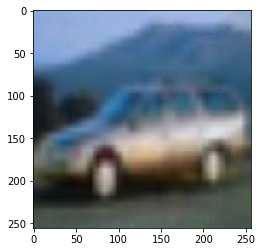

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


Parameter containing:
tensor([[ 0.0021,  0.0015, -0.0046,  ..., -0.0053,  0.0017,  0.0060],
        [-0.0016, -0.0009,  0.0027,  ..., -0.0013,  0.0079, -0.0007]],
       requires_grad=True)
Parameter containing:
tensor([-0.0080,  0.0026], requires_grad=True)
Poisoning
epoch: 1, Discriminator Loss: 1.3096224069595337
Train accuracy is: 70.125% 
Test accuracy is: 92.5% 
Poisoning
epoch: 2, Discriminator Loss: 1.3048384189605713
Train accuracy is: 69.375% 
Test accuracy is: 95.0% 
Poisoning
epoch: 3, Discriminator Loss: 1.2925747632980347
Train accuracy is: 71.875% 
Test accuracy is: 96.0% 
Poisoning
epoch: 4, Discriminator Loss: 0.7252047061920166
Train accuracy is: 96.25% 
Test accuracy is: 94.0% 
Poisoning
epoch: 5, Discriminator Loss: 0.31326374411582947
Train accuracy is: 92.875% 
Test accuracy is: 93.5% 


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor([[0.0023, 0.9977]], grad_fn=<SoftmaxBackward>)
Target instance is predicted as Automobile


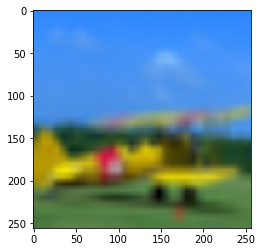

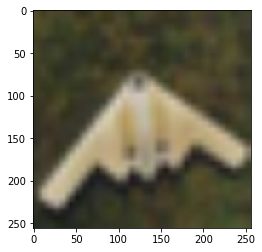

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3814.6262, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3664.5217, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3536.0432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3425.9348, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3327.1553, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3233.9060, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3151.2246, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3073.4463, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3005.0684, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2943.8879, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2886.1831, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2833.7085, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2785.9744, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2742.2864, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2701.6387, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2663.0034, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2627.0728, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2593.5852, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2562.1614, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2532.7620, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2504.7202, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2478.2344, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2452.5347, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2426.8574, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2401.1301, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2376.0613, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2352.2993, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2329.8533, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2308.6223, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2288.3872, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2268.4775, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2249.1985, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2230.9211, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2213.1863, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2196.0283, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2179.4221, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2163.5510, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2147.5320, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2132.1111, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2117.4097, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2103.4856, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2089.6892, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2076.0371, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2062.4573, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2049.0762, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2036.1858, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2023.4155, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2011.1111, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1999.1754, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1987.3490, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1975.8928, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1964.5616, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1953.5376, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1942.7611, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1931.9252, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1921.6372, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1911.4142, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1901.4222, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1891.5717, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1882.1534, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1872.7280, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1863.7130, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1854.9329, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1846.2040, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1837.7688, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1829.1156, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1820.4768, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1812.0665, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1803.6492, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1795.4667, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1787.5087, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1779.7205, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1772.1429, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1764.6041, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1757.4229, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1750.1183, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1743.1326, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1736.3217, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1729.5165, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1722.7089, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1716.0938, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1709.6018, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1703.3492, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1697.5143, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1691.7479, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1686.0935, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1680.5371, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1675.0997, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1669.7170, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1664.4849, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1658.6924, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1653.0718, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1647.5583, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1642.1818, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1636.9377, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1631.7474, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1626.8937, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1622.1234, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1617.5160, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1613.0149, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1608.5942, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1604.2925, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1600.0903, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1595.8971, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1591.7843, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1587.8394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1584.0448, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1579.9391, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1575.8402, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1571.8982, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1567.9270, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1564.1185, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1560.2609, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1556.5439, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1552.8466, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1549.2328, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1545.5500, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1541.8597, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1538.1840, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1534.5303, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1530.9373, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1527.4006, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1523.8042, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1520.3523, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1516.8817, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1513.4589, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1510.0419, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1506.7999, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1503.6412, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1500.4381, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1497.3689, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1494.3381, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1491.2762, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1488.1949, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1485.1885, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1482.2300, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1479.3326, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1476.5609, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1473.7528, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1471.0507, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1468.3987, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1465.7657, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1463.2157, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1460.6445, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1458.1517, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1455.6532, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1453.1692, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1450.7080, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1447.9211, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1445.1829, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1442.4019, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1439.6672, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1436.8800, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1434.2292, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1431.4891, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1428.8197, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1426.1819, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1423.5463, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1421.0217, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1418.5675, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1416.1097, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1413.7393, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1411.3790, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1409.0369, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1406.7802, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1404.5056, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1402.2645, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1400.0533, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1397.8604, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1395.6710, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1393.4573, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1391.2749, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1389.0896, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1387.0228, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1384.9437, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1382.9294, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1380.8752, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1378.8619, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1376.8456, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1374.8442, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1372.8016, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1370.8313, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1368.9189, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1366.9790, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1365.0677, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1363.1964, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1361.2667, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1359.3499, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1357.4091, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1355.5192, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1353.5527, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1351.6652, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1349.7668, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1347.9319, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1346.1101, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1344.3301, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1342.5100, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1340.7734, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1338.9512, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1337.1088, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1335.3529, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1333.6118, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1331.8774, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1330.1050, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1328.3721, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1326.6627, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1324.9838, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1323.3054, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1321.6294, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1319.9495, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1318.3547, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1316.6765, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1314.9861, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1313.3015, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1311.5936, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1309.9689, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1308.2881, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1306.6814, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1305.0573, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1303.4803, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1301.9047, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1300.3834, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1298.8258, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1297.3110, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1295.8226, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1294.3652, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1292.8348, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1291.3684, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1289.8865, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1288.4464, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1287.0427, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1285.6274, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1284.1940, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1282.7543, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1281.3322, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1279.9865, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1278.5786, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1277.1860, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1275.8337, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1274.4720, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1273.0123, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1271.5991, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1270.1995, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1268.8047, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1267.4248, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1266.0845, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1264.7424, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1263.4556, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1262.1764, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1260.8979, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1259.6288, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1258.3702, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1257.0807, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1255.8348, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1254.6041, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1253.3676, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1252.1443, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1250.9073, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1249.7087, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1248.5300, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1247.3596, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1246.1987, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1244.9980, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1243.7716, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1242.6443, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1241.4534, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1240.3319, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1239.2222, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1238.0950, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1236.8668, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1235.7272, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1234.5424, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1233.3802, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1232.2375, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1231.1194, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1230.0089, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1228.8883, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1227.8153, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1226.7227, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1225.6348, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1224.5250, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1223.4685, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1222.4189, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1221.3866, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1220.3549, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1219.3237, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1218.2635, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1217.2058, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1216.1332, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1215.1215, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1214.0941, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1213.0504, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1212.0599, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1211.0853, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1210.0862, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1209.0652, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1208.0780, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1207.1208, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1206.1366, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1205.1577, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1204.2081, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1203.2283, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1202.2561, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1201.3058, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1200.3308, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1199.3712, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1198.4222, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1197.4933, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1196.5436, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1195.6304, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1194.6982, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1193.8140, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1192.9176, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1192.0128, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1191.1301, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1190.2511, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1189.3652, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1188.5100, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1187.6324, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1186.7726, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1185.9252, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1185.0947, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1184.2395, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1183.3859, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1182.5632, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1181.7560, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1180.9392, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1180.1241, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1179.2726, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1178.4814, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1177.6715, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1176.8762, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1176.0812, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1175.2860, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1174.4811, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1173.6455, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1172.8676, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1172.1222, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1171.3181, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1170.5037, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1169.7053, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1168.9143, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1168.1219, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1167.3716, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1166.5535, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1165.7915, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1165.0221, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1164.2371, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1163.4591, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1162.6952, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1161.9609, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1161.1957, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1160.4176, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1159.6249, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1158.8292, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1158.0974, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1157.3319, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1156.5801, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1155.8444, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1155.1221, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1154.3876, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1153.6948, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1152.9839, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1152.2855, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1151.5869, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1150.9089, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1150.1877, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1149.5212, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1148.8550, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1148.1797, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1147.4971, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1146.8546, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1146.1548, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1145.5168, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1144.8593, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1144.2246, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1143.5690, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1142.9235, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1142.3022, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1141.6672, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1141.0251, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1140.4274, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1139.7859, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1139.1760, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1138.5566, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1137.9595, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1137.3411, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1136.7053, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1136.0996, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1135.4681, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1134.8734, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1134.2507, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1133.6467, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1133.0498, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1132.4355, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1131.8115, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1131.1830, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1130.5596, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1129.9561, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1129.3750, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1128.7402, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1128.1469, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1127.5514, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1126.9709, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1126.3717, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1125.7986, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1125.2159, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1124.6454, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1124.0781, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1123.5493, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1122.9343, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1122.3829, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1121.8184, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1121.2761, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1120.7208, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1120.1823, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1119.6525, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1119.1238, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1118.5713, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1118.0626, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1117.5067, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1116.9880, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1116.4247, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1115.8975, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1115.3629, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1114.8403, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1114.3159, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1113.7926, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1113.2987, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1112.7794, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1112.2646, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1111.7423, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1111.2283, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1110.7219, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1110.1945, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1109.6794, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1109.1654, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1108.6398, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1108.1193, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1107.5967, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1107.0851, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1106.5840, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1106.0585, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1105.5651, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1105.0460, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1104.5361, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1104.0140, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1103.4978, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1103.0310, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1102.5288, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1102.0496, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1101.5758, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1101.0806, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1100.5857, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1100.1190, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1099.6056, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1099.1583, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1098.7089, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1098.2163, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1097.7451, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1097.2524, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1096.7600, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1096.2825, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1095.7791, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1095.3097, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1094.7581, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1094.2570, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1093.7521, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1093.2876, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1092.7646, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1092.1547, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1091.5739, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1091.0211, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1090.4663, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1089.8922, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1089.3168, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1088.7725, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1088.1842, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1087.6542, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1087.1211, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1086.5582, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1085.9768, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1085.4108, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1084.7982, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1084.2037, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1083.6105, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1083.0204, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1082.4478, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1081.8462, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1081.2583, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1080.6821, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1080.1309, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1079.5660, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1079.0497, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1078.4484, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1077.8977, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1077.3567, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1076.8221, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1076.2814, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1075.7476, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1075.2257, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1074.7131, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1074.1930, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1073.6687, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1073.1415, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1072.6317, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1072.1300, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1071.6360, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1071.1071, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1070.5907, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1070.0718, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1069.5503, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1069.0765, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1068.5532, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1068.0829, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1067.6105, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1067.0945, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1066.6071, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1066.0978, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1065.5967, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1065.1221, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1064.6132, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1064.0909, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1063.5908, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1063.0718, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1062.5719, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1062.0581, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1061.5410, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1061.0171, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1060.4896, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1059.9679, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1059.4431, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1058.9304, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1058.4098, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1057.9377, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1057.4343, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1056.9310, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1056.4082, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1055.9753, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1055.4614, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1054.9868, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1054.5056, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1054.0255, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1053.5552, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1053.1152, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1052.6349, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1052.1897, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1051.7294, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1051.2443, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1050.8134, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1050.3638, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1049.8859, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1049.4565, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1048.9902, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1048.5764, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1048.1293, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1047.7139, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1047.2654, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1046.8307, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1046.4346, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1046.0165, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1045.6123, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1045.1913, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1044.7932, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1044.3679, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1043.9722, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1043.5941, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1043.1643, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1042.7642, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1042.3695, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1041.9390, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1041.5841, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1041.1824, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1040.8412, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1040.3989, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1040.0667, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1039.6418, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1039.3051, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1038.9103, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1038.5521, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1038.1633, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1037.8041, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1037.4272, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1037.0936, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1036.7297, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1036.3696, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1036.0201, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1035.6740, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1035.3212, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1034.9763, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1034.5991, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1034.2931, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1033.9088, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1033.5258, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1033.1449, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1032.7883, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1032.3988, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1032.0455, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1031.6740, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1031.2964, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1030.9764, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1030.5924, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1030.2388, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1029.8971, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1029.5428, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1029.1860, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1028.8105, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1028.4846, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1028.1318, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1027.7867, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1027.4417, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1027.1421, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1026.7908, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1026.4604, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1026.1146, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1025.7981, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1025.4377, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1025.1281, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1024.7924, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1024.5038, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1024.1704, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1023.8575, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1023.5311, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1023.2528, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1022.9136, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1022.6193, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1022.2985, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1022.0028, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1021.6759, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1021.3819, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1021.0446, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1020.7646, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1020.4600, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1020.1553, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1019.8559, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1019.5773, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1019.2381, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.9747, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.6461, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.3583, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.0604, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1017.7737, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1017.4828, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1017.1708, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.8863, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.6077, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.3048, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.0279, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1015.7400, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1015.4604, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1015.1728, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1014.8702, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1014.5930, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1014.3240, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1014.0454, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1013.7999, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1013.5023, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1013.2319, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1012.9726, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1012.7318, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1012.4271, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1012.1636, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.8677, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.6493, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.3566, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.0859, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1010.8223, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1010.5718, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1010.2667, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1009.9789, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1009.7265, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1009.4670, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1009.2137, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1008.9414, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1008.6870, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1008.4296, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1008.1620, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1007.9049, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1007.6595, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1007.4236, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1007.1481, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1006.9110, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1006.6479, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1006.4051, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1006.1804, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1005.9061, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1005.6840, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1005.4389, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1005.1895, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1004.9423, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1004.7070, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1004.4841, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1004.2361, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1004.0233, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1003.7643, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1003.5481, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1003.2983, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1003.0951, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1002.8439, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1002.6562, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1002.4017, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1002.1401, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1001.9270, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1001.7237, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1001.4704, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1001.2699, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1000.9991, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1000.8092, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1000.5648, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1000.3340, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1000.1163, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(999.9075, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(999.6638, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(999.4408, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(999.2126, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(998.9990, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(998.7845, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(998.5457, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(998.3193, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(998.0876, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(997.8780, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(997.6368, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(997.4272, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(997.1835, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(996.9655, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(996.7325, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(996.4857, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(996.2335, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(996.0109, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(995.7693, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(995.5097, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(995.2929, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(995.0442, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(994.8250, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(994.5637, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(994.3511, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(994.0909, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(993.8446, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(993.5837, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(993.3452, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(993.1062, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(992.8657, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(992.6140, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(992.3557, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(992.1133, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(991.8729, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(991.6183, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(991.4058, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(991.1544, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(990.9286, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(990.6873, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(990.4623, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(990.2240, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(990.0140, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(989.7770, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(989.5299, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(989.3018, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(989.0483, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(988.8402, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(988.5818, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(988.3447, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(988.0695, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(987.8670, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(987.5878, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(987.3737, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(987.1180, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(986.8933, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(986.6368, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(986.3839, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(986.1337, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(985.9293, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(985.6462, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(985.4188, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(985.2074, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(984.9614, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(984.7274, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(984.4584, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(984.1602, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(983.8519, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(983.5635, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(983.2652, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(983.0098, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(982.7351, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(982.4529, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(982.2007, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(981.9561, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(981.6689, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(981.3874, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(981.1293, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(980.8694, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(980.6048, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(980.3692, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(980.0908, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(979.8479, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(979.5814, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(979.3345, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(979.0528, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(978.8367, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(978.5692, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(978.3599, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(978.1141, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(977.8560, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(977.6338, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(977.3940, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(977.1310, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(976.8928, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(976.6249, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(976.4091, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(976.1552, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(975.9003, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(975.6481, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(975.4116, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(975.1830, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(974.9338, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(974.6915, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(974.4606, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(974.2073, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(973.9954, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(973.7516, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(973.5109, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(973.2562, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(973.0504, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(972.8206, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(972.5886, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(972.3577, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(972.1284, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(971.8859, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(971.6656, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(971.4404, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(971.2026, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(971.0213, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(970.7626, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(970.5330, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(970.3085, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(970.0857, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(969.8611, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(969.6339, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(969.4341, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(969.2127, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(969.0169, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(968.7797, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(968.5598, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(968.3432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(968.1133, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(967.9009, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(967.6880, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(967.4825, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(967.2705, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(967.0574, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(966.8381, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(966.6475, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(966.4404, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(966.2169, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(965.9988, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(965.8121, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(965.5688, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(965.3580, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(965.1398, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(964.9508, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(964.7110, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(964.5215, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(964.2798, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(964.0872, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(963.8601, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(963.6518, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(963.4446, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(963.2291, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(963.0282, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(962.8033, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(962.5880, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(962.3757, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(962.1871, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(961.9758, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(961.7549, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(961.5367, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(961.3531, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(961.1160, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(960.8971, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(960.6888, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(960.4891, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(960.2733, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(960.0891, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(959.8649, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(959.6598, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(959.4623, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(959.2634, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(959.0909, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(958.8564, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(958.6608, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(958.4465, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(958.2536, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(958.0316, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(957.8422, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(957.6472, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(957.4686, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(957.2775, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(957.0997, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(956.8901, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(956.6915, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(956.5127, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(956.3132, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(956.1214, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(955.9252, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(955.6776, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(955.4594, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(955.2078, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(954.9771, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(954.7194, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(954.4761, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(954.2255, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(953.9999, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(953.7640, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(953.5294, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(953.2993, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(953.0662, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(952.8322, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(952.6242, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(952.3864, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(952.1885, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(951.9642, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(951.7383, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(951.5100, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(951.3145, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(951.0976, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(950.8931, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(950.6519, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(950.4607, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(950.2445, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(950.0710, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(949.8293, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(949.6221, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(949.4526, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(949.2377, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(949.0563, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(948.8267, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(948.6247, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(948.4539, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(948.2477, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(948.0728, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(947.8723, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(947.6727, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(947.4775, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(947.2784, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(947.0803, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(946.8886, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(946.7002, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(946.5153, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(946.3008, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(946.1194, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(945.9378, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(945.7536, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(945.5524, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(945.3918, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(945.1676, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(945.0156, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(944.8297, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(944.6328, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(944.4323, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(944.2802, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(944.0695, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(943.8967, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(943.7126, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(943.5309, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(943.3622, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(943.1502, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(942.9865, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(942.7932, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(942.5847, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(942.4021, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(942.1985, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(942.0298, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(941.8202, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(941.6508, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(941.4570, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(941.2575, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(941.1022, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(940.9482, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(940.7391, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(940.5750, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(940.3765, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(940.1875, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(940.0113, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(939.8430, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(939.6645, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(939.5031, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(939.3068, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(939.1758, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(938.9951, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(938.8125, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(938.6339, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(938.4556, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(938.2728, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(938.1217, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(937.9573, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(937.7825, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(937.6127, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(937.4667, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(937.2887, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(937.1406, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(936.9769, grad_fn=<PowBackward0>)


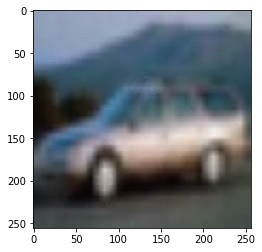

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


Parameter containing:
tensor([[ 0.0062,  0.0076, -0.0005,  ..., -0.0034, -0.0062,  0.0054],
        [-0.0081,  0.0060,  0.0044,  ..., -0.0056,  0.0081, -0.0058]],
       requires_grad=True)
Parameter containing:
tensor([-0.0072, -0.0068], requires_grad=True)
Poisoning
epoch: 1, Discriminator Loss: 1.198447346687317
Train accuracy is: 70.5% 
Test accuracy is: 95.0% 
Poisoning
epoch: 2, Discriminator Loss: 0.32939422130584717
Train accuracy is: 95.875% 
Test accuracy is: 94.0% 
Poisoning
epoch: 3, Discriminator Loss: 0.3168027698993683
Train accuracy is: 95.25% 
Test accuracy is: 94.0% 
Poisoning
epoch: 4, Discriminator Loss: 0.31489792466163635
Train accuracy is: 96.625% 
Test accuracy is: 95.5% 
Poisoning
epoch: 5, Discriminator Loss: 0.3156774640083313
Train accuracy is: 96.125% 
Test accuracy is: 95.5% 


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor([[0.7551, 0.2449]], grad_fn=<SoftmaxBackward>)
Target instance is predicted as Airplane


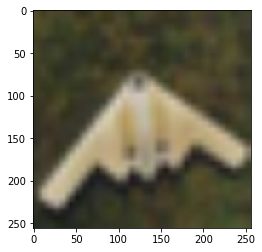

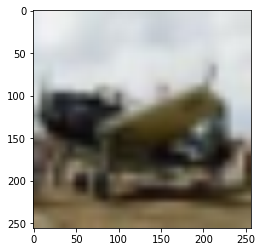

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3808.1743, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3699.2825, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3608.6394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3531.1189, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3461.9956, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3399.3191, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3342.5083, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3287.3643, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3237.4377, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3191.5613, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3148.9631, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3108.1650, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3066.8994, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3028.4351, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2992.5442, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2959.2058, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2927.6648, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2897.5952, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2869.0071, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2842.4009, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2817.5881, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2793.2898, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2770.0579, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2747.7634, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2725.7275, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2704.0779, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2683.7209, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2664.4771, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2645.9050, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2627.6492, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2610.3784, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2593.7043, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2577.5952, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2562.1697, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2547.2637, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2532.4199, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2518.3184, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2504.6035, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2491.4792, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2478.4866, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2465.7288, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2452.8088, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2440.3054, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2428.1528, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2416.3787, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2405.0430, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2394.1079, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2383.4346, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2372.8245, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2362.5835, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2352.4502, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2342.4783, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2332.7258, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2323.1990, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2313.6201, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2304.3198, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2295.1619, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2286.0789, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2277.0430, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2268.1294, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2259.0420, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2250.1963, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2241.7976, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2233.6877, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2225.7559, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2218.0264, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2210.3606, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2202.9702, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2195.7253, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2188.8750, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2181.8198, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2175.1636, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2168.5076, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2161.9675, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2155.5229, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2149.1855, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2142.9241, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2136.6816, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2130.0815, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2123.5442, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2117.2688, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2111.1743, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2105.0884, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2099.1384, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2093.4050, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2087.7061, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2081.8550, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2076.0515, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2070.4634, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2065.0503, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2059.7620, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2054.5740, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2049.3931, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2044.3911, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2039.2758, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2034.3491, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2029.4038, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2024.6564, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2019.8054, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2015.0760, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2010.3523, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2005.6354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2001.0739, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1996.5029, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1992.0281, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1987.6272, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1983.3727, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1979.1410, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1975.0142, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1970.9885, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1966.9738, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1962.9404, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1959.0714, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1955.3097, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1951.4623, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1947.7634, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1944.0367, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1940.1732, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1936.4277, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1932.7461, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1929.1981, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1925.5918, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1922.0436, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1918.5205, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1915.0306, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1911.5659, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1907.4043, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1902.5912, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1897.6741, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1892.9158, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1888.3478, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1883.7137, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1879.2766, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1875.0525, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1870.9713, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1867.0747, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1863.1952, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1859.2903, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1854.8169, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1850.2614, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1845.2240, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1840.1526, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1835.4568, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1830.9453, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1826.4293, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1822.0419, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1817.8101, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1813.7284, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1809.8077, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1806.0779, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1802.3096, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1798.6478, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1795.0752, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1791.5442, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1787.9531, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1784.3121, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1780.5922, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1776.9285, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1773.1564, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1769.0787, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1765.0531, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1761.0317, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1757.1587, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1753.2872, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1749.7050, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1746.1221, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1742.5905, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1739.0768, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1735.6659, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1732.2192, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1728.7631, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1725.4126, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1722.1747, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1718.6099, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1715.3230, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1712.1854, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1709.0070, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1705.7653, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1702.6544, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1699.4823, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1696.1201, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1692.5978, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1689.0073, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1685.5065, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1682.0077, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1678.6929, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1675.3398, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1672.1278, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1668.8785, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1665.6383, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1662.3335, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1659.2075, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1656.0870, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1652.8193, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1649.6158, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1646.5151, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1643.4873, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1640.3739, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1636.9285, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1633.7023, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1630.3790, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1627.1543, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1624.1699, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1621.1595, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1618.0852, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1615.1986, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1612.3195, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1609.4971, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1606.6539, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1603.9459, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1601.2255, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1598.6068, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1596.0016, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1593.4022, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1590.8859, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1588.3134, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1585.7311, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1583.3701, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1580.9481, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1578.5114, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1576.1782, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1573.7869, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1571.4684, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1569.1320, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1566.8552, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1564.5917, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1562.2972, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1560.0571, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1557.8196, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1555.7190, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1553.6000, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1551.4705, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1549.3992, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1547.3665, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1545.3527, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1543.3115, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1541.3167, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1539.3883, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1537.4282, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1535.5242, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1533.6212, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1531.6290, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1529.7911, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1527.7836, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1525.8760, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1523.8783, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1521.8181, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1519.8101, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1517.7778, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1515.6866, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1513.6693, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1511.7330, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1509.8163, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1507.8955, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1506.0433, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1504.1279, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1502.3336, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1500.5598, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1498.6989, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1496.7903, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1494.8384, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1492.8724, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1490.9296, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1488.9506, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1486.9858, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1485.1085, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1483.1984, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1481.2606, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1479.3813, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1477.5673, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1475.6903, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1473.8696, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1472.0479, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1470.2557, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1468.5378, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1466.7742, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1465.0336, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1463.2688, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1461.4915, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1459.7513, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1457.9738, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1456.2805, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1454.6072, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1452.8307, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1451.0911, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1449.3496, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1447.6637, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1446.0015, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1444.3810, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1442.7166, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1441.0667, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1439.4661, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1437.8549, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1436.2494, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1434.7327, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1433.1809, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1431.6537, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1430.0916, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1428.6150, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1427.1239, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1425.6389, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1424.1401, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1422.7170, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1421.3174, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1419.9558, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1418.5081, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1417.1415, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1415.8048, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1414.4198, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1413.1581, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1411.8234, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1410.5248, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1409.2562, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1407.9574, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1406.7639, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1405.5145, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1404.2758, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1403.0543, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1401.9058, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1400.7219, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1399.5415, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1398.3518, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1397.1903, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1396.0690, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1394.8965, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1393.8090, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1392.6571, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1391.5219, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1390.4489, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1389.3308, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1388.2245, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1387.1112, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1386.0245, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1384.9613, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1383.8926, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1382.8512, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1381.7523, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1380.6729, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1379.6201, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1378.5936, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1377.4653, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1376.4108, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1375.3761, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1374.3549, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1373.3007, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1372.3036, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1371.3036, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1370.3008, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1369.2606, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1368.2786, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1367.3093, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1366.3323, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1365.3265, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1364.3645, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1363.3955, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1362.3542, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1361.3821, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1360.3925, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1359.4277, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1358.4597, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1357.5184, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1356.5704, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1355.6230, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1354.6350, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1353.6506, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1352.6884, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1351.7521, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1350.7728, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1349.8193, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1348.8892, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1347.9341, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1347.0194, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1346.1311, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1345.2294, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1344.3394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1343.4326, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1342.5469, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1341.6644, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1340.7827, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1339.9185, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1339.1321, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1338.2640, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1337.3766, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1336.5450, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1335.7086, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1334.8993, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1334.0568, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1333.2299, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1332.3895, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1331.5873, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1330.7411, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1329.9327, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1329.0723, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1328.2905, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1327.4727, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1326.6205, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1325.7676, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1324.9390, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1324.1216, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1323.3141, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1322.4392, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1321.5670, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1320.7126, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1319.8928, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1319.0323, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1318.2400, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1317.4349, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1316.6466, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1315.8148, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1315.0479, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1314.2622, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1313.4705, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1312.6906, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1311.9617, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1311.1591, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1310.4224, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1309.6340, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1308.8467, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1308.0789, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1307.2854, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1306.5695, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1305.8145, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1305.0901, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1304.3347, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1303.5693, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1302.8315, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1302.0693, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1301.3440, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1300.5513, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1299.8068, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1299.0741, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1298.3351, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1297.6229, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1296.9427, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1296.2192, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1295.4469, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1294.7405, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1293.9825, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1293.2802, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1292.5726, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1291.8354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1291.1256, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1290.3671, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1289.5952, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1288.8816, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1288.1257, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1287.4125, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1286.6692, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1285.9752, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1285.2167, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1284.5266, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1283.8158, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1283.1609, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1282.4590, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1281.7765, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1281.1011, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1280.4144, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1279.7361, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1279.1077, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1278.4589, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1277.8243, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1277.2059, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1276.4977, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1275.8539, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1275.2247, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1274.6410, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1273.9906, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1273.3398, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1272.7192, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1272.1066, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1271.4552, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1270.8704, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1270.2588, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1269.6305, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1269.0074, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1268.3962, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1267.7676, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1267.1958, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1266.5675, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1265.9441, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1265.3446, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1264.7917, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1264.1490, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1263.5861, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1262.9951, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1262.4191, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1261.8221, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1261.2843, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1260.6731, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1260.1417, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1259.5519, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1258.9730, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1258.3894, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1257.8550, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1257.2021, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1256.6853, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1256.0876, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1255.5277, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1254.9741, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1254.3982, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1253.8135, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1253.2725, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1252.7269, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1252.2156, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1251.6443, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1251.1140, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1250.5608, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1250.0339, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1249.4601, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1248.9315, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1248.3748, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1247.8145, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1247.2841, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1246.7631, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1246.2397, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1245.6763, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1245.1378, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1244.5951, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1244.0477, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1243.4938, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1242.9369, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1242.3778, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1241.8569, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1241.3300, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1240.7753, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1240.2384, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1239.7102, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1239.1692, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1238.6553, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1238.1277, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1237.6367, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1237.1172, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1236.5815, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1236.0791, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1235.5859, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1235.0847, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1234.5762, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1234.0454, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1233.5159, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1233.0269, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1232.5343, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1232.0431, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1231.5354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1231.0439, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1230.5675, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1230.0852, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1229.6232, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1229.1411, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1228.6666, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1228.1527, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1227.7450, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1227.2278, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1226.7676, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1226.3136, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1225.8427, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1225.3696, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1224.8905, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1224.3912, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1223.8870, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1223.4163, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1222.9213, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1222.4446, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1221.9697, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1221.5033, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1220.9930, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1220.5116, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1220.0327, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1219.5365, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1219.0153, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1218.5278, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1218.0399, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1217.5275, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1217.0299, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1216.5137, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1216.0381, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1215.5194, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1215.0574, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1214.5514, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1214.0790, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1213.5479, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1213.0990, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1212.6266, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1212.1713, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1211.6589, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1211.2109, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1210.7445, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1210.2781, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1209.8004, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1209.3413, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1208.8524, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1208.4709, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1208.0135, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1207.5211, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1207.0607, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1206.6438, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1206.1810, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1205.7521, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1205.2920, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1204.8396, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1204.3950, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1203.8969, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1203.4315, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1203.0271, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1202.5857, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1202.1143, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1201.6448, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1201.2389, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1200.8378, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1200.3533, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1199.9343, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1199.5046, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1199.1010, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1198.6650, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1198.2242, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1197.8329, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1197.3663, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1196.9944, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1196.5845, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1196.1349, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1195.7517, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1195.3813, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1194.9255, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1194.5239, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1194.1108, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1193.6837, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1193.2628, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1192.8480, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1192.4338, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1192.0305, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1191.6078, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1191.2183, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1190.8354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1190.4100, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1189.9973, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1189.6357, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1189.2142, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1188.8464, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1188.4731, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1188.0831, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1187.7316, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1187.3643, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1186.9850, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1186.5834, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1186.2299, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1185.8710, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1185.5074, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1185.1244, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1184.7804, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1184.4170, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1184.0513, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1183.6940, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1183.3538, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1182.9906, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1182.6642, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1182.2836, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1181.9587, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1181.6260, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1181.2832, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1180.9059, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1180.6005, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1180.2448, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1179.9500, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1179.6129, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1179.2705, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1178.9478, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1178.6108, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1178.2894, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1177.9598, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1177.6317, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1177.3175, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1176.9586, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1176.6221, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1176.2793, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1175.9703, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1175.6079, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1175.2781, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1174.8307, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1174.4481, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1174.0222, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1173.6680, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1173.2742, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1172.9271, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1172.5397, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1172.2301, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1171.8336, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1171.5072, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1171.1625, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1170.8069, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1170.4700, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1170.1189, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1169.8102, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1169.4540, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1169.1584, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1168.8230, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1168.4644, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1168.1681, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1167.8396, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1167.5304, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1167.2173, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1166.8944, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1166.5858, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1166.2645, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1165.9473, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1165.6370, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1165.3167, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1164.9419, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1164.6852, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1164.3357, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1164.0564, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1163.7201, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1163.4357, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1163.1278, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1162.8052, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1162.5121, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1162.2074, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1161.8948, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1161.5997, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1161.3066, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1161.0155, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1160.7316, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1160.3860, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1160.1432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1159.8264, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1159.5406, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1159.2152, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1158.9642, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1158.6581, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1158.3695, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1158.0759, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1157.7776, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1157.4951, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1157.2040, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1156.9343, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1156.6499, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1156.3523, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1156.0929, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1155.8033, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1155.5316, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1155.2789, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1154.9650, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1154.6873, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1154.4042, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1154.1458, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1153.8859, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1153.5847, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1153.2836, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1153.0149, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1152.6833, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1152.3920, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1152.1105, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1151.8253, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1151.5178, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1151.2386, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1150.8916, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1150.6074, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1150.3512, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1150.0640, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1149.7526, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1149.5021, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1149.1915, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1148.9331, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1148.6357, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1148.3707, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1148.0853, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1147.8568, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1147.6177, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1147.3114, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1147.0647, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1146.7942, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1146.5179, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1146.2806, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1146.0060, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1145.7159, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1145.4629, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1145.1544, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1144.9476, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1144.6841, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1144.4337, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1144.2009, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1143.8809, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1143.6541, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1143.3069, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1143.0741, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1142.8302, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1142.5245, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1142.2563, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1142.0052, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1141.7535, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1141.4832, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1141.1981, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1140.9004, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1140.6072, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1140.3383, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1140.0543, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1139.7740, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1139.5051, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1139.2570, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1138.9889, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1138.7085, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1138.4575, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1138.1887, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1137.9344, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1137.6964, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1137.4026, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1137.1337, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1136.8934, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1136.6655, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1136.4283, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1136.1748, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1135.9148, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1135.6615, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1135.3669, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1135.1160, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1134.8438, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1134.6053, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1134.3401, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1134.1133, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1133.8409, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1133.6053, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1133.3351, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1133.1204, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1132.8127, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1132.5386, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1132.2880, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1132.0387, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1131.8123, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1131.5420, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1131.2798, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1131.0596, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1130.7979, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1130.5449, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1130.2922, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1130.0847, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1129.8301, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1129.5798, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1129.3536, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1129.0835, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1128.8340, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1128.6067, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1128.3666, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1128.0941, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1127.8256, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1127.5917, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1127.3534, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1127.0942, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1126.8885, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1126.6002, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1126.3577, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1126.0640, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1125.8929, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1125.6160, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1125.3644, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1125.1599, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1124.9073, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1124.7008, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1124.4637, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1124.2404, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1123.9833, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1123.7432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1123.4945, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1123.2703, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1122.9855, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1122.7732, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1122.5540, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1122.2944, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1122.0806, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1121.8462, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1121.6477, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1121.3888, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1121.1697, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1120.8999, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1120.6738, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1120.3890, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1120.1672, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1119.9280, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1119.6990, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1119.4700, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1119.2152, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1118.9803, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1118.7856, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1118.5502, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1118.3511, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1118.1254, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1117.8738, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1117.6843, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1117.4785, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1117.2997, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1117.0796, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1116.8496, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1116.6431, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1116.4376, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1116.2446, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1116.0129, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1115.7744, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1115.6057, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1115.3667, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1115.1562, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1114.9603, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1114.7166, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1114.5431, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1114.3727, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1114.1331, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1113.8962, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1113.7183, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1113.5234, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1113.2933, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1113.0663, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1112.8953, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1112.6881, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1112.4924, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1112.2769, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1112.0342, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1111.8831, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1111.6797, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1111.4766, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1111.2725, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1111.0958, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1110.9109, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1110.6820, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1110.5021, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1110.3002, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1110.1245, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1109.8995, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1109.7280, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1109.5066, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1109.3638, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1109.1534, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1108.9636, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1108.8018, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1108.5792, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1108.3639, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1108.2015, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1108.0238, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1107.8518, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1107.6528, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1107.4479, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1107.3016, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1107.1001, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1106.9275, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1106.7587, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1106.5498, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1106.3818, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1106.2050, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1106.0024, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1105.8152, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1105.6771, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1105.4912, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1105.3051, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1105.1128, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1104.9424, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1104.8143, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1104.6071, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1104.4095, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1104.2791, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1104.0858, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1103.9196, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1103.7246, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1103.5535, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1103.4307, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1103.2294, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1103.0406, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1102.8989, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1102.7189, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1102.5441, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1102.3890, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1102.2034, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1102.0453, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1101.8502, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1101.6975, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1101.5570, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1101.3605, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1101.1949, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1101.0881, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1100.8552, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1100.6831, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1100.4897, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1100.3629, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1100.1561, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1100.0618, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1099.8965, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1099.7052, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1099.5216, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1099.3718, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1099.1935, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1099.0337, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1098.8513, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1098.7043, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1098.5612, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1098.3900, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1098.2097, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1098.0732, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1097.9521, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1097.7438, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1097.5863, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1097.4390, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1097.2845, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1097.1100, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1096.9662, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1096.8318, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1096.6927, grad_fn=<PowBackward0>)


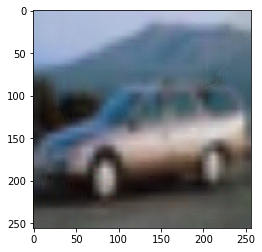

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


Parameter containing:
tensor([[-0.0069, -0.0019, -0.0013,  ..., -0.0003,  0.0056,  0.0012],
        [-0.0072, -0.0006,  0.0049,  ...,  0.0002, -0.0043,  0.0076]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0004, -0.0011], requires_grad=True)
Poisoning
epoch: 1, Discriminator Loss: 1.270147681236267
Train accuracy is: 68.25% 
Test accuracy is: 92.5% 
Poisoning
epoch: 2, Discriminator Loss: 0.6958352327346802
Train accuracy is: 95.375% 
Test accuracy is: 93.5% 
Poisoning
epoch: 3, Discriminator Loss: 0.31330418586730957
Train accuracy is: 94.25% 
Test accuracy is: 94.0% 
Poisoning
epoch: 4, Discriminator Loss: 0.3132632076740265
Train accuracy is: 95.875% 
Test accuracy is: 96.0% 
Poisoning
epoch: 5, Discriminator Loss: 0.3132646977901459
Train accuracy is: 96.125% 
Test accuracy is: 95.0% 


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor([[8.2362e-04, 9.9918e-01]], grad_fn=<SoftmaxBackward>)
Target instance is predicted as Automobile


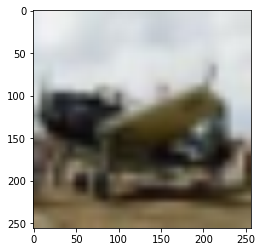

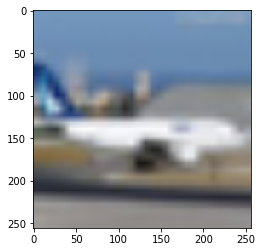

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3354.7144, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3165.1956, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(3008.0527, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2871.7527, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2751.1025, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2642.8684, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2544.3960, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2461.2620, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2384.7356, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2319.2451, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2263.0374, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2213.4563, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2165.7312, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2119.4094, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2077.0837, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2039.4758, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(2004.6053, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1971.5444, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1938.6838, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1908.9987, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1882.5729, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1858.5195, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1836.5579, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1815.9308, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1796.8002, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1778.7139, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1761.4265, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1744.5889, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1728.8090, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1713.5291, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1699.1558, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1684.8885, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1671.3794, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1658.6771, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1646.3121, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1634.8298, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1623.7511, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1613.2332, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1602.8788, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1592.8446, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1583.1398, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1573.7714, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1564.5320, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1555.6658, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1547.0795, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1538.9097, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1531.1122, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1523.6210, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1516.5947, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1509.6279, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1502.8304, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1496.1040, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1489.7196, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1483.4546, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1477.4282, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1471.4224, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1465.6536, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1460.0458, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1454.5184, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1449.1852, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1443.9968, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1439.0038, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1433.9958, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1429.0144, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1424.2651, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1419.4875, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1414.7931, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1410.2081, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1405.7562, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1401.3391, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1397.0236, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1392.6697, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1388.4417, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1384.2507, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1380.1733, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1376.1489, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1372.3044, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1368.4216, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1364.6018, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1360.7986, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1357.0813, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1353.4419, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1349.7047, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1345.9517, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1342.0907, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1338.3988, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1334.7432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1331.1678, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1327.6202, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1324.1599, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1320.6566, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1317.1248, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1313.6267, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1310.2178, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1306.8562, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1303.5437, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1300.1724, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1296.8348, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1293.5361, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1290.3080, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1287.0841, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1283.8500, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1280.7172, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1277.6422, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1274.5968, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1271.6239, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1268.6772, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1265.7755, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1262.9078, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1260.1300, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1257.3650, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1254.5182, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1251.7637, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1249.0437, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1246.3655, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1243.7189, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1241.1591, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1238.6010, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1236.0284, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1233.5228, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1231.0707, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1228.6276, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1226.2810, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1223.9526, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1221.6199, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1219.3394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1217.0669, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1214.8630, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1212.5793, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1210.2988, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1208.0581, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1205.8743, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1203.6737, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1201.5518, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1199.4399, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1197.3357, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1195.2609, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1193.1387, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1191.0566, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1189.0876, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1187.0646, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1185.0988, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1182.9232, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1180.8209, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1178.6863, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1176.5658, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1174.4250, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1172.3344, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1170.2040, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1168.1171, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1166.0587, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1164.0350, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1162.0162, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1160.0076, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1158.0764, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1156.1720, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1154.2826, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1152.4181, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1150.5127, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1148.6140, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1146.7417, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1144.8898, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1143.0342, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1141.2482, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1139.3417, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1137.4751, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1135.5571, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1133.7173, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1131.8949, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1130.0742, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1128.3040, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1126.5769, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1124.8835, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1123.2100, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1121.5344, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1119.8099, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1118.0942, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1116.4167, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1114.7878, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1113.1582, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1111.5569, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1110.0391, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1108.4911, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1106.9653, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1105.5123, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1104.0406, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1102.5757, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1101.1428, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1099.6992, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1098.2421, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1096.8115, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1095.3801, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1093.9763, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1092.5831, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1091.2046, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1089.8439, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1088.4796, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1087.1279, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1085.7672, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1084.4727, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1083.0736, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1081.6632, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1080.2894, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1078.9702, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1077.6367, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1076.3180, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1074.9795, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1073.6807, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1072.4111, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1071.0667, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1069.8036, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1068.4387, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1067.0780, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1065.6826, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1064.2836, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1062.8900, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1061.5355, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1060.1855, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1058.8412, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1057.5266, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1056.2277, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1054.9402, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1053.6912, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1052.4785, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1051.2474, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1050.0770, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1048.8805, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1047.7371, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1046.6012, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1045.4723, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1044.3405, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1043.1774, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1041.9690, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1040.8025, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1039.6221, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1038.4850, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1037.3074, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1036.1329, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1034.9873, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1033.8375, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1032.6899, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1031.5397, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1030.3551, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1029.2362, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1028.0897, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1026.9301, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1025.8197, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1024.6635, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1023.5309, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1022.3801, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1021.2142, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1020.0889, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1018.9442, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1017.8326, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1016.7535, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1015.6544, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1014.5917, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1013.5192, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1012.4404, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1011.3685, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1010.2781, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1009.1961, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1008.1089, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1006.9946, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1005.9005, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1004.8262, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1003.7328, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1002.6627, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1001.5805, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(1000.5354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(999.5170, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(998.5291, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(997.4728, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(996.4854, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(995.4842, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(994.4876, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(993.4897, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(992.5055, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(991.5367, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(990.5821, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(989.6307, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(988.7074, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(987.7731, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(986.8518, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(985.9487, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(985.0642, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(984.1808, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(983.2940, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(982.4310, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(981.5431, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(980.7175, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(979.8734, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(979.0276, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(978.1694, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(977.3867, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(976.5378, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(975.7354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(974.9142, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(974.1359, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(973.3331, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(972.5275, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(971.7332, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(970.9515, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(970.1882, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(969.4317, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(968.6611, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(967.8861, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(967.1436, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(966.3849, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(965.6588, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(964.9265, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(964.1785, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(963.4261, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(962.7171, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(961.9405, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(961.2203, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(960.4907, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(959.7835, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(959.0699, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(958.3806, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(957.6768, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(956.9350, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(956.2369, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(955.5198, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(954.7949, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(954.0704, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(953.3184, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(952.5877, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(951.8591, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(951.1275, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(950.3907, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(949.6721, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(948.9473, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(948.2130, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(947.4769, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(946.7513, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(946.0638, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(945.3496, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(944.6906, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(943.9681, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(943.3137, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(942.6614, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(941.9852, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(941.3333, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(940.6731, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(940.0469, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(939.3849, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(938.7441, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(938.0801, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(937.4529, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(936.8258, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(936.1738, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(935.5217, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(934.8627, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(934.2432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(933.6039, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(932.9700, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(932.3602, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(931.7615, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(931.1354, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(930.5353, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(929.9288, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(929.3079, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(928.6888, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(928.0848, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(927.4899, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(926.8723, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(926.2698, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(925.6656, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(925.0890, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(924.4763, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(923.9234, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(923.3215, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(922.7443, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(922.1848, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(921.5850, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(921.0187, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(920.4569, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(919.8951, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(919.3398, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(918.7515, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(918.1981, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(917.6373, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(917.0562, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(916.5276, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(915.9692, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(915.4070, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(914.8627, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(914.3081, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(913.7704, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(913.2512, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(912.7089, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(912.2055, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(911.6781, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(911.1363, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(910.6246, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(910.1448, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(909.6172, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(909.1259, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(908.5975, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(908.1199, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(907.5840, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(907.0787, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(906.5909, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(906.0672, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(905.5881, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(905.1094, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(904.5756, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(904.1212, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(903.6592, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(903.1883, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(902.7335, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(902.2770, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(901.7993, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(901.3616, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(900.9213, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(900.4551, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(899.9984, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(899.5992, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(899.1240, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(898.6855, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(898.2801, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(897.8249, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(897.3988, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(896.9683, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(896.5847, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(896.1448, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(895.7483, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(895.3365, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(894.9175, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(894.5176, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(894.1324, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(893.7245, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(893.3240, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(892.9038, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(892.4979, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(892.0849, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(891.6449, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(891.2352, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(890.8047, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(890.3754, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(889.9827, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(889.5504, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(889.1389, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(888.7077, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(888.2971, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(887.8573, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(887.4456, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(887.0396, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(886.6379, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(886.1966, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(885.8029, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(885.3721, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(884.9735, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(884.5697, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(884.1736, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(883.7831, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(883.3878, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(882.9792, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(882.6130, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(882.2082, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(881.7965, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(881.4042, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(881.0315, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(880.6229, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(880.2286, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(879.8248, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(879.4332, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(879.0569, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(878.6660, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(878.2832, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(877.9071, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(877.5349, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(877.1541, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(876.8036, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(876.4380, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(876.0566, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(875.6964, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(875.3298, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(874.9996, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(874.6202, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(874.2753, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(873.9376, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(873.5759, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(873.2347, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(872.8710, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(872.5293, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(872.1708, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(871.8112, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(871.4579, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(871.1007, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(870.7466, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(870.3612, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(870.0004, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(869.6180, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(869.2531, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(868.9001, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(868.5370, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(868.1905, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(867.8417, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(867.4869, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(867.1227, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(866.7495, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(866.3738, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(866.0112, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(865.6241, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(865.2394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(864.8555, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(864.4776, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(864.0878, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(863.7368, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(863.3417, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(862.9949, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(862.6299, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(862.2920, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(861.9103, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(861.5776, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(861.2067, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(860.8494, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(860.4911, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(860.1382, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(859.7920, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(859.4536, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(859.1227, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(858.7761, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(858.4348, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(858.0839, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(857.7616, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(857.4315, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(857.0767, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(856.7031, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(856.3170, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(855.9348, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(855.5780, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(855.2192, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(854.8625, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(854.5031, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(854.1364, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(853.7910, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(853.4373, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(853.0839, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(852.7737, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(852.4538, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(852.1355, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(851.7847, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(851.4471, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(851.1059, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(850.7783, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(850.4268, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(850.0646, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(849.7217, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(849.3763, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(849.0222, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(848.6895, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(848.3779, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(848.0046, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(847.6616, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(847.3204, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(846.9842, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(846.6657, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(846.3539, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(846.0297, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(845.6809, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(845.3519, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(845.0613, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(844.7371, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(844.4029, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(844.1005, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(843.8038, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(843.5040, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(843.2026, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(842.8733, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(842.5728, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(842.2609, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(841.9348, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(841.6573, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(841.3474, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(841.0455, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(840.7613, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(840.4831, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(840.1953, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(839.9086, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(839.6174, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(839.3293, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(839.0319, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(838.7423, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(838.4375, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(838.1895, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(837.8715, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(837.5614, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(837.2626, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(836.9693, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(836.6793, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(836.3641, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(836.1053, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(835.7975, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(835.5499, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(835.2206, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(834.9319, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(834.6259, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(834.3723, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(834.0649, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(833.7805, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(833.4991, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(833.2177, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(832.9275, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(832.6390, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(832.3470, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(832.0845, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(831.7936, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(831.5409, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(831.2587, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(830.9979, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(830.7178, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(830.4742, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(830.2019, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(829.9410, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(829.6773, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(829.4244, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(829.1567, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(828.9260, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(828.6697, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(828.4071, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(828.1561, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(827.9351, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(827.6694, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(827.4313, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(827.1740, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(826.9340, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(826.6894, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(826.4409, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(826.2009, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(825.9417, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(825.6907, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(825.4467, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(825.2057, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(824.9669, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(824.7324, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(824.4954, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(824.2290, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(824.0169, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(823.7823, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(823.5438, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(823.2944, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(823.0432, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(822.7775, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(822.5384, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(822.2838, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(822.0383, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(821.7946, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(821.5494, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(821.3074, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(821.0630, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(820.8215, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(820.5856, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(820.3598, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(820.1100, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(819.9027, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(819.6434, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(819.4411, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(819.1909, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(818.9733, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(818.7465, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(818.5401, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(818.3455, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(818.1037, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(817.8920, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(817.6620, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(817.4476, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(817.2179, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(816.9974, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(816.7876, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(816.5624, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(816.3411, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(816.1196, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(815.8860, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(815.6751, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(815.4576, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(815.2394, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(814.9813, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(814.7524, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(814.5235, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(814.2707, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(814.0530, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(813.8268, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(813.5887, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(813.3527, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(813.1275, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(812.9088, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(812.6759, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(812.4601, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(812.2477, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(812.0175, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(811.7842, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(811.5827, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(811.3609, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(811.1213, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(810.9214, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(810.7116, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(810.4959, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(810.2969, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(810.0983, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(809.8732, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(809.6595, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(809.4733, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(809.2492, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(809.0521, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(808.8588, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(808.6562, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(808.4353, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(808.2208, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(808.0085, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(807.8231, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(807.6110, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(807.3912, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(807.1974, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(807.0249, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(806.8063, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(806.6071, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(806.4317, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(806.2179, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(806.0262, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(805.8453, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(805.6449, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(805.4586, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(805.2581, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(805.0837, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(804.8744, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(804.6796, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(804.4951, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(804.3196, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(804.1227, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(803.9275, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(803.7416, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(803.5854, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(803.3943, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(803.1962, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(803.0257, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(802.8279, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(802.6378, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(802.4655, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(802.2940, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(802.1212, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(801.9313, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(801.7531, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(801.5901, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(801.4212, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(801.2338, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(801.0517, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(800.8860, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(800.7088, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(800.5290, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(800.3482, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(800.1846, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(800.0123, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(799.8288, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(799.6841, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(799.5005, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(799.3170, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(799.1528, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(798.9966, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(798.8109, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(798.6512, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(798.4806, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(798.3104, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(798.1515, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(797.9831, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(797.8362, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(797.6448, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(797.4893, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(797.3464, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(797.1700, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(797.0162, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(796.8569, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(796.6810, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(796.5104, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(796.3582, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(796.1841, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(796.0095, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(795.8492, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(795.6951, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(795.5087, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(795.3607, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(795.1844, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(795.0071, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(794.8523, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(794.7094, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(794.5552, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(794.3931, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(794.2004, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(794.0589, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(793.8808, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(793.7496, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(793.5835, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(793.4305, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(793.2521, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(793.1094, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(792.9524, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(792.7928, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(792.6321, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(792.4874, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(792.3154, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(792.1685, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(791.9971, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(791.8538, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(791.6957, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(791.5443, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(791.3865, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(791.2292, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(791.0690, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(790.9103, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(790.7412, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(790.5999, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(790.4366, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(790.2904, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(790.1213, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(789.9755, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(789.7817, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(789.6241, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(789.4259, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(789.2660, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(789.0838, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(788.9240, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(788.7460, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(788.5742, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(788.4141, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(788.2465, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(788.0825, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(787.9230, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(787.7589, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(787.6229, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(787.4285, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(787.2750, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(787.1050, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(786.9370, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(786.7700, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(786.6057, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(786.4463, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(786.2976, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(786.1120, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(785.9922, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(785.7853, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(785.6443, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(785.4793, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor(785.3405, grad_fn=<PowBackward0>)


Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/glitchinthematrix/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-531-9bffe0528670>", line 13, in <module>
    mod = forward(mod,test_img,lr)
  File "<ipython-input-512-5edc86e9dbcc>", line 7, in forward
    cnn = CNN()
  File "<ipython-input-487-a25d62e7e065>", line 36, in __init__
    self.alex_net = torch.hub.load('pytorch/vision', 'alexnet', pretrained=True)
  File "/home/glitchinthematrix/anaconda3/lib/python3.7/site-packages/torch/hub.py", line 363, in load
    model = entry(*args, **kwargs)
  File "/home/glitchinthematrix/anaconda3/lib/python3.7/site-packages/torchvision/models/alexnet.py", line 63, in alexnet
    progress=progress)
  File "/home/glitchinthematrix/anaconda3/lib/python3.7/site-packages/torch/hub.py", line 463, in load_state_dict_from_url
    return torch.load(cached_file, map_location=map_loc

TypeError: can only concatenate str (not "list") to str

In [530]:
#Transfer Learned model poison
success = []
j=0
for test_img in next(iter(testloader))[0]:
    if next(iter(testloader))[1][j] == 0 :
        imshow(test_img)
        poison_batch = torch.FloatTensor(n,3,256,256)
        count = 0
        for base_img in next(iter(trainloader_poison))[0]:
            
            mod = base_img
            for i in range(niters):
                mod = forward(mod,test_img,lr)
                mod = backward(mod,base_img,beta,lr)
            
            mod=(1-op)*mod+op*test_img
            imshow(mod)
            poison_batch[count,:,:,:] = mod
            count+=1
        #Train final layer on poison
        poison_label = next(iter(trainloader_poison))[1]
        #print(poison_label)
        train_with_poison_final_layer(poison_batch,poison_label)
        #Load model
        cnn = CNN()
        PATH = "./weights_cnn_poisoned_transfer/weights"
        cnn.load_state_dict(torch.load(PATH))
        #Test target instance
        output = F.softmax(cnn(test_img.reshape(-1,3,256,256)),dim=1)
        print(output)
        _, predicted = torch.max(output.data, 1)
        if predicted.item() == 1:
            success.append(mod)
        print("Target instance is predicted as {}".format(class_name(predicted.item())))
        imshow(test_img)   
    j=j+1
    

In [519]:
cnn=CNN()
PATH = "./weights_cnn_poisoned_transfer/weights"
cnn.load_state_dict(torch.load(PATH))
#Test target instance
output = F.softmax(cnn(poison_batch),dim=1)
print(output)
_, predicted = torch.max(output.data, 1)
print(predicted)

Using cache found in /home/glitchinthematrix/.cache/torch/hub/pytorch_vision_master


tensor([[9.9980e-01, 2.0375e-04]], grad_fn=<SoftmaxBackward>)
tensor([0])


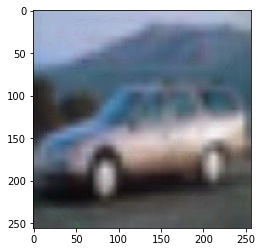

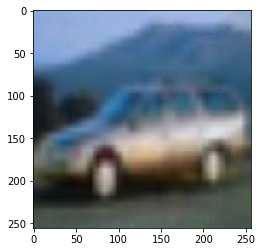

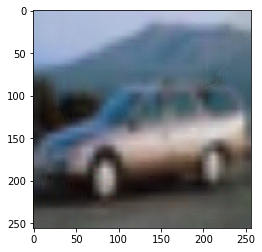

In [535]:
i =0
for img in success:
    imshow(img)
    fileame = "./data/successful_{}".format(i)
    np.save(fileame,img.numpy())
    i=i+1
    


In [34]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = SubLoader(exclude_list=[i for i in range(2,10)],root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,shuffle=True, num_workers=2)

#trainset_extractor = SubLoader(exclude_list=[i for i in range(8)],root='./data', train=True,download=True, transform=transform)
#trainloader_extractor = torch.utils.data.DataLoader(trainset_extractor, batch_size=50,shuffle=True, num_workers=2)

testset = SubLoader(exclude_list=[i for i in range(2,10)],root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,shuffle=False, num_workers=2)

#testset_extractor = SubLoader(exclude_list=[i for i in range(8)],root='./data', train=False,download=True, transform=transform)
#testloader_extractor = torch.utils.data.DataLoader(testset_extractor, batch_size=100,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [51]:
#Generate poisoning for transfer learning
#set hyperparameters
n = 20#No. of poisoning instances
beta =4#Closeness to base image
niters = 1000
op=0.2
lr = 1e-4

exclude = [i for i in range(2,10)]
exclude.append(0)
trainset_poison = SubLoader(exclude_list=exclude,root='./data', train=True,download=True, transform=transform)
trainloader_poison = torch.utils.data.DataLoader(trainset_poison, batch_size=n,shuffle=False, num_workers=2)

Files already downloaded and verified


In [41]:
train_original()

epoch: 1, Discriminator Loss: 0.48149123787879944
Train accuracy is: 73.33333333333333% 
Test accuracy is: 75.1% 
epoch: 2, Discriminator Loss: 0.49130913615226746
Train accuracy is: 76.75% 
Test accuracy is: 80.5% 
epoch: 3, Discriminator Loss: 0.5078641772270203
Train accuracy is: 82.5% 
Test accuracy is: 83.65% 
epoch: 4, Discriminator Loss: 0.39939987659454346
Train accuracy is: 85.0% 
Test accuracy is: 85.2% 
epoch: 5, Discriminator Loss: 0.4900940954685211
Train accuracy is: 84.33333333333334% 
Test accuracy is: 85.45% 
epoch: 6, Discriminator Loss: 0.45971983671188354
Train accuracy is: 87.25% 
Test accuracy is: 86.45% 
epoch: 7, Discriminator Loss: 0.46960192918777466
Train accuracy is: 83.58333333333333% 
Test accuracy is: 87.45% 
epoch: 8, Discriminator Loss: 0.45156699419021606
Train accuracy is: 87.0% 
Test accuracy is: 87.4% 
epoch: 9, Discriminator Loss: 0.45619556307792664
Train accuracy is: 88.75% 
Test accuracy is: 87.94999999999999% 
epoch: 10, Discriminator Loss: 0.4

In [52]:
#Forward pass
def forward_e2e(img,target,lr,PATH = "./weights_cnn/weights"):
   
    base_tensor = img.reshape(-1,3,32,32)
    base_tensor.requires_grad=True
    target.requires_grad = False
    cnn = CNN_pre()
    cnn.load_state_dict(torch.load(PATH))
    f_t = cnn.forward(target.reshape(-1,3,32,32))
    f_x = cnn.forward(base_tensor)
    loss = torch.norm(f_t-f_x, 2)**2
    loss.backward()
    #print(loss)
    base_tensor_step = base_tensor - lr*base_tensor.grad.data
    base_tensor.grad.data.zero_()
    return base_tensor_step.reshape(3,32,32).detach()

def backward(img,base_img,beta,lr):
    #img  -= beta*(img - base_img)
    img = (img + lr*beta*base_img)/(1+beta*lr)
    return img 

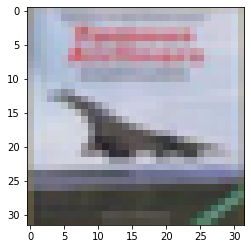

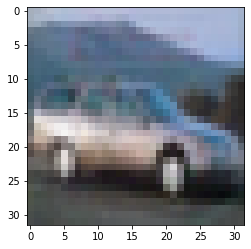

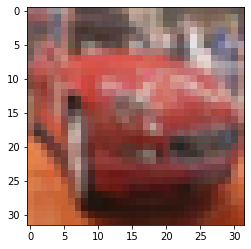

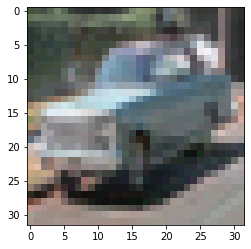

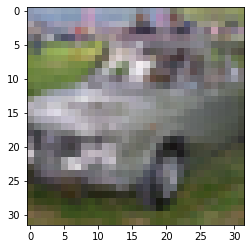

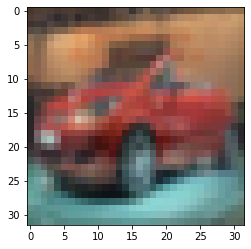

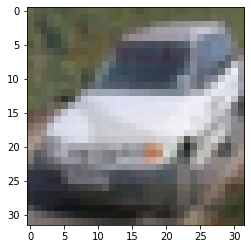

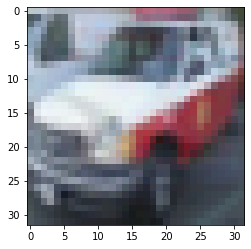

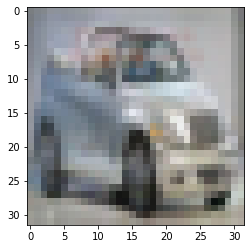

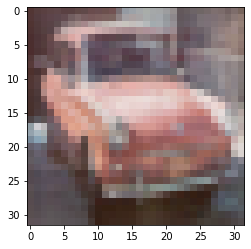

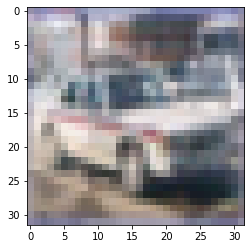

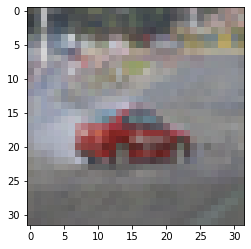

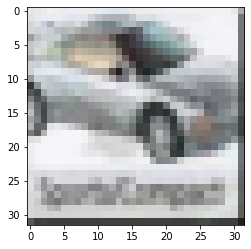

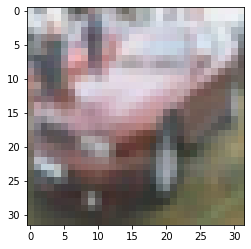

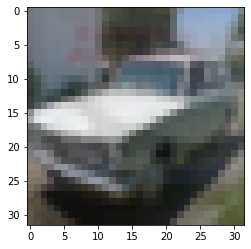

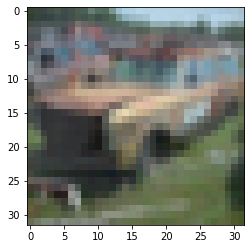

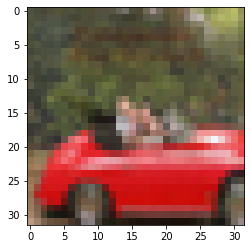

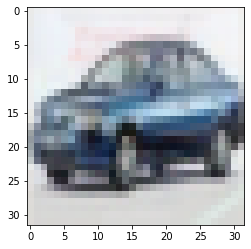

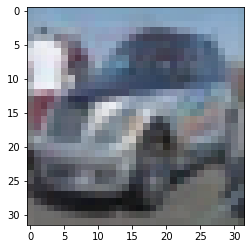

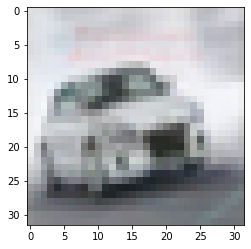

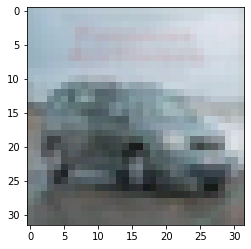

epoch: 1, Discriminator Loss: 0.45125603675842285
Train accuracy is: 71.66666666666667% 
Test accuracy is: 73.35000000000001% 
epoch: 2, Discriminator Loss: 0.3568084239959717
Train accuracy is: 70.49019607843138% 
Test accuracy is: 72.5% 
epoch: 3, Discriminator Loss: 0.4658131003379822
Train accuracy is: 81.56862745098039% 
Test accuracy is: 79.85% 
epoch: 4, Discriminator Loss: 0.557355523109436
Train accuracy is: 81.07843137254902% 
Test accuracy is: 82.5% 
epoch: 5, Discriminator Loss: 0.5084764957427979
Train accuracy is: 84.31372549019608% 
Test accuracy is: 84.6% 
epoch: 6, Discriminator Loss: 0.6112536191940308
Train accuracy is: 81.17647058823529% 
Test accuracy is: 85.2% 
epoch: 7, Discriminator Loss: 0.48374491930007935
Train accuracy is: 84.01960784313725% 
Test accuracy is: 85.0% 
epoch: 8, Discriminator Loss: 0.43014270067214966
Train accuracy is: 85.58823529411764% 
Test accuracy is: 86.65% 
epoch: 9, Discriminator Loss: 0.36159825325012207
Train accuracy is: 84.2156862

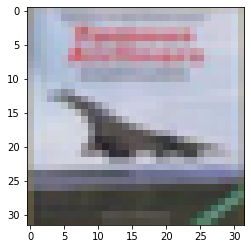

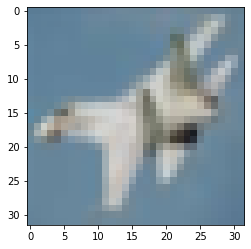

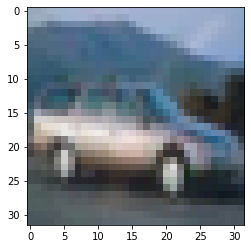

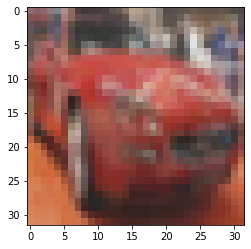

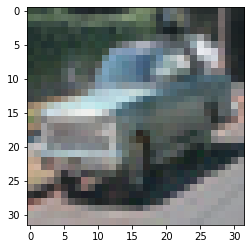

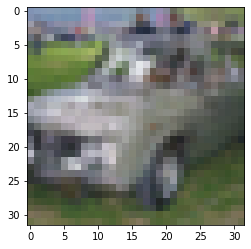

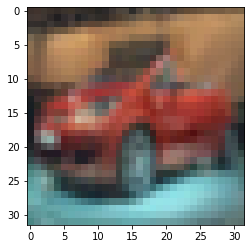

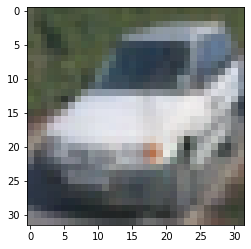

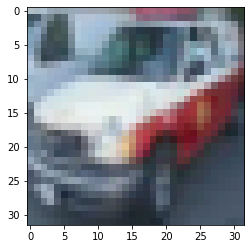

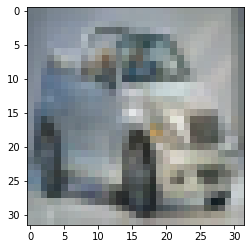

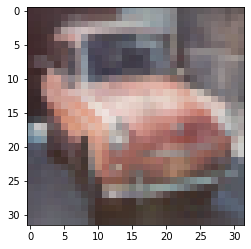

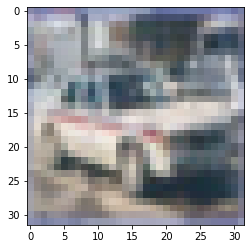

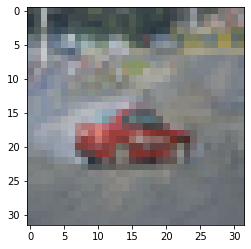

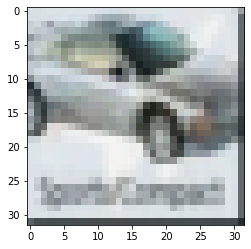

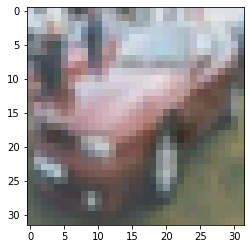

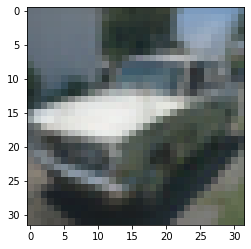

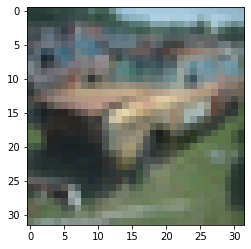

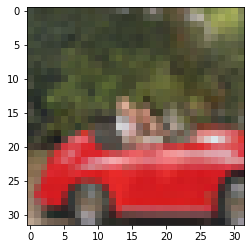

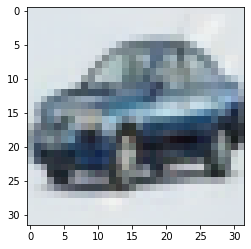

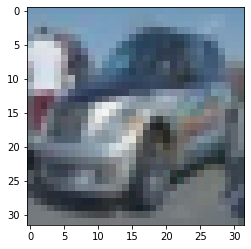

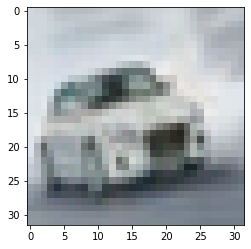

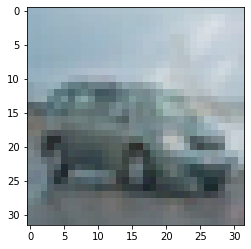

epoch: 1, Discriminator Loss: 0.5476913452148438
Train accuracy is: 76.37254901960785% 
Test accuracy is: 77.3% 
epoch: 2, Discriminator Loss: 0.49024540185928345
Train accuracy is: 79.90196078431373% 
Test accuracy is: 81.10000000000001% 
epoch: 3, Discriminator Loss: 0.5702726244926453
Train accuracy is: 82.35294117647058% 
Test accuracy is: 83.39999999999999% 
epoch: 4, Discriminator Loss: 0.3568573594093323
Train accuracy is: 75.98039215686273% 
Test accuracy is: 79.7% 
epoch: 5, Discriminator Loss: 0.34387141466140747
Train accuracy is: 83.92156862745098% 
Test accuracy is: 83.25% 
epoch: 6, Discriminator Loss: 0.37708836793899536
Train accuracy is: 84.01960784313725% 
Test accuracy is: 83.39999999999999% 
epoch: 7, Discriminator Loss: 0.5938349962234497
Train accuracy is: 82.45098039215686% 
Test accuracy is: 85.35000000000001% 
epoch: 8, Discriminator Loss: 0.39112961292266846
Train accuracy is: 84.41176470588235% 
Test accuracy is: 85.3% 
epoch: 9, Discriminator Loss: 0.3696113

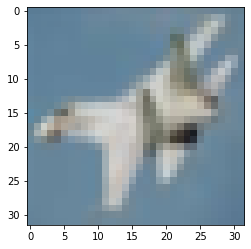

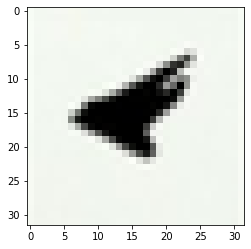

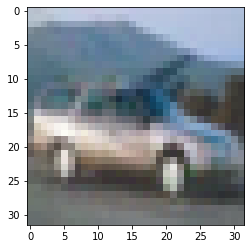

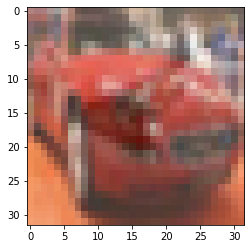

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


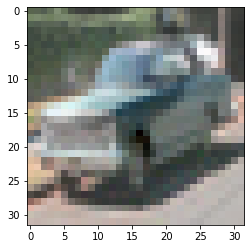

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


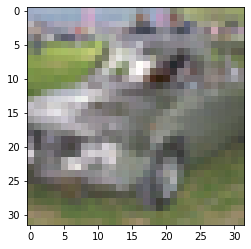

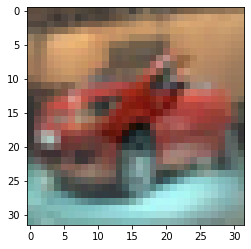

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


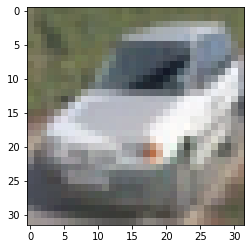

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


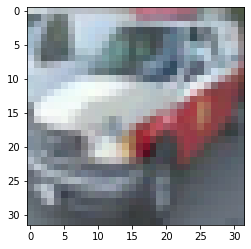

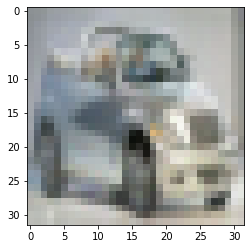

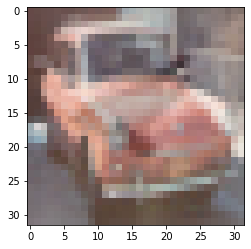

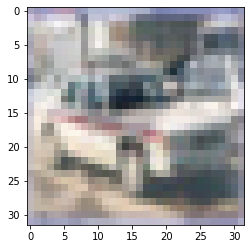

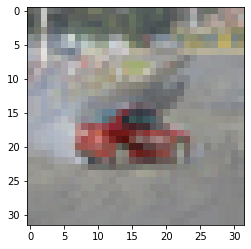

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


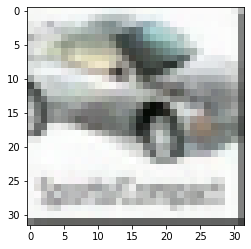

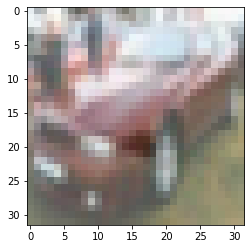

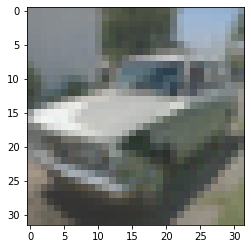

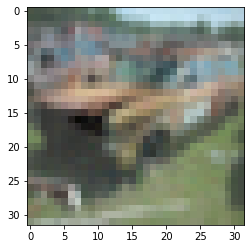

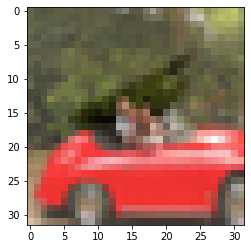

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


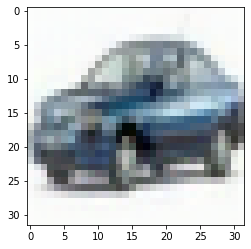

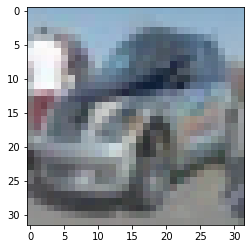

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


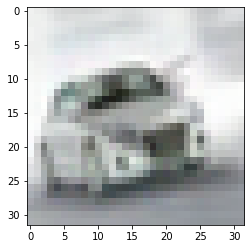

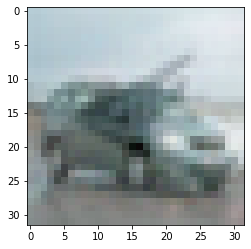

epoch: 1, Discriminator Loss: 0.831096351146698
Train accuracy is: 75.49019607843137% 
Test accuracy is: 77.2% 
epoch: 2, Discriminator Loss: 0.6451817154884338
Train accuracy is: 75.68627450980392% 
Test accuracy is: 77.2% 
epoch: 3, Discriminator Loss: 0.7114957571029663
Train accuracy is: 76.17647058823529% 
Test accuracy is: 78.25% 
epoch: 4, Discriminator Loss: 0.9476936459541321
Train accuracy is: 74.70588235294117% 
Test accuracy is: 79.4% 
epoch: 5, Discriminator Loss: 0.6733071208000183
Train accuracy is: 83.52941176470588% 
Test accuracy is: 84.0% 
epoch: 6, Discriminator Loss: 0.5107244849205017
Train accuracy is: 81.07843137254902% 
Test accuracy is: 83.0% 
epoch: 7, Discriminator Loss: 0.5784215331077576
Train accuracy is: 81.86274509803921% 
Test accuracy is: 83.55% 
epoch: 8, Discriminator Loss: 0.6262710094451904
Train accuracy is: 83.03921568627452% 
Test accuracy is: 86.0% 
epoch: 9, Discriminator Loss: 0.6006273031234741
Train accuracy is: 85.68627450980392% 
Test ac

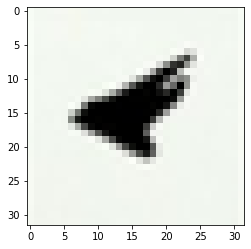

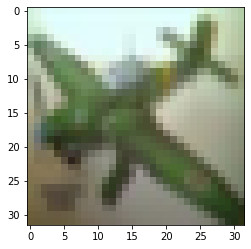

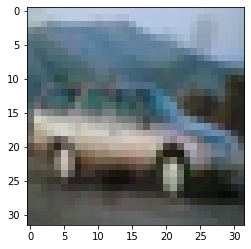

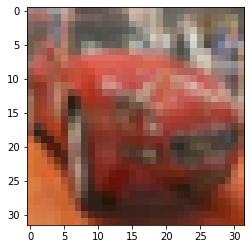

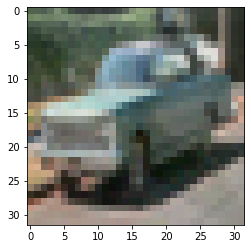

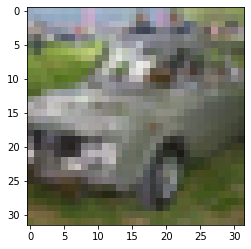

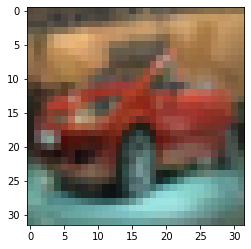

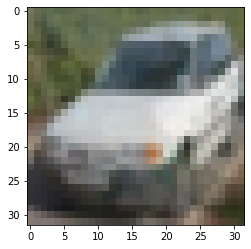

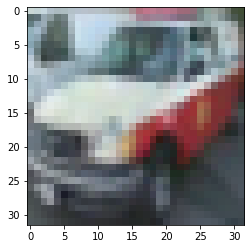

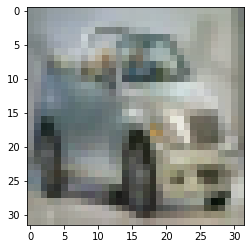

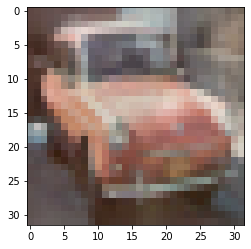

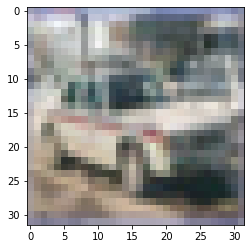

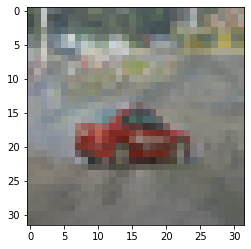

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


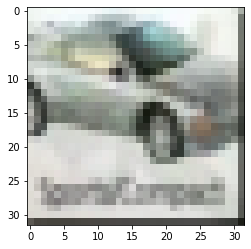

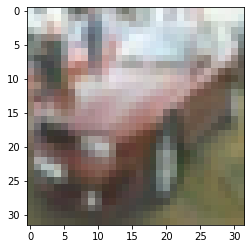

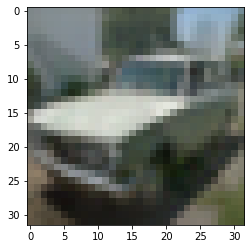

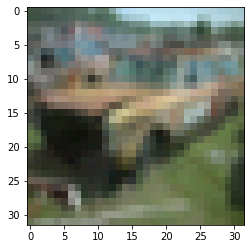

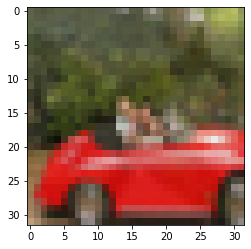

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


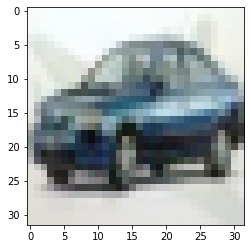

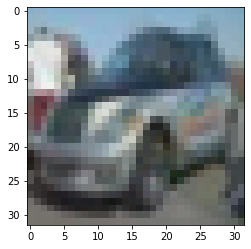

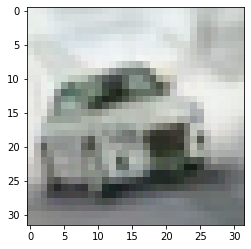

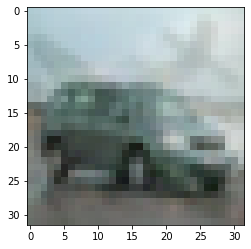

epoch: 1, Discriminator Loss: 0.4837779998779297
Train accuracy is: 73.13725490196077% 
Test accuracy is: 73.0% 
epoch: 2, Discriminator Loss: 0.40536460280418396
Train accuracy is: 75.7843137254902% 
Test accuracy is: 76.9% 
epoch: 3, Discriminator Loss: 0.4933348596096039
Train accuracy is: 79.2156862745098% 
Test accuracy is: 79.35% 
epoch: 4, Discriminator Loss: 0.4153004288673401
Train accuracy is: 79.31372549019608% 
Test accuracy is: 81.2% 
epoch: 5, Discriminator Loss: 0.37013348937034607
Train accuracy is: 79.6078431372549% 
Test accuracy is: 81.45% 
epoch: 6, Discriminator Loss: 0.4512690007686615
Train accuracy is: 80.98039215686275% 
Test accuracy is: 83.45% 
epoch: 7, Discriminator Loss: 0.3480791449546814
Train accuracy is: 83.82352941176471% 
Test accuracy is: 82.89999999999999% 
epoch: 8, Discriminator Loss: 0.37277692556381226
Train accuracy is: 82.25490196078431% 
Test accuracy is: 84.3% 
epoch: 9, Discriminator Loss: 0.43163007497787476
Train accuracy is: 84.90196078

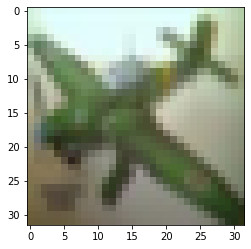

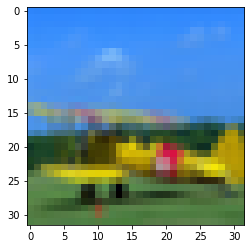

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


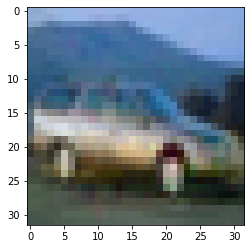

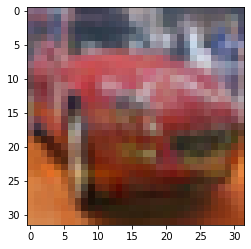

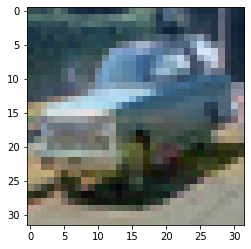

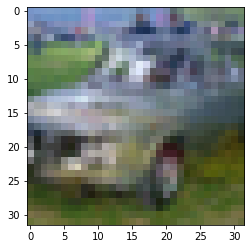

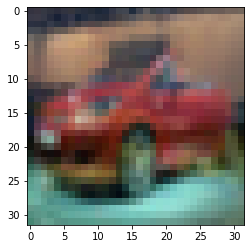

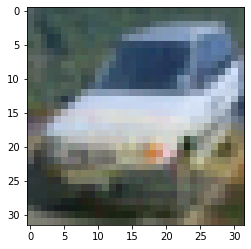

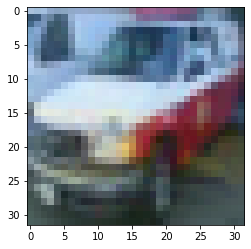

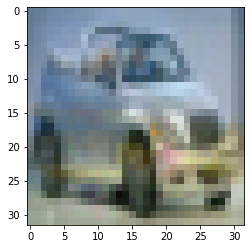

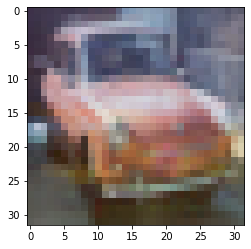

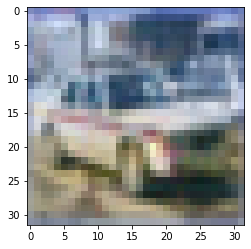

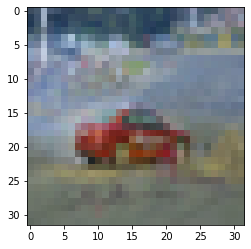

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


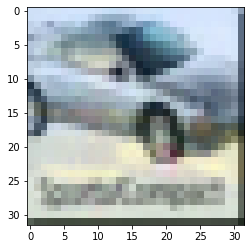

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


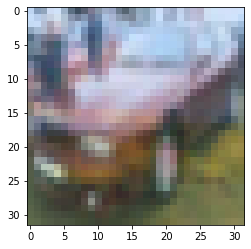

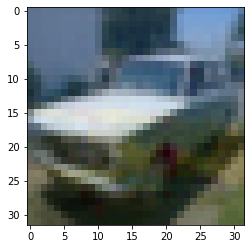

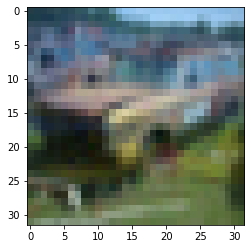

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


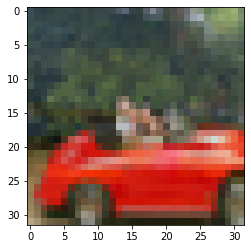

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


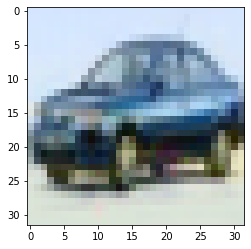

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


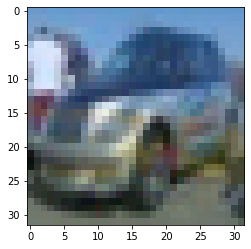

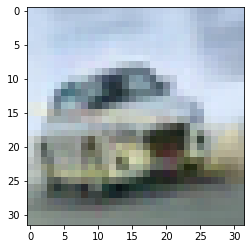

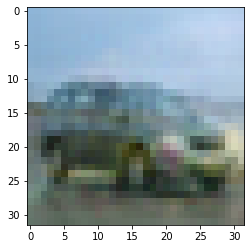

epoch: 1, Discriminator Loss: 0.5762475728988647
Train accuracy is: 72.74509803921568% 
Test accuracy is: 76.44999999999999% 
epoch: 2, Discriminator Loss: 0.509946346282959
Train accuracy is: 76.9607843137255% 
Test accuracy is: 79.35% 
epoch: 3, Discriminator Loss: 0.6140999794006348
Train accuracy is: 81.96078431372548% 
Test accuracy is: 82.69999999999999% 
epoch: 4, Discriminator Loss: 0.49851518869400024
Train accuracy is: 82.05882352941177% 
Test accuracy is: 83.1% 
epoch: 5, Discriminator Loss: 0.6982016563415527
Train accuracy is: 83.13725490196079% 
Test accuracy is: 84.75% 
epoch: 6, Discriminator Loss: 0.5310510993003845
Train accuracy is: 82.6470588235294% 
Test accuracy is: 82.3% 
epoch: 7, Discriminator Loss: 0.5189536809921265
Train accuracy is: 84.80392156862744% 
Test accuracy is: 85.3% 
epoch: 8, Discriminator Loss: 0.3692305088043213
Train accuracy is: 84.90196078431373% 
Test accuracy is: 86.0% 
epoch: 9, Discriminator Loss: 0.3790586590766907
Train accuracy is: 86

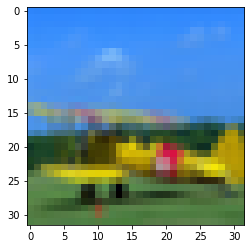

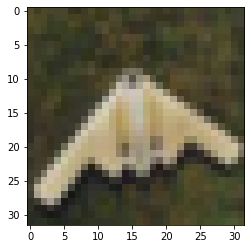

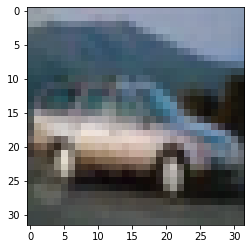

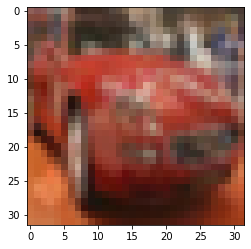

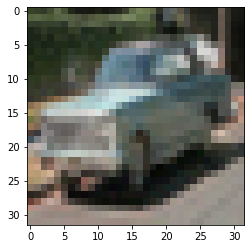

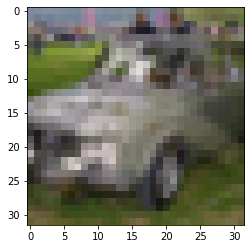

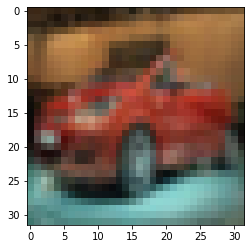

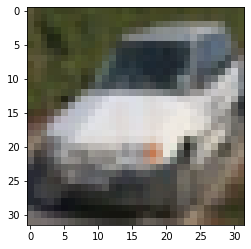

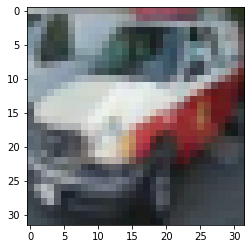

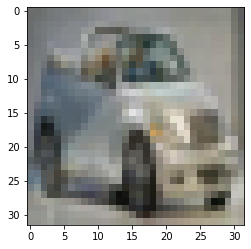

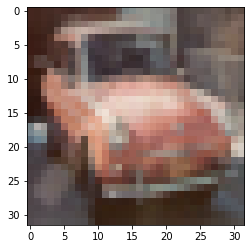

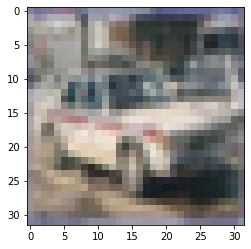

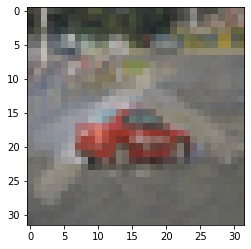

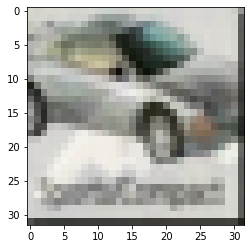

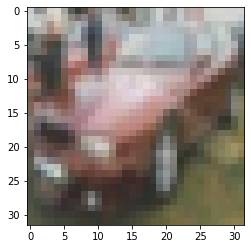

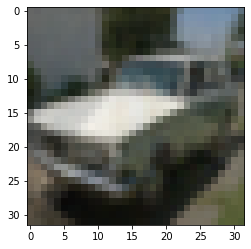

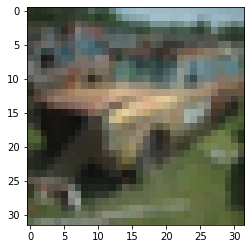

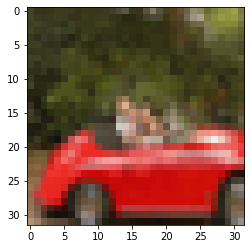

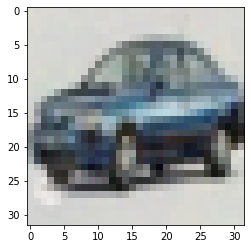

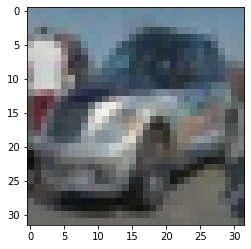

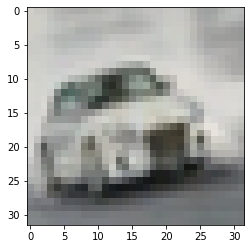

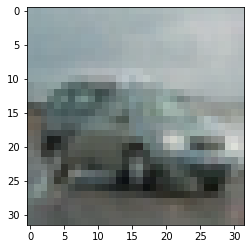

epoch: 1, Discriminator Loss: 0.3584436774253845
Train accuracy is: 76.5686274509804% 
Test accuracy is: 78.35% 
epoch: 2, Discriminator Loss: 0.41007280349731445
Train accuracy is: 76.47058823529412% 
Test accuracy is: 78.0% 
epoch: 3, Discriminator Loss: 0.3742520213127136
Train accuracy is: 78.62745098039215% 
Test accuracy is: 81.8% 
epoch: 4, Discriminator Loss: 0.36276111006736755
Train accuracy is: 81.86274509803921% 
Test accuracy is: 83.55% 
epoch: 5, Discriminator Loss: 0.3695586621761322
Train accuracy is: 79.31372549019608% 
Test accuracy is: 82.25% 
epoch: 6, Discriminator Loss: 0.437735378742218
Train accuracy is: 84.50980392156863% 
Test accuracy is: 84.65% 
epoch: 7, Discriminator Loss: 0.3363243341445923
Train accuracy is: 86.1764705882353% 
Test accuracy is: 86.35000000000001% 
epoch: 8, Discriminator Loss: 0.3814745843410492
Train accuracy is: 87.25490196078431% 
Test accuracy is: 86.2% 
epoch: 9, Discriminator Loss: 0.35206615924835205
Train accuracy is: 87.94117647

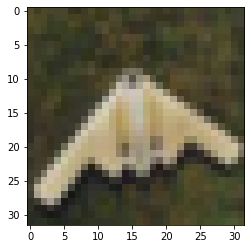

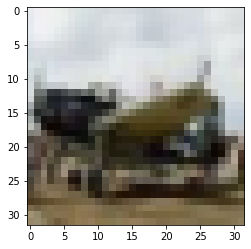

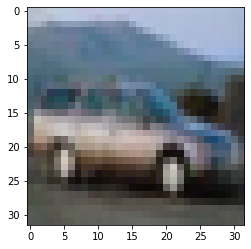

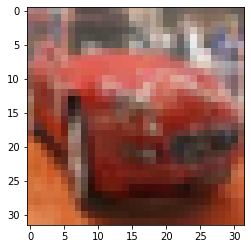

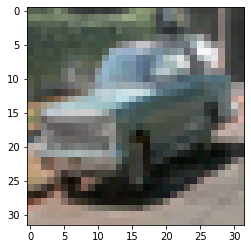

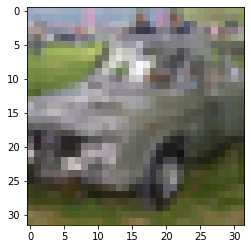

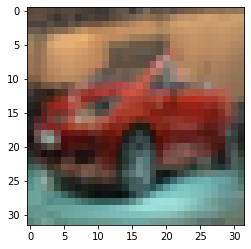

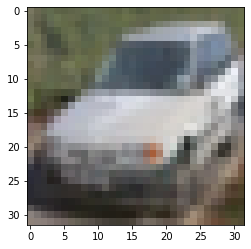

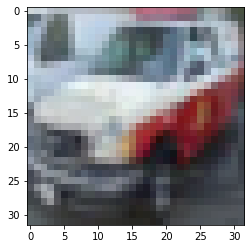

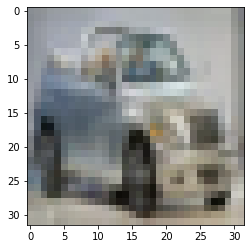

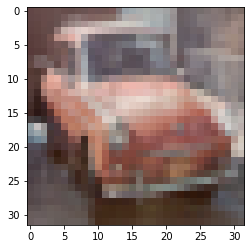

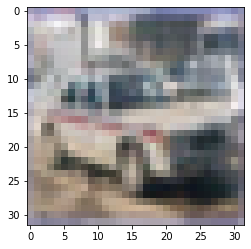

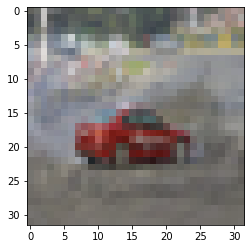

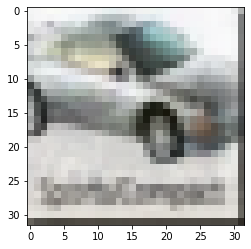

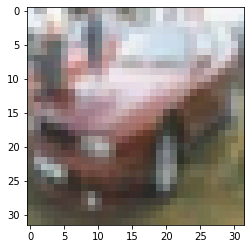

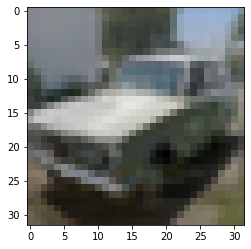

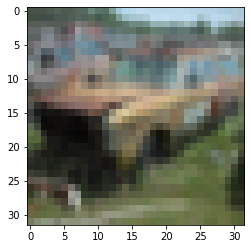

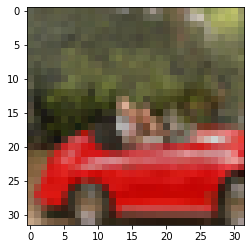

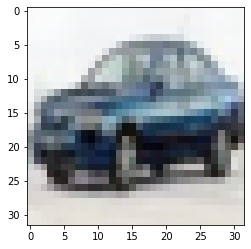

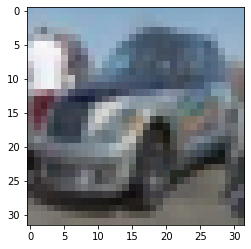

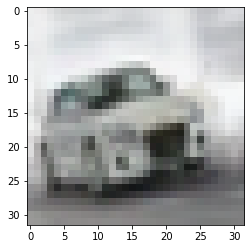

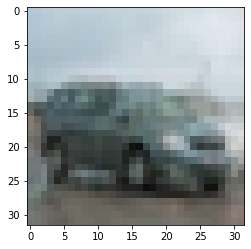

epoch: 1, Discriminator Loss: 0.4752672612667084
Train accuracy is: 72.6470588235294% 
Test accuracy is: 76.75% 
epoch: 2, Discriminator Loss: 0.542347252368927
Train accuracy is: 78.43137254901961% 
Test accuracy is: 82.25% 
epoch: 3, Discriminator Loss: 0.41470441222190857
Train accuracy is: 82.74509803921568% 
Test accuracy is: 83.1% 
epoch: 4, Discriminator Loss: 0.36483234167099
Train accuracy is: 82.54901960784314% 
Test accuracy is: 83.05% 
epoch: 5, Discriminator Loss: 0.34489303827285767
Train accuracy is: 82.35294117647058% 
Test accuracy is: 84.8% 
epoch: 6, Discriminator Loss: 0.4608904719352722
Train accuracy is: 84.80392156862744% 
Test accuracy is: 86.55000000000001% 
epoch: 7, Discriminator Loss: 0.34871694445610046
Train accuracy is: 85.88235294117646% 
Test accuracy is: 87.25% 
epoch: 8, Discriminator Loss: 0.36744260787963867
Train accuracy is: 87.74509803921569% 
Test accuracy is: 87.6% 
epoch: 9, Discriminator Loss: 0.3518439531326294
Train accuracy is: 86.66666666

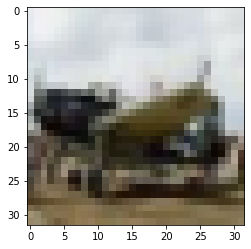

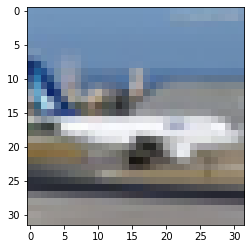

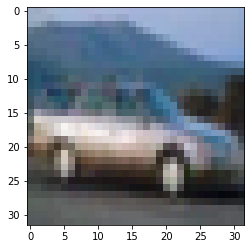

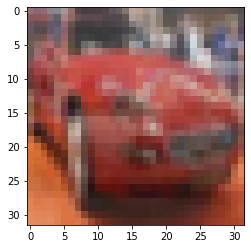

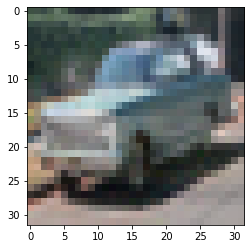

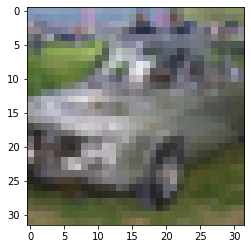

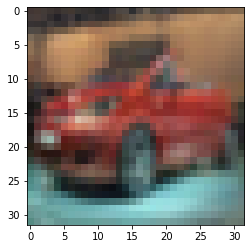

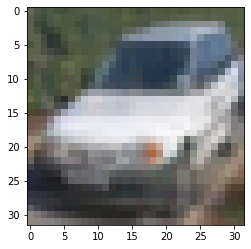

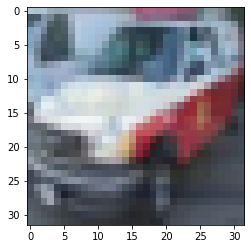

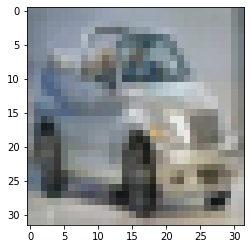

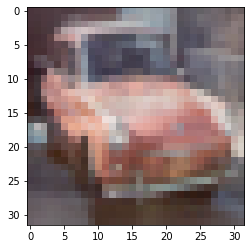

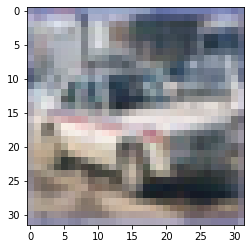

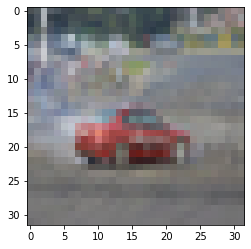

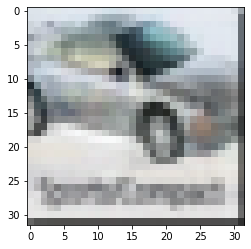

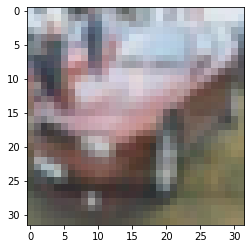

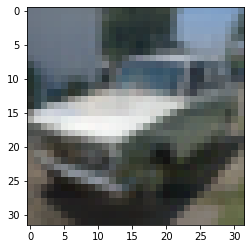

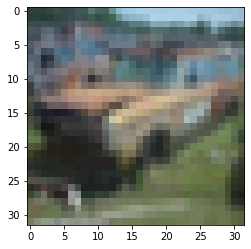

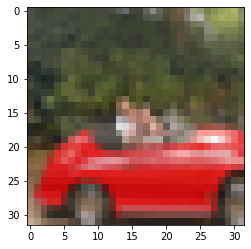

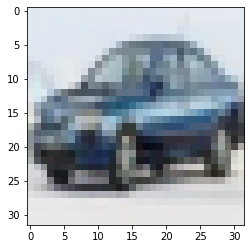

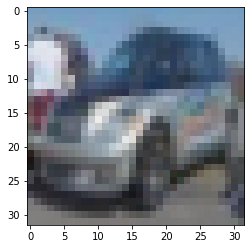

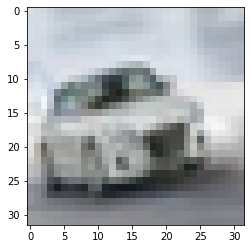

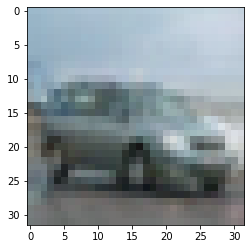

epoch: 1, Discriminator Loss: 0.5628901124000549
Train accuracy is: 73.92156862745098% 
Test accuracy is: 74.5% 
epoch: 2, Discriminator Loss: 0.3919614255428314
Train accuracy is: 75.7843137254902% 
Test accuracy is: 76.64999999999999% 
epoch: 3, Discriminator Loss: 0.5279199481010437
Train accuracy is: 80.68627450980392% 
Test accuracy is: 81.89999999999999% 
epoch: 4, Discriminator Loss: 0.3964011073112488
Train accuracy is: 79.6078431372549% 
Test accuracy is: 82.95% 
epoch: 5, Discriminator Loss: 0.38641828298568726
Train accuracy is: 81.27450980392157% 
Test accuracy is: 84.1% 
epoch: 6, Discriminator Loss: 0.39357390999794006
Train accuracy is: 83.62745098039215% 
Test accuracy is: 84.8% 
epoch: 7, Discriminator Loss: 0.40299105644226074
Train accuracy is: 82.74509803921568% 
Test accuracy is: 85.55% 
epoch: 8, Discriminator Loss: 0.378777414560318
Train accuracy is: 85.58823529411764% 
Test accuracy is: 85.45% 
epoch: 9, Discriminator Loss: 0.3249494135379791
Train accuracy is:

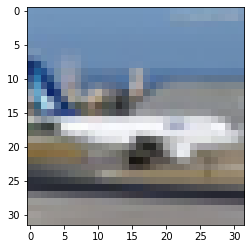

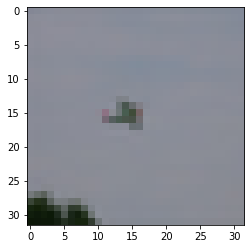

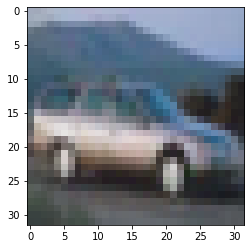

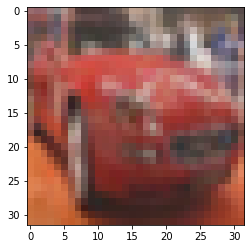

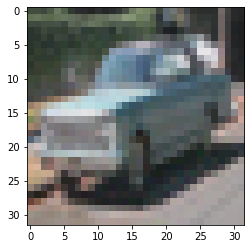

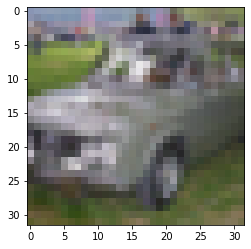

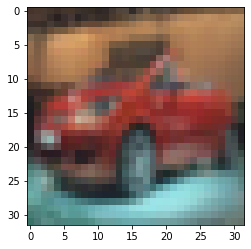

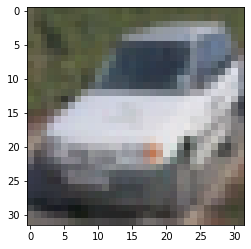

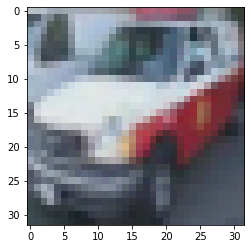

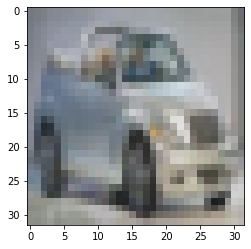

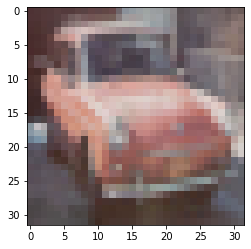

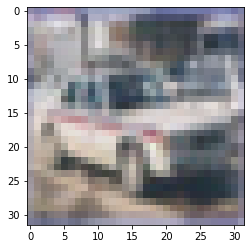

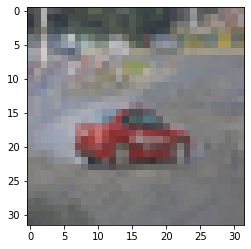

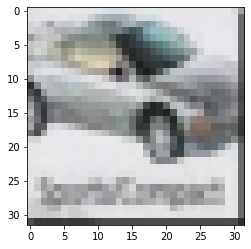

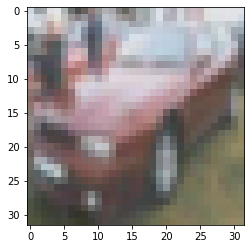

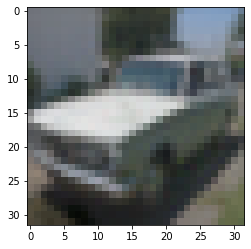

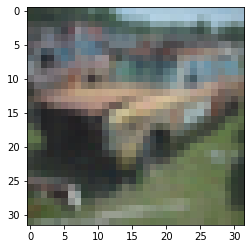

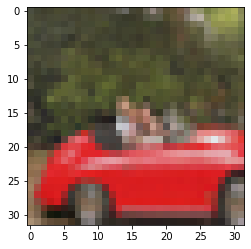

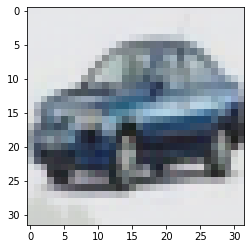

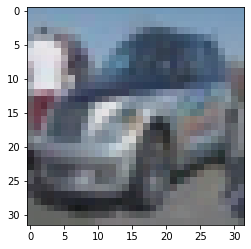

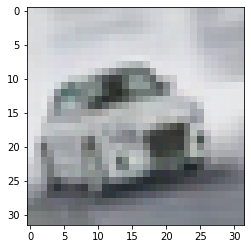

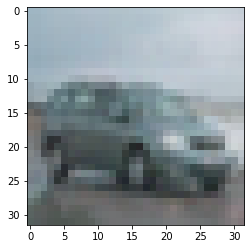

epoch: 1, Discriminator Loss: 0.47343435883522034
Train accuracy is: 67.3529411764706% 
Test accuracy is: 71.95% 
epoch: 2, Discriminator Loss: 0.5036938786506653
Train accuracy is: 78.62745098039215% 
Test accuracy is: 79.14999999999999% 
epoch: 3, Discriminator Loss: 0.4346926212310791
Train accuracy is: 80.98039215686275% 
Test accuracy is: 82.05% 
epoch: 4, Discriminator Loss: 0.5358816981315613
Train accuracy is: 81.56862745098039% 
Test accuracy is: 83.95% 
epoch: 5, Discriminator Loss: 0.40096139907836914
Train accuracy is: 80.58823529411765% 
Test accuracy is: 81.35% 
epoch: 6, Discriminator Loss: 0.3644546866416931
Train accuracy is: 81.86274509803921% 
Test accuracy is: 83.75% 
epoch: 7, Discriminator Loss: 0.36625760793685913
Train accuracy is: 83.23529411764706% 
Test accuracy is: 84.3% 
epoch: 8, Discriminator Loss: 0.43272075057029724
Train accuracy is: 84.90196078431373% 
Test accuracy is: 86.85000000000001% 
epoch: 9, Discriminator Loss: 0.37724289298057556
Train accura

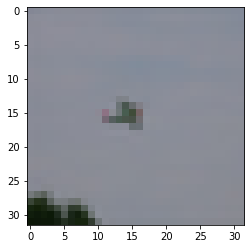

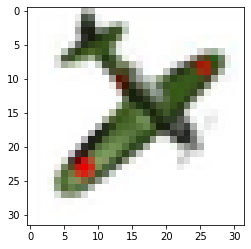

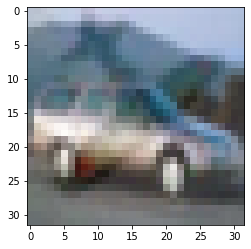

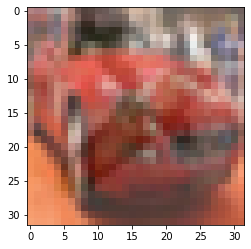

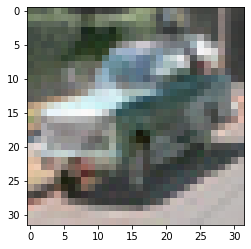

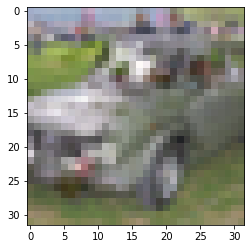

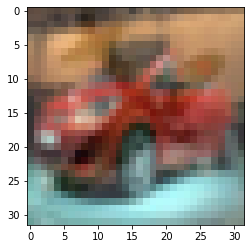

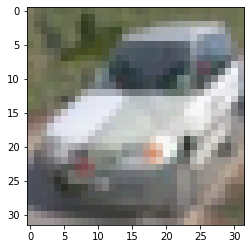

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


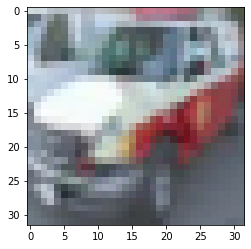

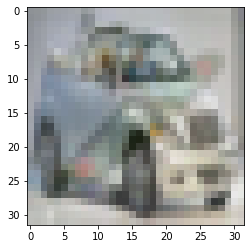

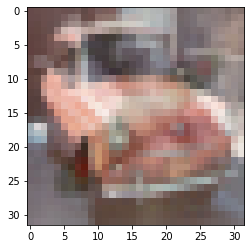

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


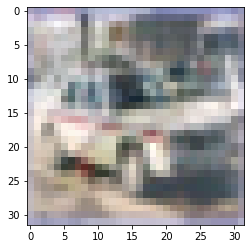

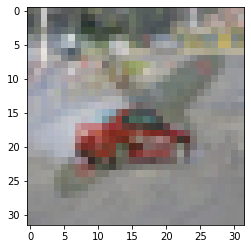

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


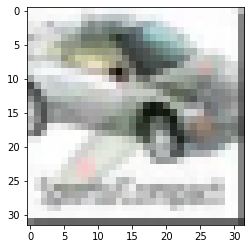

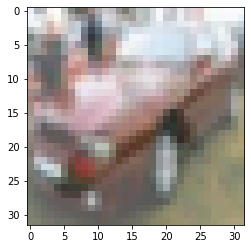

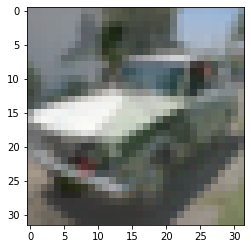

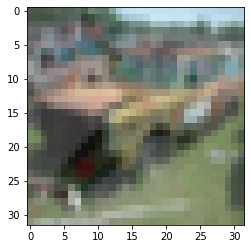

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


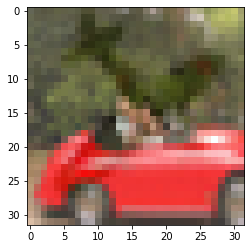

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


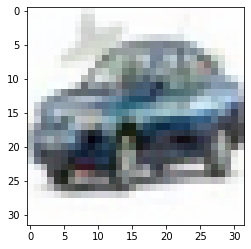

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


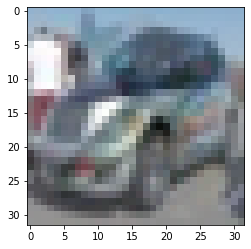

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


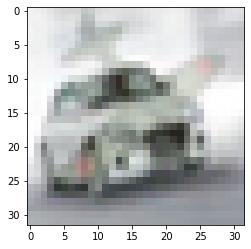

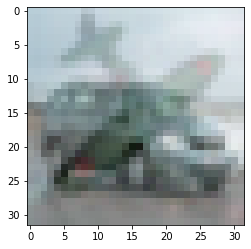

epoch: 1, Discriminator Loss: 0.7457732558250427
Train accuracy is: 72.45098039215686% 
Test accuracy is: 74.6% 
epoch: 2, Discriminator Loss: 0.6793411374092102
Train accuracy is: 79.50980392156862% 
Test accuracy is: 79.3% 
epoch: 3, Discriminator Loss: 0.6649338006973267
Train accuracy is: 79.41176470588235% 
Test accuracy is: 82.45% 
epoch: 4, Discriminator Loss: 0.4035727381706238
Train accuracy is: 78.62745098039215% 
Test accuracy is: 80.75% 
epoch: 5, Discriminator Loss: 0.4549723267555237
Train accuracy is: 81.76470588235294% 
Test accuracy is: 82.95% 
epoch: 6, Discriminator Loss: 0.401684045791626
Train accuracy is: 82.74509803921568% 
Test accuracy is: 84.65% 
epoch: 7, Discriminator Loss: 0.34031474590301514
Train accuracy is: 78.52941176470588% 
Test accuracy is: 82.89999999999999% 
epoch: 8, Discriminator Loss: 0.3496003746986389
Train accuracy is: 82.54901960784314% 
Test accuracy is: 85.45% 
epoch: 9, Discriminator Loss: 0.3911260962486267
Train accuracy is: 87.1568627

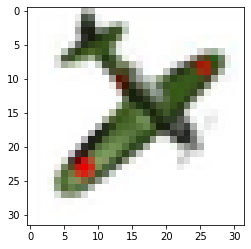

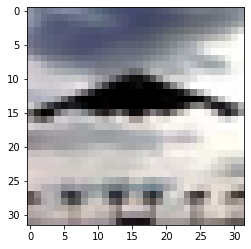

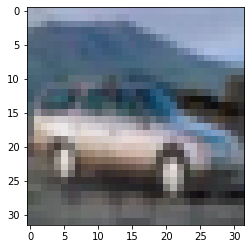

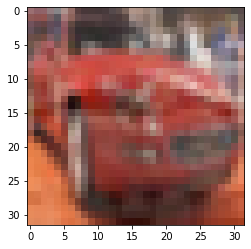

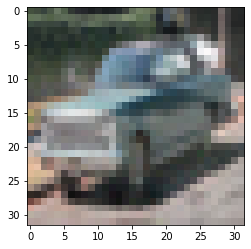

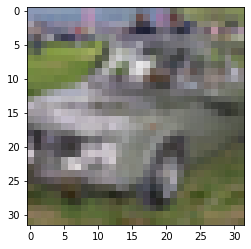

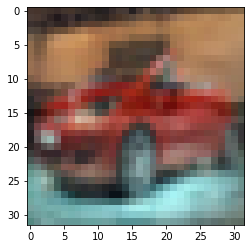

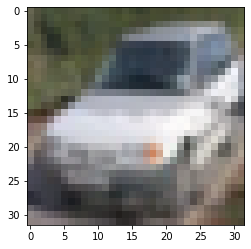

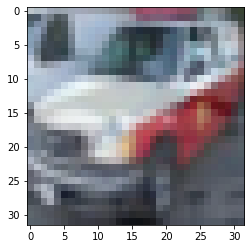

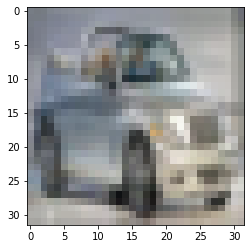

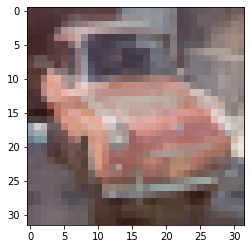

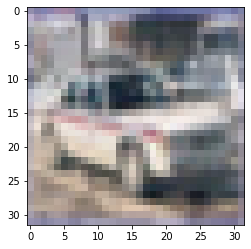

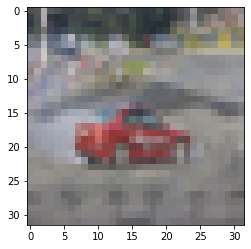

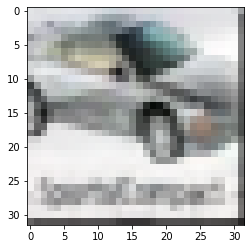

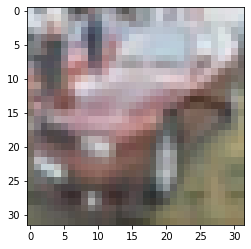

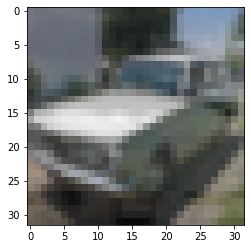

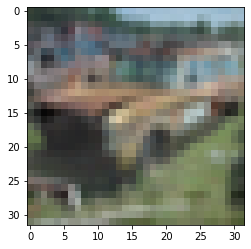

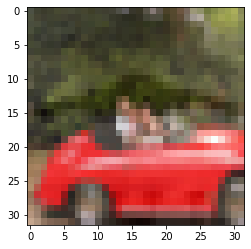

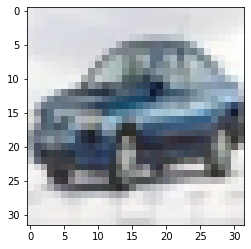

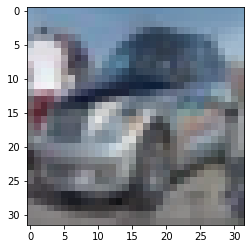

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


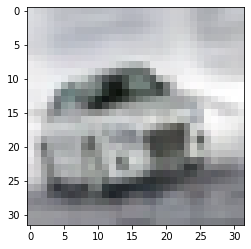

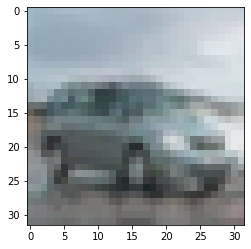

epoch: 1, Discriminator Loss: 0.5917273759841919
Train accuracy is: 70.68627450980392% 
Test accuracy is: 74.45% 
epoch: 2, Discriminator Loss: 0.4270192086696625
Train accuracy is: 76.76470588235294% 
Test accuracy is: 77.3% 
epoch: 3, Discriminator Loss: 0.5253010988235474
Train accuracy is: 77.3529411764706% 
Test accuracy is: 80.25% 
epoch: 4, Discriminator Loss: 0.36380621790885925
Train accuracy is: 80.3921568627451% 
Test accuracy is: 80.25% 
epoch: 5, Discriminator Loss: 0.3640230894088745
Train accuracy is: 83.23529411764706% 
Test accuracy is: 84.2% 
epoch: 6, Discriminator Loss: 0.47922077775001526
Train accuracy is: 82.45098039215686% 
Test accuracy is: 85.45% 
epoch: 7, Discriminator Loss: 0.41814160346984863
Train accuracy is: 82.25490196078431% 
Test accuracy is: 84.45% 
epoch: 8, Discriminator Loss: 0.3722464144229889
Train accuracy is: 84.01960784313725% 
Test accuracy is: 86.0% 
epoch: 9, Discriminator Loss: 0.34735554456710815
Train accuracy is: 84.50980392156863% 
T

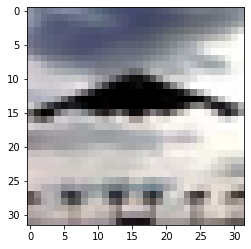

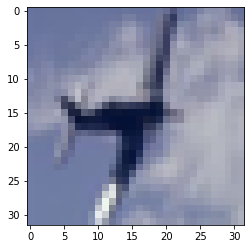

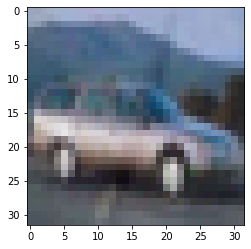

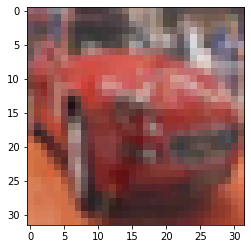

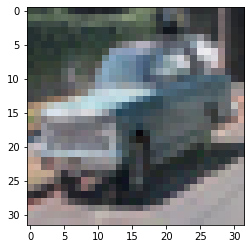

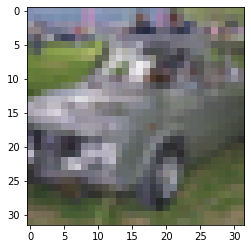

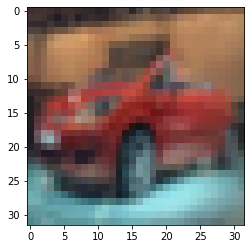

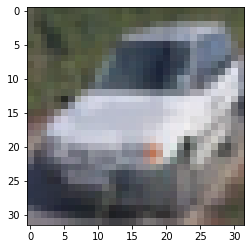

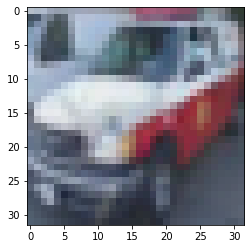

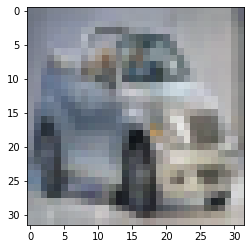

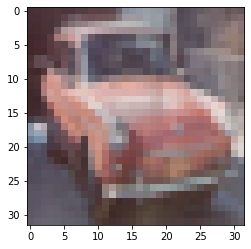

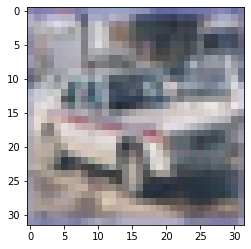

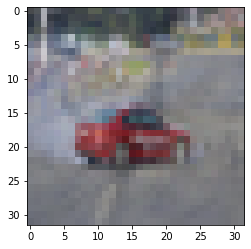

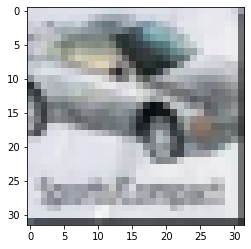

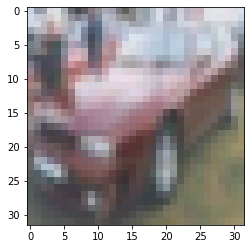

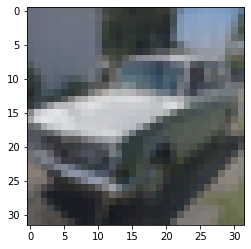

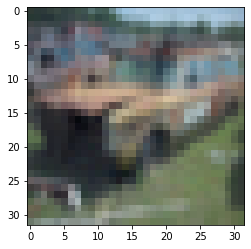

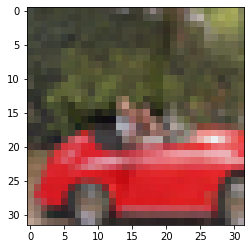

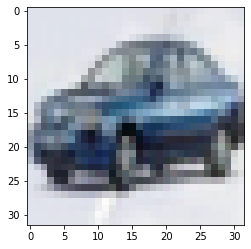

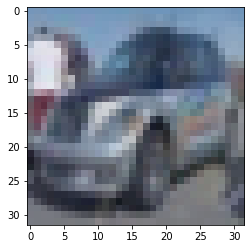

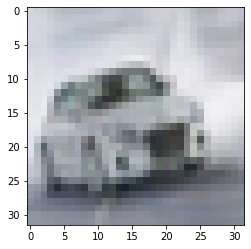

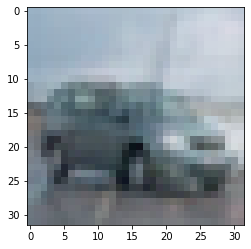

epoch: 1, Discriminator Loss: 0.5281256437301636
Train accuracy is: 75.88235294117646% 
Test accuracy is: 77.2% 
epoch: 2, Discriminator Loss: 0.47523942589759827
Train accuracy is: 78.72549019607843% 
Test accuracy is: 79.95% 
epoch: 3, Discriminator Loss: 0.593406081199646
Train accuracy is: 81.47058823529412% 
Test accuracy is: 82.65% 
epoch: 4, Discriminator Loss: 0.3995893895626068
Train accuracy is: 79.80392156862746% 
Test accuracy is: 82.55% 
epoch: 5, Discriminator Loss: 0.4457734227180481
Train accuracy is: 82.94117647058825% 
Test accuracy is: 84.25% 
epoch: 6, Discriminator Loss: 0.41580748558044434
Train accuracy is: 83.13725490196079% 
Test accuracy is: 83.15% 
epoch: 7, Discriminator Loss: 0.34529250860214233
Train accuracy is: 81.37254901960785% 
Test accuracy is: 83.15% 
epoch: 8, Discriminator Loss: 0.4541989266872406
Train accuracy is: 84.11764705882354% 
Test accuracy is: 87.1% 
epoch: 9, Discriminator Loss: 0.325649619102478
Train accuracy is: 83.52941176470588% 
T

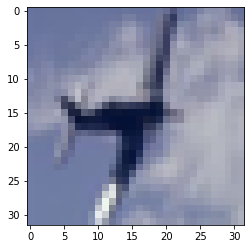

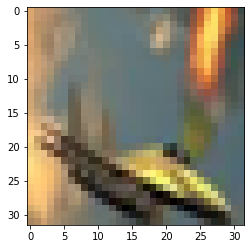

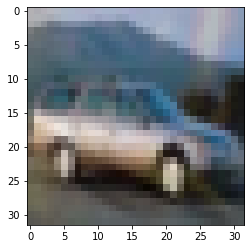

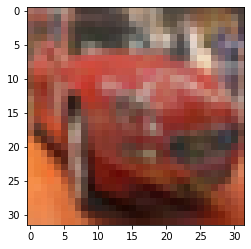

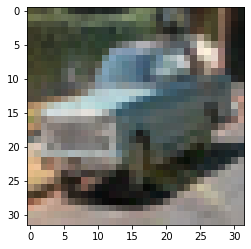

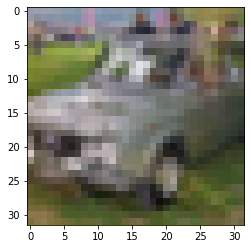

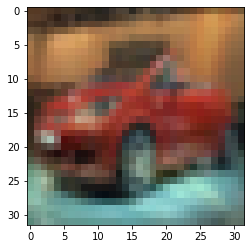

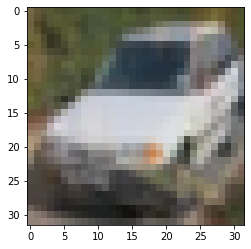

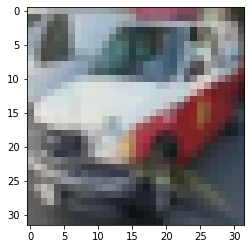

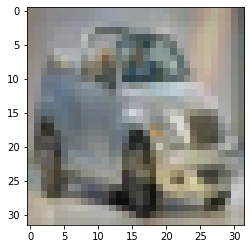

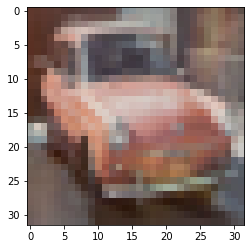

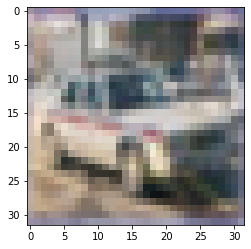

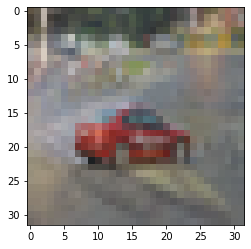

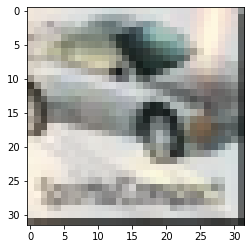

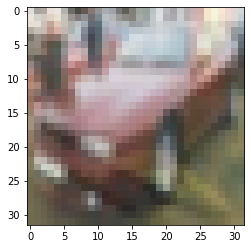

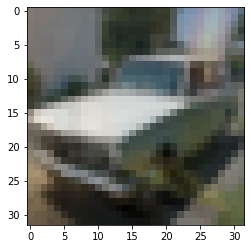

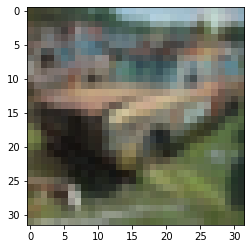

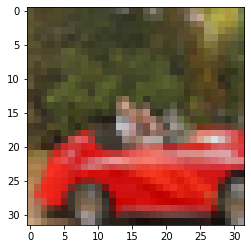

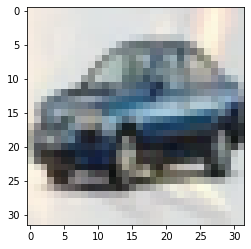

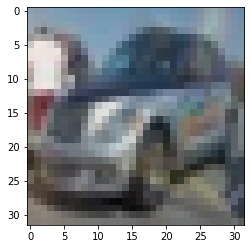

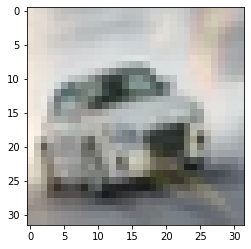

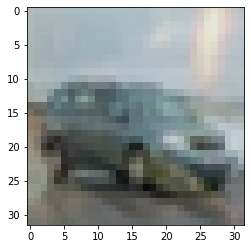

epoch: 1, Discriminator Loss: 0.3721674680709839
Train accuracy is: 72.25490196078431% 
Test accuracy is: 73.75% 
epoch: 2, Discriminator Loss: 0.3929019868373871
Train accuracy is: 77.3529411764706% 
Test accuracy is: 80.05% 
epoch: 3, Discriminator Loss: 0.46388453245162964
Train accuracy is: 79.41176470588235% 
Test accuracy is: 80.75% 
epoch: 4, Discriminator Loss: 0.34813007712364197
Train accuracy is: 79.70588235294119% 
Test accuracy is: 81.85% 
epoch: 5, Discriminator Loss: 0.4427431523799896
Train accuracy is: 82.54901960784314% 
Test accuracy is: 83.65% 
epoch: 6, Discriminator Loss: 0.37635537981987
Train accuracy is: 82.84313725490196% 
Test accuracy is: 84.0% 
epoch: 7, Discriminator Loss: 0.381587952375412
Train accuracy is: 85.7843137254902% 
Test accuracy is: 85.1% 
epoch: 8, Discriminator Loss: 0.38426899909973145
Train accuracy is: 83.23529411764706% 
Test accuracy is: 84.7% 
epoch: 9, Discriminator Loss: 0.339552104473114
Train accuracy is: 86.47058823529412% 
Test a

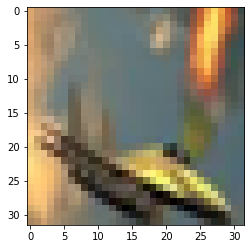

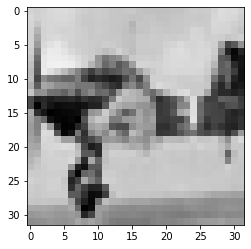

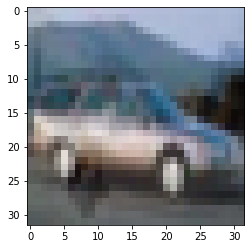

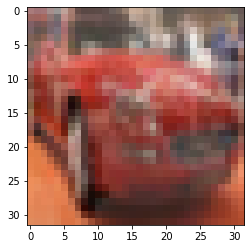

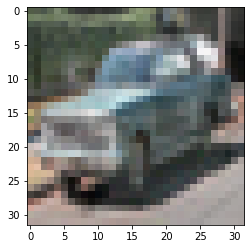

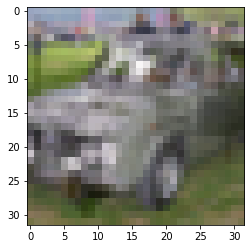

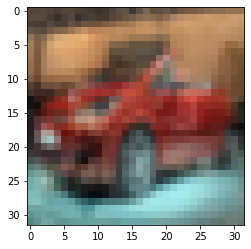

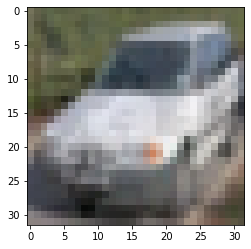

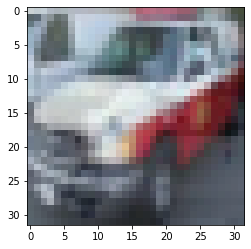

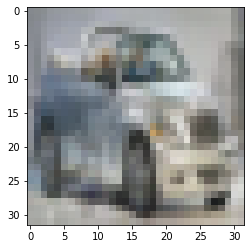

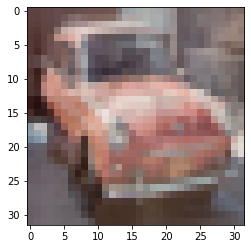

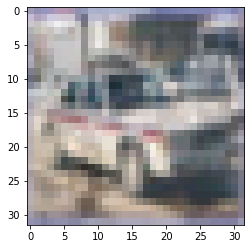

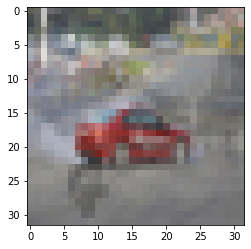

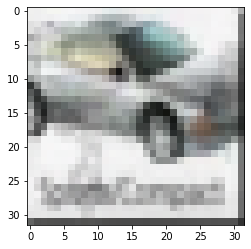

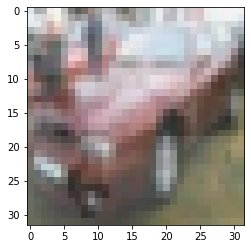

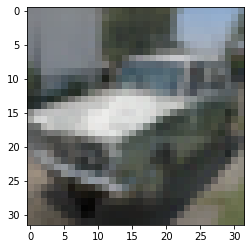

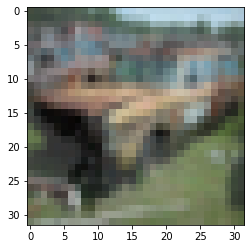

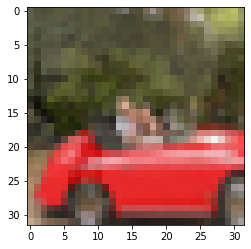

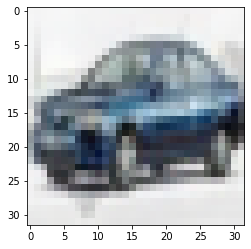

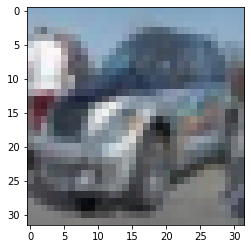

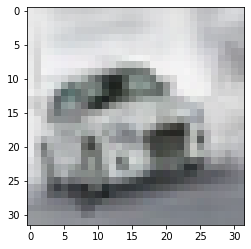

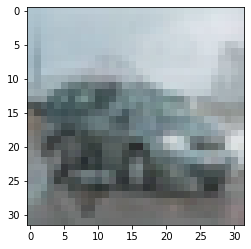

epoch: 1, Discriminator Loss: 0.5340646505355835
Train accuracy is: 71.96078431372548% 
Test accuracy is: 73.75% 
epoch: 2, Discriminator Loss: 0.39470940828323364
Train accuracy is: 71.76470588235294% 
Test accuracy is: 75.25% 
epoch: 3, Discriminator Loss: 0.4972333014011383
Train accuracy is: 76.86274509803923% 
Test accuracy is: 80.05% 
epoch: 4, Discriminator Loss: 0.3537973463535309
Train accuracy is: 76.37254901960785% 
Test accuracy is: 81.5% 
epoch: 5, Discriminator Loss: 0.4044651985168457
Train accuracy is: 79.80392156862746% 
Test accuracy is: 82.95% 
epoch: 6, Discriminator Loss: 0.38176530599594116
Train accuracy is: 85.09803921568627% 
Test accuracy is: 85.5% 
epoch: 7, Discriminator Loss: 0.36612075567245483
Train accuracy is: 83.13725490196079% 
Test accuracy is: 85.39999999999999% 
epoch: 8, Discriminator Loss: 0.3360021710395813
Train accuracy is: 87.25490196078431% 
Test accuracy is: 87.7% 
epoch: 9, Discriminator Loss: 0.3609711825847626
Train accuracy is: 88.33333

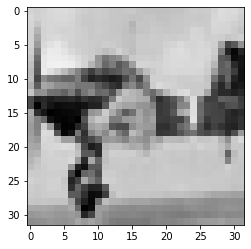

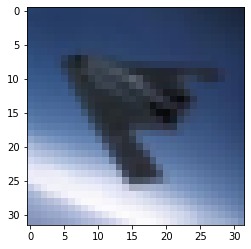

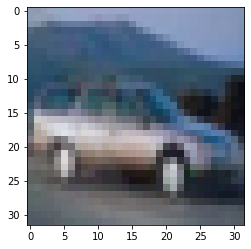

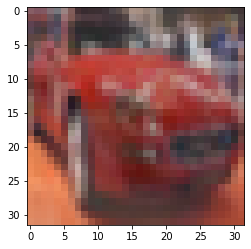

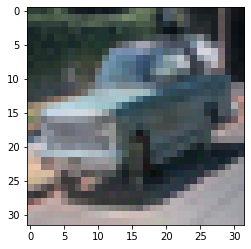

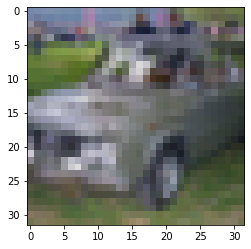

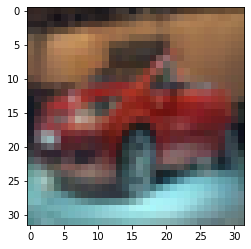

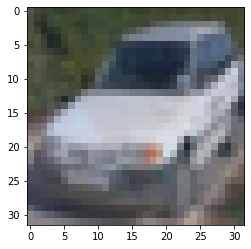

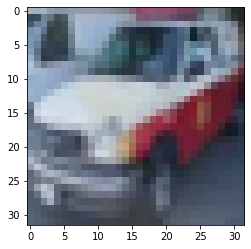

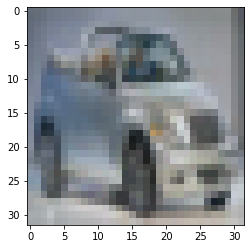

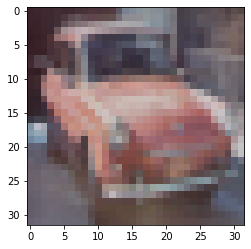

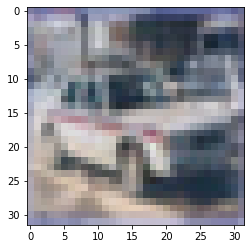

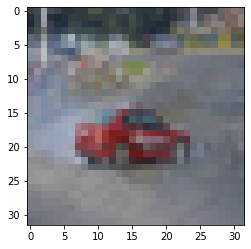

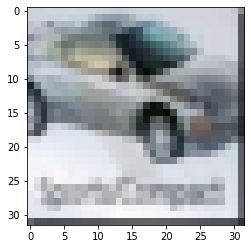

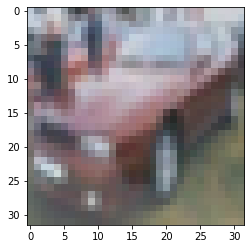

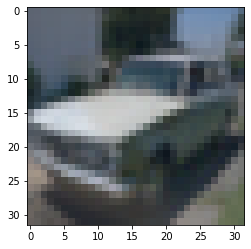

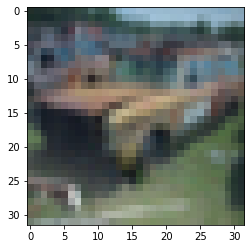

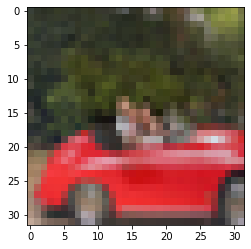

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


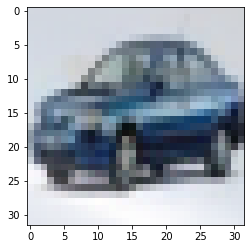

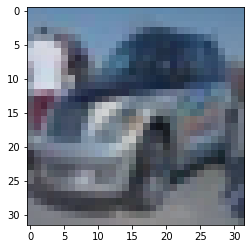

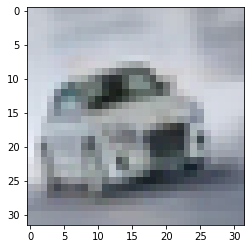

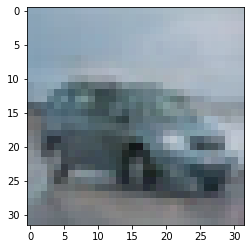

epoch: 1, Discriminator Loss: 0.39342308044433594
Train accuracy is: 71.56862745098039% 
Test accuracy is: 73.3% 
epoch: 2, Discriminator Loss: 0.4574452042579651
Train accuracy is: 79.50980392156862% 
Test accuracy is: 80.5% 
epoch: 3, Discriminator Loss: 0.4600890576839447
Train accuracy is: 81.17647058823529% 
Test accuracy is: 82.25% 
epoch: 4, Discriminator Loss: 0.4244019389152527
Train accuracy is: 82.05882352941177% 
Test accuracy is: 81.89999999999999% 
epoch: 5, Discriminator Loss: 0.40078145265579224
Train accuracy is: 80.58823529411765% 
Test accuracy is: 83.5% 
epoch: 6, Discriminator Loss: 0.34037238359451294
Train accuracy is: 79.90196078431373% 
Test accuracy is: 82.0% 
epoch: 7, Discriminator Loss: 0.3800739347934723
Train accuracy is: 80.68627450980392% 
Test accuracy is: 82.1% 
epoch: 8, Discriminator Loss: 0.3700951933860779
Train accuracy is: 82.35294117647058% 
Test accuracy is: 85.0% 
epoch: 9, Discriminator Loss: 0.34159600734710693
Train accuracy is: 84.6078431

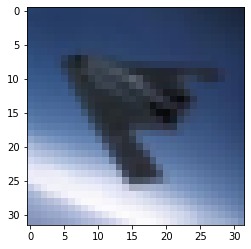

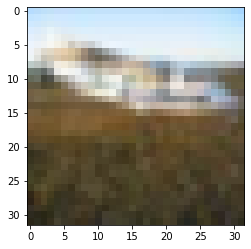

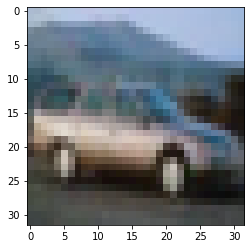

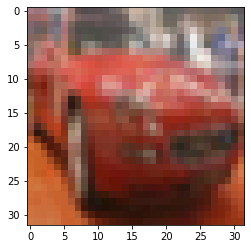

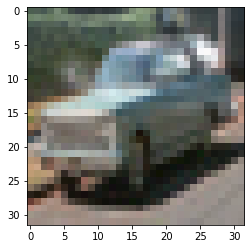

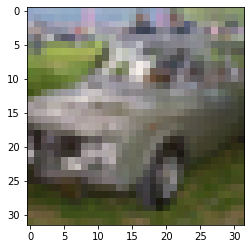

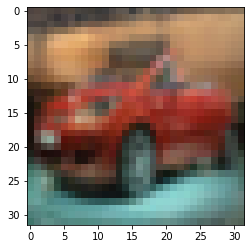

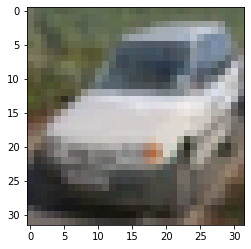

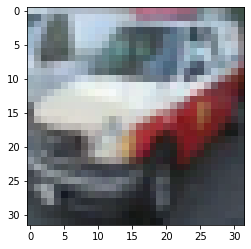

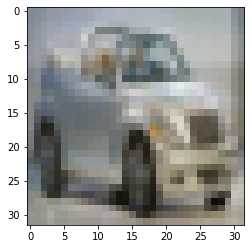

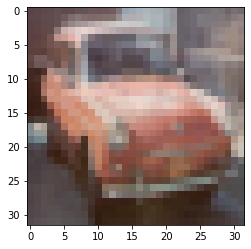

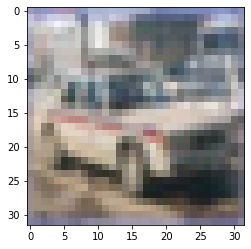

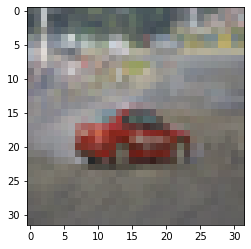

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


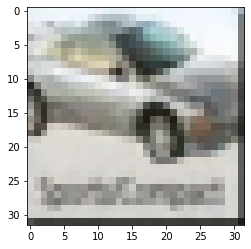

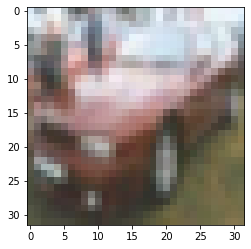

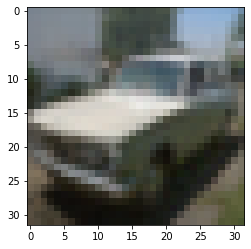

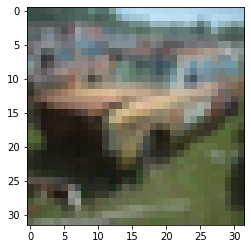

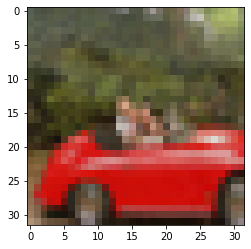

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


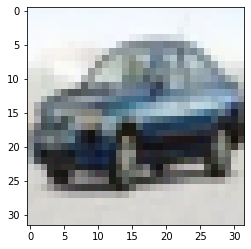

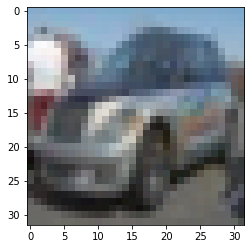

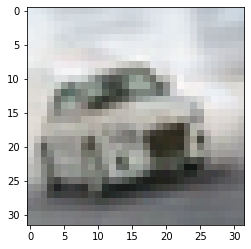

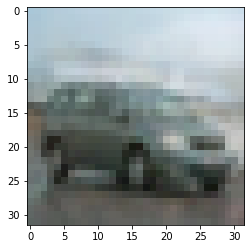

epoch: 1, Discriminator Loss: 0.41768020391464233
Train accuracy is: 74.80392156862746% 
Test accuracy is: 75.1% 
epoch: 2, Discriminator Loss: 0.49500665068626404
Train accuracy is: 78.33333333333333% 
Test accuracy is: 80.15% 
epoch: 3, Discriminator Loss: 0.4023064076900482
Train accuracy is: 79.70588235294119% 
Test accuracy is: 83.3% 
epoch: 4, Discriminator Loss: 0.3901183009147644
Train accuracy is: 80.88235294117648% 
Test accuracy is: 82.89999999999999% 
epoch: 5, Discriminator Loss: 0.5604186654090881
Train accuracy is: 81.96078431372548% 
Test accuracy is: 84.89999999999999% 
epoch: 6, Discriminator Loss: 0.44258594512939453
Train accuracy is: 84.11764705882354% 
Test accuracy is: 85.0% 
epoch: 7, Discriminator Loss: 0.3557772934436798
Train accuracy is: 82.15686274509804% 
Test accuracy is: 84.55% 
epoch: 8, Discriminator Loss: 0.3417336344718933
Train accuracy is: 83.92156862745098% 
Test accuracy is: 85.95% 
epoch: 9, Discriminator Loss: 0.3665810227394104
Train accuracy 

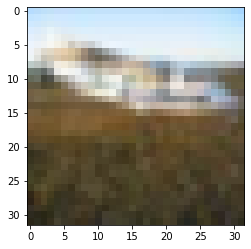

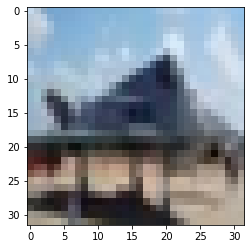

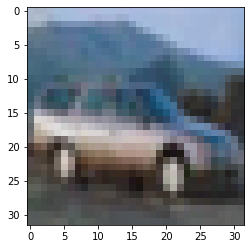

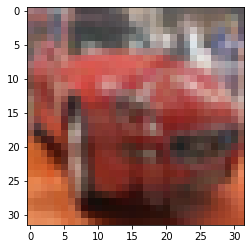

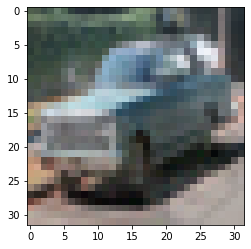

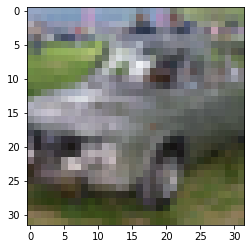

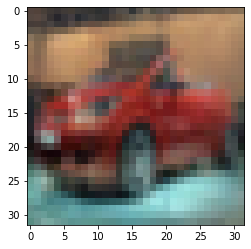

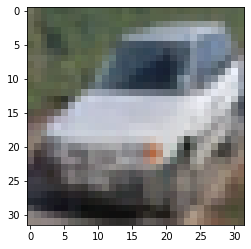

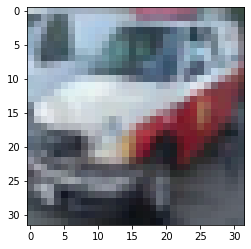

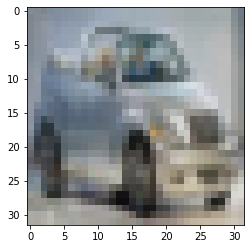

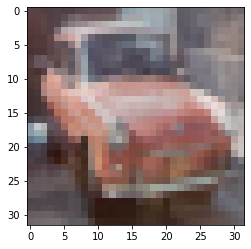

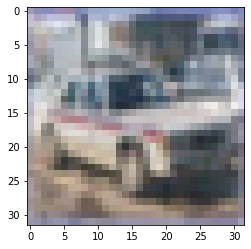

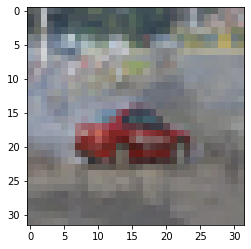

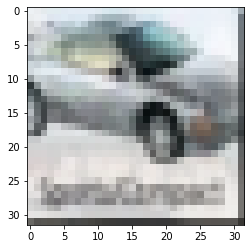

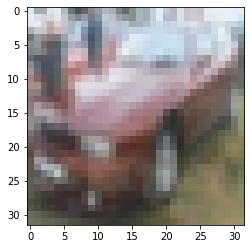

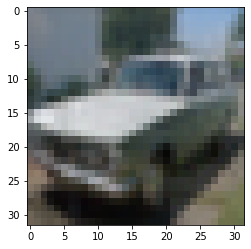

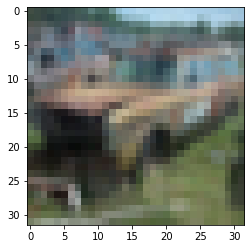

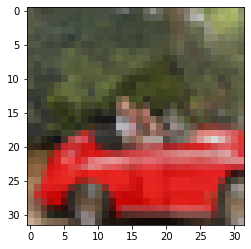

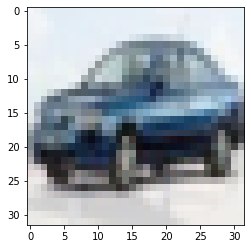

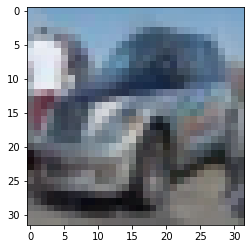

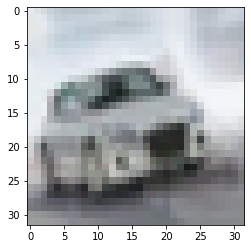

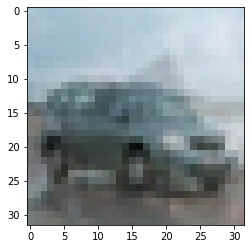

epoch: 1, Discriminator Loss: 0.4849478602409363
Train accuracy is: 72.15686274509804% 
Test accuracy is: 72.55% 
epoch: 2, Discriminator Loss: 0.38985082507133484
Train accuracy is: 71.37254901960785% 
Test accuracy is: 74.85000000000001% 
epoch: 3, Discriminator Loss: 0.4677391052246094
Train accuracy is: 75.0% 
Test accuracy is: 77.0% 
epoch: 4, Discriminator Loss: 0.4723798334598541
Train accuracy is: 77.74509803921569% 
Test accuracy is: 82.89999999999999% 
epoch: 5, Discriminator Loss: 0.5877398252487183
Train accuracy is: 84.90196078431373% 
Test accuracy is: 84.85000000000001% 
epoch: 6, Discriminator Loss: 0.4317246377468109
Train accuracy is: 83.52941176470588% 
Test accuracy is: 84.89999999999999% 
epoch: 7, Discriminator Loss: 0.4817841053009033
Train accuracy is: 85.09803921568627% 
Test accuracy is: 85.65% 
epoch: 8, Discriminator Loss: 0.4585491716861725
Train accuracy is: 86.66666666666667% 
Test accuracy is: 86.45% 
epoch: 9, Discriminator Loss: 0.4953293204307556
Trai

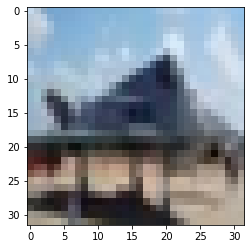

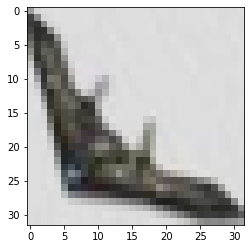

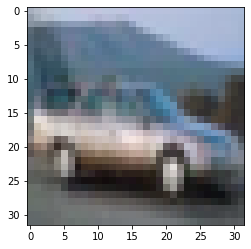

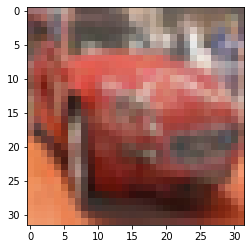

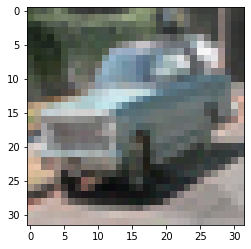

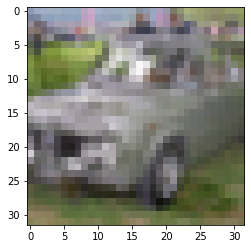

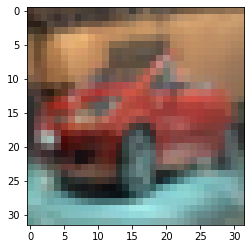

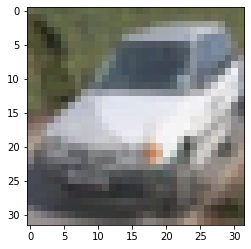

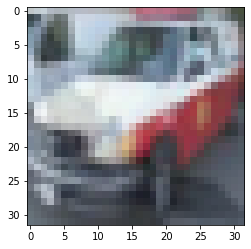

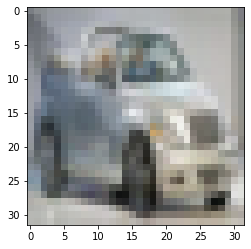

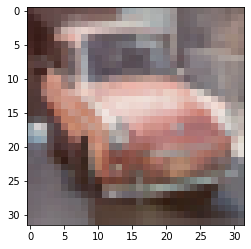

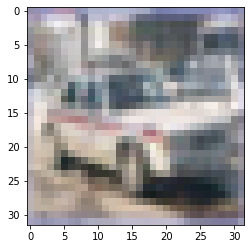

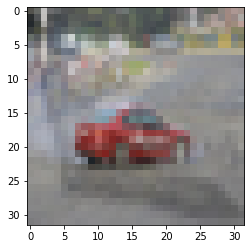

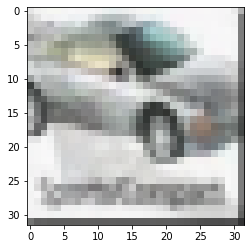

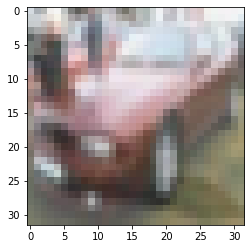

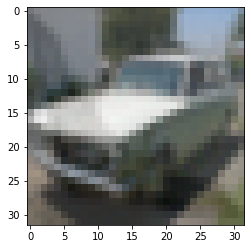

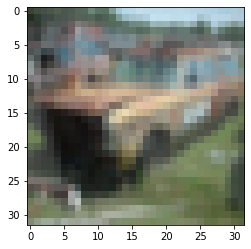

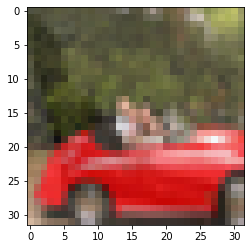

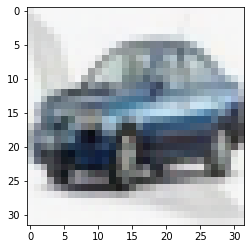

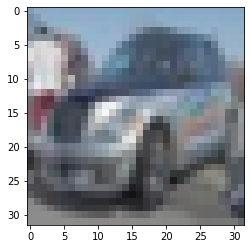

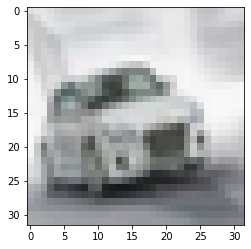

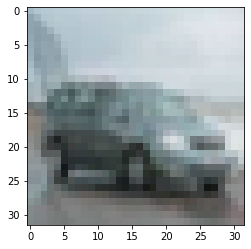

epoch: 1, Discriminator Loss: 0.5780211687088013
Train accuracy is: 75.09803921568627% 
Test accuracy is: 76.55% 
epoch: 2, Discriminator Loss: 0.4484744668006897
Train accuracy is: 81.27450980392157% 
Test accuracy is: 82.15% 
epoch: 3, Discriminator Loss: 0.6036811470985413
Train accuracy is: 80.68627450980392% 
Test accuracy is: 81.95% 
epoch: 4, Discriminator Loss: 0.39162397384643555
Train accuracy is: 79.90196078431373% 
Test accuracy is: 83.65% 
epoch: 5, Discriminator Loss: 0.3789134919643402
Train accuracy is: 82.94117647058825% 
Test accuracy is: 85.3% 
epoch: 6, Discriminator Loss: 0.34781569242477417
Train accuracy is: 86.1764705882353% 
Test accuracy is: 85.7% 
epoch: 7, Discriminator Loss: 0.3177018165588379
Train accuracy is: 82.05882352941177% 
Test accuracy is: 84.15% 
epoch: 8, Discriminator Loss: 0.3385413587093353
Train accuracy is: 82.74509803921568% 
Test accuracy is: 82.3% 
epoch: 9, Discriminator Loss: 0.3499498963356018
Train accuracy is: 85.19607843137254% 
Te

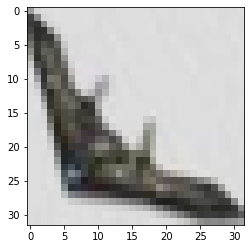

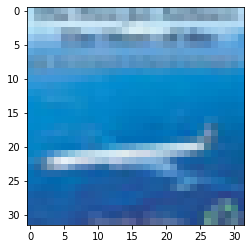

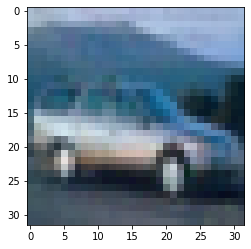

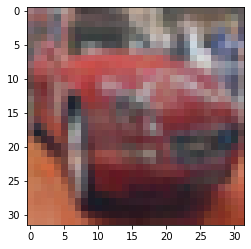

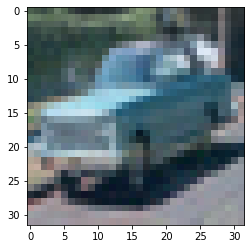

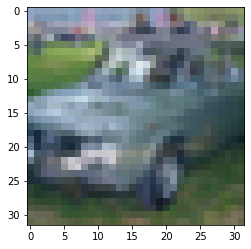

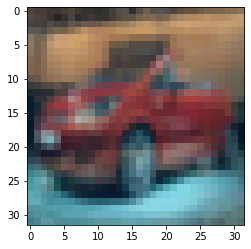

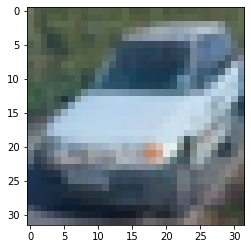

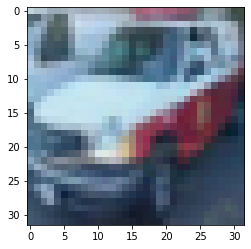

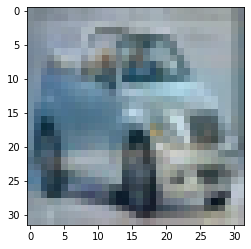

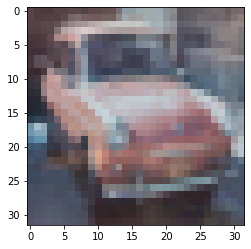

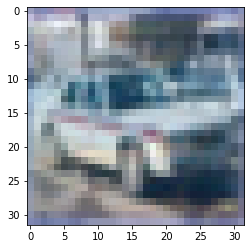

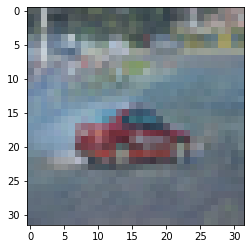

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


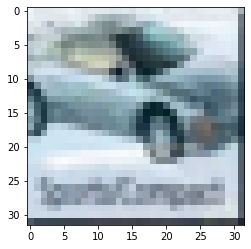

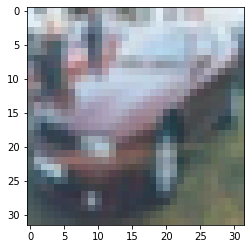

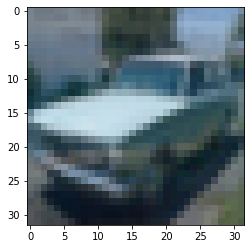

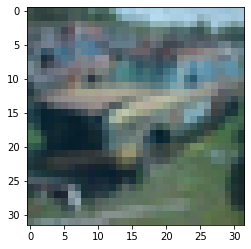

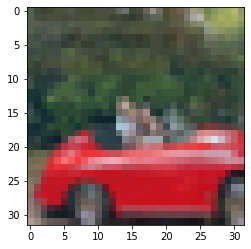

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


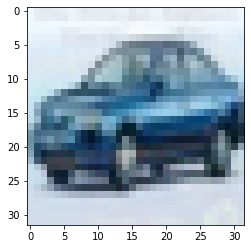

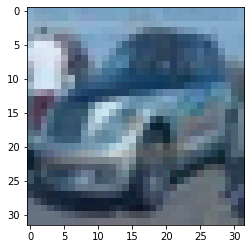

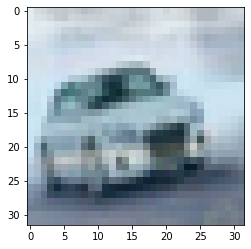

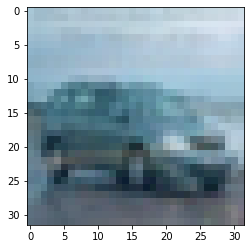

epoch: 1, Discriminator Loss: 0.6897612810134888
Train accuracy is: 74.70588235294117% 
Test accuracy is: 76.8% 
epoch: 2, Discriminator Loss: 0.5172801613807678
Train accuracy is: 79.50980392156862% 
Test accuracy is: 78.55% 
epoch: 3, Discriminator Loss: 0.5324631929397583
Train accuracy is: 79.80392156862746% 
Test accuracy is: 82.25% 
epoch: 4, Discriminator Loss: 0.431397020816803
Train accuracy is: 81.76470588235294% 
Test accuracy is: 83.5% 
epoch: 5, Discriminator Loss: 0.39649027585983276
Train accuracy is: 83.13725490196079% 
Test accuracy is: 82.75% 
epoch: 6, Discriminator Loss: 0.39660072326660156
Train accuracy is: 82.45098039215686% 
Test accuracy is: 84.5% 
epoch: 7, Discriminator Loss: 0.4854026436805725
Train accuracy is: 83.23529411764706% 
Test accuracy is: 86.05000000000001% 
epoch: 8, Discriminator Loss: 0.34008195996284485
Train accuracy is: 82.6470588235294% 
Test accuracy is: 83.55% 
epoch: 9, Discriminator Loss: 0.3490341305732727
Train accuracy is: 87.0588235

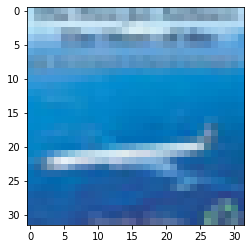

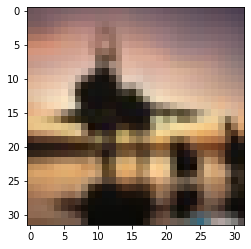

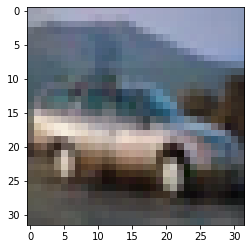

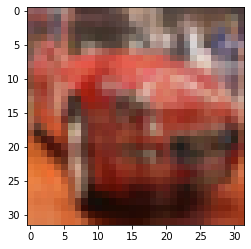

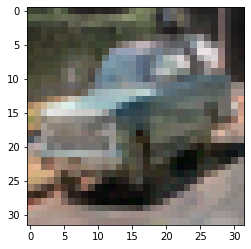

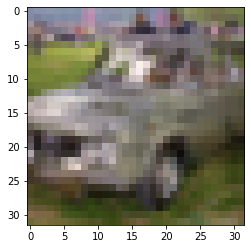

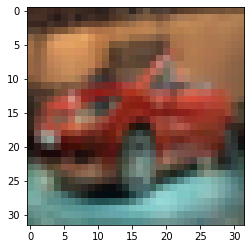

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


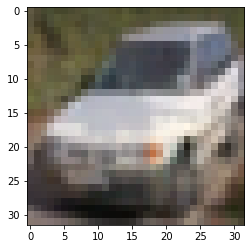

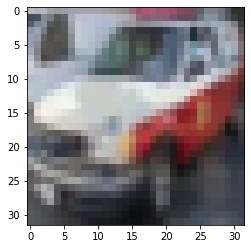

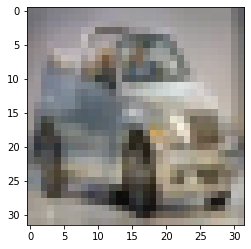

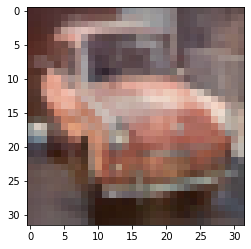

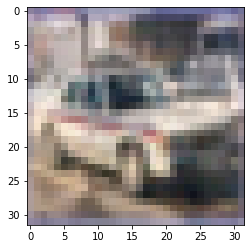

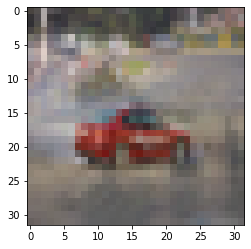

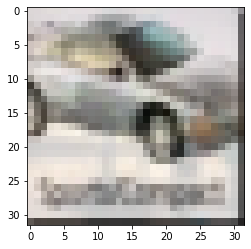

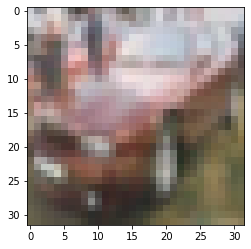

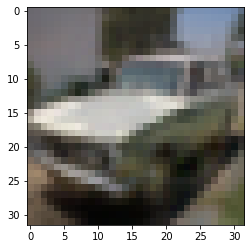

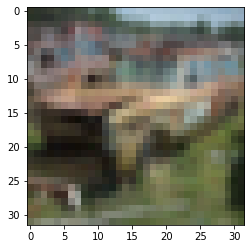

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


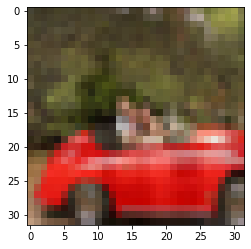

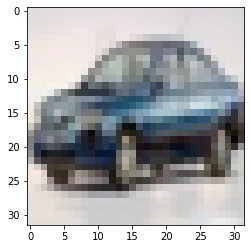

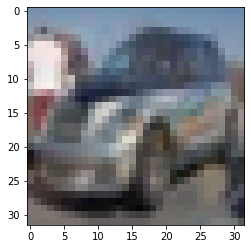

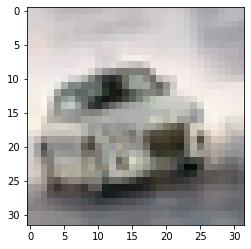

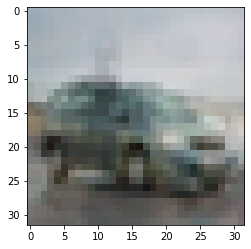

epoch: 1, Discriminator Loss: 0.45653867721557617
Train accuracy is: 75.49019607843137% 
Test accuracy is: 78.25% 
epoch: 2, Discriminator Loss: 0.4837595522403717
Train accuracy is: 79.80392156862746% 
Test accuracy is: 81.35% 
epoch: 3, Discriminator Loss: 0.37159866094589233
Train accuracy is: 81.37254901960785% 
Test accuracy is: 82.55% 
epoch: 4, Discriminator Loss: 0.399578720331192
Train accuracy is: 83.62745098039215% 
Test accuracy is: 85.45% 
epoch: 5, Discriminator Loss: 0.4116747975349426
Train accuracy is: 84.50980392156863% 
Test accuracy is: 85.5% 
epoch: 6, Discriminator Loss: 0.38968193531036377
Train accuracy is: 85.58823529411764% 
Test accuracy is: 86.4% 
epoch: 7, Discriminator Loss: 0.3396642208099365
Train accuracy is: 83.33333333333334% 
Test accuracy is: 86.1% 
epoch: 8, Discriminator Loss: 0.5750943422317505
Train accuracy is: 84.11764705882354% 
Test accuracy is: 85.65% 
epoch: 9, Discriminator Loss: 0.4799129068851471
Train accuracy is: 86.9607843137255% 
Te

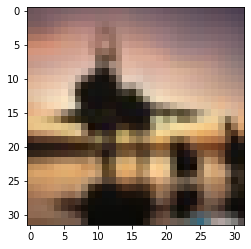

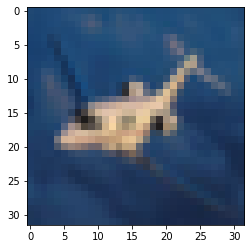

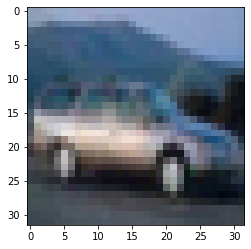

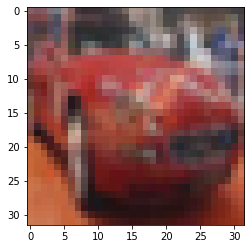

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


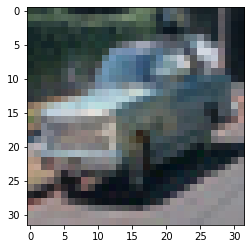

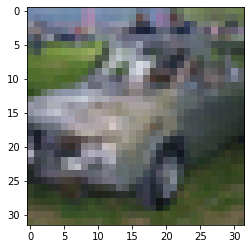

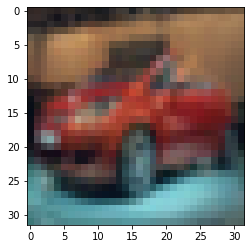

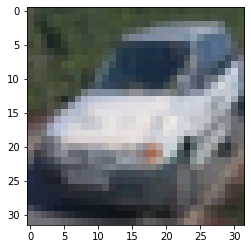

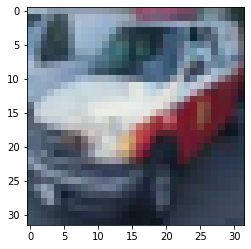

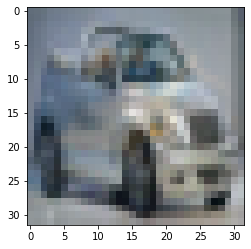

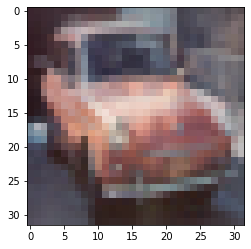

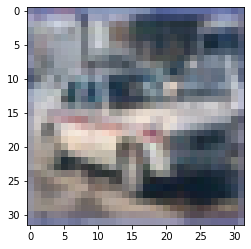

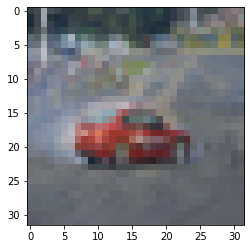

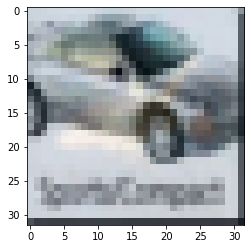

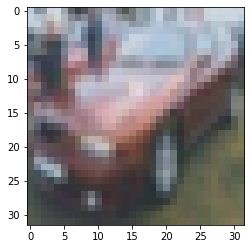

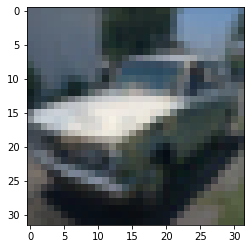

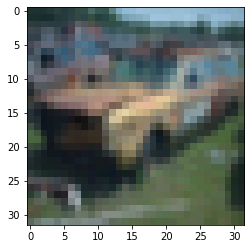

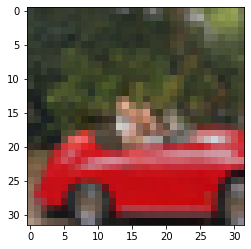

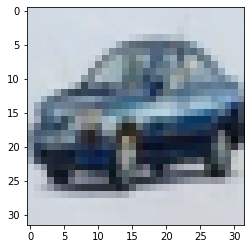

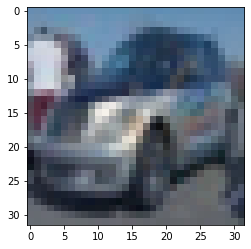

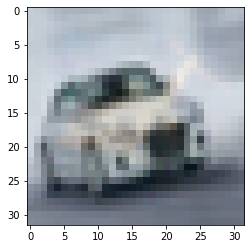

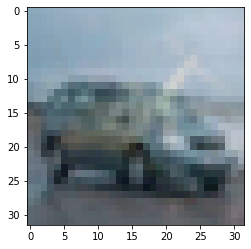

epoch: 1, Discriminator Loss: 0.607032299041748
Train accuracy is: 71.66666666666667% 
Test accuracy is: 73.8% 
epoch: 2, Discriminator Loss: 0.3911406695842743
Train accuracy is: 78.52941176470588% 
Test accuracy is: 80.9% 
epoch: 3, Discriminator Loss: 0.45764321088790894
Train accuracy is: 80.7843137254902% 
Test accuracy is: 83.45% 
epoch: 4, Discriminator Loss: 0.3446692228317261
Train accuracy is: 77.84313725490196% 
Test accuracy is: 79.9% 
epoch: 5, Discriminator Loss: 0.36641818284988403
Train accuracy is: 79.6078431372549% 
Test accuracy is: 83.25% 
epoch: 6, Discriminator Loss: 0.4766322076320648
Train accuracy is: 85.0% 
Test accuracy is: 84.3% 
epoch: 7, Discriminator Loss: 0.3606765866279602
Train accuracy is: 84.01960784313725% 
Test accuracy is: 85.5% 
epoch: 8, Discriminator Loss: 0.3370256721973419
Train accuracy is: 85.68627450980392% 
Test accuracy is: 86.9% 
epoch: 9, Discriminator Loss: 0.46837759017944336
Train accuracy is: 85.98039215686275% 
Test accuracy is: 8

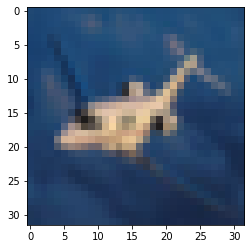

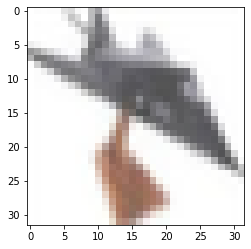

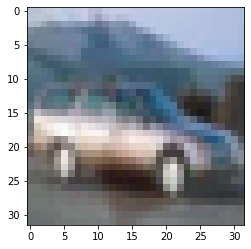

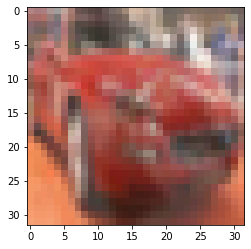

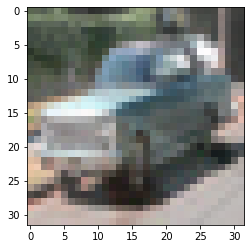

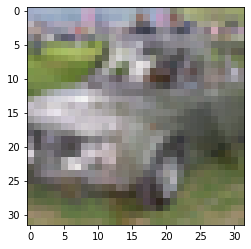

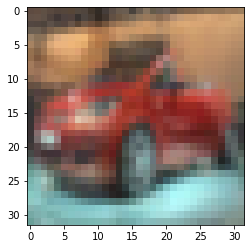

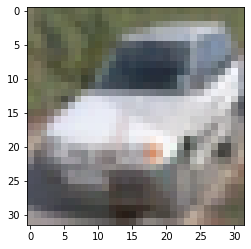

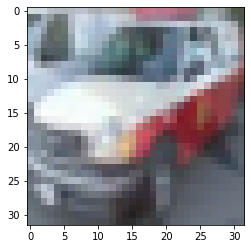

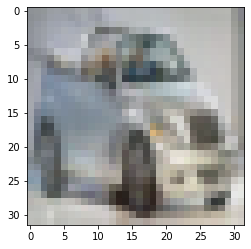

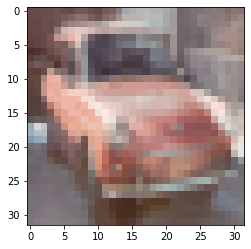

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


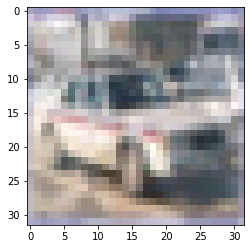

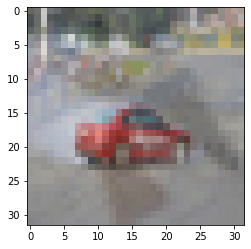

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


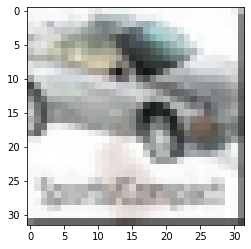

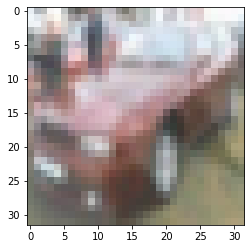

In [ ]:

#End2End training
success_e2e = []
j=0
for test_img in next(iter(testloader))[0]:
    if next(iter(testloader))[1][j] == 0:
        imshow(test_img)
        poison_batch = torch.FloatTensor(n,3,32,32)
        count = 0
        for base_img in next(iter(trainloader_poison))[0]:
            mod = base_img
            for i in range(100):
                mod = forward_e2e(mod,test_img,lr)
                mod = backward(mod,base_img,beta,lr)
            mod = (1-op)*mod + op*(test_img)
            imshow(mod)
            poison_batch[count,:,:,:] = mod
            count+=1
        #Train on poison
        poison_label = next(iter(trainloader_poison))[1]
        train_with_poison_end2end(poison_batch,poison_label)
        #Load model
        cnn = CNN_pre()
        PATH = "./weights_cnn_poisoned/weights"
        cnn.load_state_dict(torch.load(PATH))
        #Test target instance
        output = F.softmax(cnn(test_img.reshape(-1,3,32,32)),dim=1)
        print(output)
        _, predicted = torch.max(output.data, 1)
        if predicted.item() == 1:
            success_e2e.append(poison_batch)
        print("Target instance is predicted as {}".format(class_name(predicted.item())))
        imshow(test_img)   
    j=j+1
    

In [57]:
print(len(success_e2e))

18
